---
<a id='intro'></a> 

# 0. Introduction

In this project we will be working with Amazon review data for "groceries" and "gourmet food". The dataset was obtained through https://nijianmo.github.io/amazon/index.html and spans a period of 18 years from 2000-2018. The main objective of the project is to build a recommender system for recommending products to users. 

This project and notebook will deal with analysis of product ratings and review data for Amazon purchases. Two main tasks will be undertaken. The first concerns building a recommender system on the product data while the second concerns using survival analysis to model demand and time-to-next-purchase. The notebook will first give a descriptive overview of the data and present any overall preprocessing choices made with the data - e.g. transformations, only selecting a subset of the data etc.
The notebook will then proceed to the recommender system and survival analysis. Each of these sections will contain a brief introduction to the research questions being investigated as well as a presentation and discussion of the methods, results and future work. The two overarching research questions are as follows:

* To what extent can a recommender system be built to recommend products to users from the Amazon "Grocery and Gourmet Food" dataset and what characterizes the model that performs best?

* Survival

# 1. The dataset #

The dataset used contains reviews and ratings for a wide variety of products sold by Amazon. To limit the analysis we have chosen to focus on the "Groceries and Gourmet Food" category. The data was obtained through https://nijianmo.github.io/amazon/index.html and spans a period of 18 years from 2000-2018. In total, the dataset contains 5.074.160 reviews of products. We have selected a subset corresponding to 153.619 reviews covering 4092 unique products and 73632 unique users. Tables 1 and 2 shows descriptive statistics along with a brief description for the non-continuous and continuous variables respectively.

# 2. Recommender engine

With the dataset having been presented a recommender system will be built. The structure of this section will be as follows:
* 2.1 Build and evaluate the ability of the basic methods introduced in the course in building a recommender system. These methods are: ..

* 2.2 Combine these methods to see if a composite method performs better than the individual methods by themselves
* 2.3 Apply more advanced methods found through litterature review. Of main interest will be building a composite neural network that leverages rating information as well as context and content information about the products.
* 2.4 Discuss which model performs best and why. This step will involve trying to make sense of which products are recommended/disrecommended by the model and why.
* 2.5 Show a few 'proof-of-concept' examples of how the recommender system could function in practice. This step primarily concerns devising a simple solution for problems such as "what if the user doesn't buy the recommended items?". Steps 2.1-2.4 will all have a clear quantitative performance metric (MSE of rating predictions) while the point of step 2.5. is to devise solutions for problems our recommender system might face in real-time shopping situations. Seing as we do not have access to real-time data this step will remain in a 'proof-of-concept' state.

Brief litterature overview:
A brief litterature review was undertaken to find useable resources and guide the work with the recommender system. It was found that a considerable amount of litterature sought to leverage the text contained within reviews as a means of improving recommender systems. The reviews were seen as a potential source of raw implicit feedback (e.g. analyzing the sentiment of the review) as well as a way of extracting more detailed content about the products. The texts typically sought to combine LDA and MF (matrix factorization) either through bayesian approaches or neural networks. The two main .. we have used..

In [140]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import re
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics, preprocessing
from tensorflow.keras import models, layers, utils
dfs=pd.read_csv("preprocessed.csv")
dfs=dfs.iloc[:,3:]

In [141]:
dfs.columns

Index(['overall', 'verified', 'reviewTime', 'reviewerID', 'asin', 'reviewText',
       'summary', 'vote', 'style', 'bottomcat', 'price', 'main_cat', 'year',
       'day', 'month', 'season', 'review_length'],
      dtype='object')

# Create a DF ready for CF-analysis
First, a user-item ratings matrix is created. Non-nan values are scaled from 0 to 5 to 0 to 1 in anticipation of the neural networks being used.

In [142]:
mask=dfs.groupby('reviewerID').count()['asin']

In [143]:
mask=mask[mask>4]

In [144]:
dfs=dfs[dfs['reviewerID'].isin(mask.index)]
dfor=dfs.copy()

In [146]:
dfs['reviewerID'], list_userids=pd.factorize(dfs['reviewerID'])
dfs['asin'], list_itemids=pd.factorize(dfs['asin'])

In [180]:
df_cf=dfs.pivot_table(index="reviewerID", columns="asin", values="overall")
#df_cf = pd.DataFrame(preprocessing.MinMaxScaler(feature_range=(0.5,1)).fit_transform(df_cf.values), 
#columns=df_cf.columns, index=df_cf.index)

# Split data, keep 20% for testing.
split = int(0.8*df_cf.shape[1])
df_train = df_cf.iloc[:, :split-1]
df_test = df_cf.iloc[:, split:]

20% of the data is kept for testing.

In [182]:
# Convert to stacked format
train = df_train.stack(dropna=True).reset_index().rename(columns={0:"overall"})
train.columns=['user', 'product', 'overall']
test = df_test.stack(dropna=True).reset_index().rename(columns={0:"overall"})
test.columns=['user', 'product', 'overall']

In [183]:
df=dfs[['year', 'asin']]
df.columns=['year', 'product']
df2=dfs[['price', 'asin']]
df2.columns=['price', 'product']

In [184]:
trainf=train.merge(df['year'], how="left", left_on="product", right_index=True)
trainf=trainf.merge(df2['price'], how="left", left_on="product", right_index=True)
trainf['price']=trainf['price'].fillna(trainf['price'].mean())
testf=test.merge(df['year'], how="left", left_on="product", right_index=True)
testf=testf.merge(df2['price'], how="left", left_on="product", right_index=True)
testf['price']=testf['price'].fillna(trainf['price'].mean())

# Simple MF model #
Figure x shows the 3 models which will be created in the following sequences of code. The first model is a baseline MF model created through Keras. An embedding layer is created for the users and items respectively. Currently, the embedding output dimension is set to 50.
The output is a linear function of the dot product of the two embedding layers and the loss is set to MSE. The y for which the MSE should be minimized will be the actual ratings.

In [269]:
embeddings_size = 50
usr, prd = df_cf.shape[0], df_cf.shape[1]

# Create embedding layer for users
# Users (,1,embedding_size) and Reshape (,embedding_size)
xusers_in = layers.Input(name="xusers_in", shape=(1,))
xusers_emb = layers.Embedding(name="xusers_emb", input_dim=usr, output_dim=embeddings_size)(xusers_in)
xusers = layers.Reshape(name='xusers', target_shape=(embeddings_size,))(xusers_emb)

# Create embedding layer for products
# Products (,1,embedding_size) and Reshape (,embedding_size)
xproducts_in = layers.Input(name="xproducts_in", shape=(1,))
xproducts_emb = layers.Embedding(name="xproducts_emb", input_dim=prd, output_dim=embeddings_size)(xproducts_in)
xproducts = layers.Reshape(name='xproducts', target_shape=(embeddings_size,))(xproducts_emb)

# Compute dot product of the embedding layers
# Product (,1) values[-1,1]
QP = layers.Dot(name='xx', normalize=True, axes=1)([xusers, xproducts])

# Add output layer which takes as input QP
# Predict ratings (,1)
y_out = layers.Dense(name="y_out", units=1, activation='linear')(QP)

# Compile
model = models.Model(inputs=[xusers_in,xproducts_in], outputs=y_out, name="CollaborativeFiltering")
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mean_absolute_percentage_error'])
#model.summary()

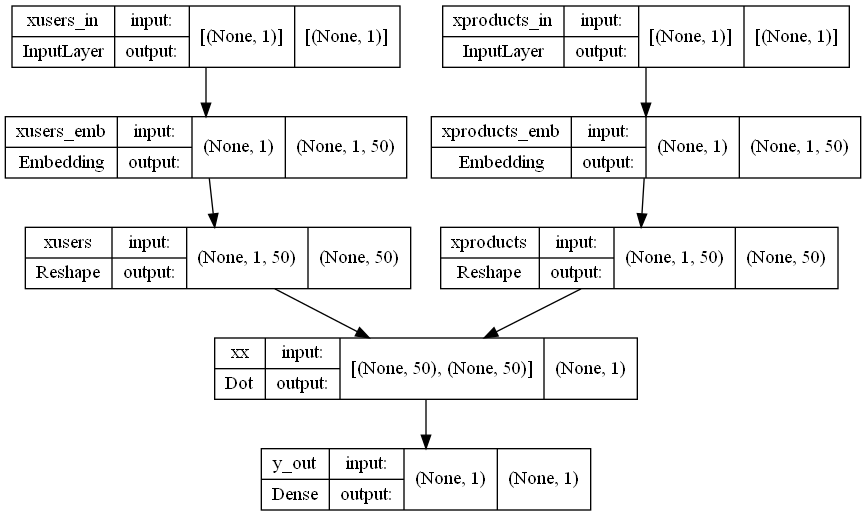

In [270]:
# The NN looks as follows
utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [271]:
'''
Plot loss and metrics of keras training.
'''
def utils_plot_keras_training(training):
    metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
    fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15,3))
    
    ## training
    ax[0].set(title="Training")
    ax11 = ax[0].twinx()
    ax[0].plot(training.history['loss'], color='black')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss', color='black')
    for metric in metrics:
        ax11.plot(training.history[metric], label=metric)
    ax11.set_ylabel("Score", color='steelblue')
    ax11.legend()
    
    ## validation
    ax[1].set(title="Validation")
    ax22 = ax[1].twinx()
    ax[1].plot(training.history['val_loss'], color='black')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss', color='black')
    for metric in metrics:
        ax22.plot(training.history['val_'+metric], label=metric)
    ax22.set_ylabel("Score", color="steelblue")
    plt.show()

In order for the model to work with tensorflow syntex the "IDs" of the user and item must be transformed to a number. This is done in the following code and a list of the original item/product IDs are saved for later use.

In [272]:
#train['reviewerID']=pd.factorize(train['reviewerID'])[0]
#train_userids=pd.factorize(train['reviewerID'])[1]
#train['asin']=pd.factorize(train['asin'])[0]
#train_itemids=pd.factorize(train['asin'])[1]

In [273]:
# train
training = model.fit(x=[train['user'], train['product']], y=train["overall"], 
                     epochs=1000, batch_size=128, shuffle=True, verbose=1, validation_split=0.3)
model = training.model

Epoch 1/1000
39/39 [==============================] - 1s 5ms/step - loss: 4.4568 - mean_absolute_percentage_error: 99.5283 - val_loss: 4.3586 - val_mean_absolute_percentage_error: 99.0408
Epoch 2/1000
39/39 [==============================] - 0s 2ms/step - loss: 4.2724 - mean_absolute_percentage_error: 94.7896 - val_loss: 4.3199 - val_mean_absolute_percentage_error: 98.0291
Epoch 3/1000
39/39 [==============================] - 0s 2ms/step - loss: 4.0997 - mean_absolute_percentage_error: 90.3636 - val_loss: 4.2810 - val_mean_absolute_percentage_error: 97.0043
Epoch 4/1000
39/39 [==============================] - 0s 2ms/step - loss: 3.9380 - mean_absolute_percentage_error: 86.2128 - val_loss: 4.2418 - val_mean_absolute_percentage_error: 95.9758
Epoch 5/1000
39/39 [==============================] - 0s 2ms/step - loss: 3.7919 - mean_absolute_percentage_error: 82.4772 - val_loss: 4.2024 - val_mean_absolute_percentage_error: 94.9275
Epoch 6/1000
39/39 [==============================] - 0s 2ms

39/39 [==============================] - 0s 2ms/step - loss: 0.6889 - mean_absolute_percentage_error: 16.4511 - val_loss: 2.8515 - val_mean_absolute_percentage_error: 62.8267
Epoch 45/1000
39/39 [==============================] - 0s 2ms/step - loss: 0.6452 - mean_absolute_percentage_error: 15.5043 - val_loss: 2.8247 - val_mean_absolute_percentage_error: 62.3256
Epoch 46/1000
39/39 [==============================] - 0s 2ms/step - loss: 0.6016 - mean_absolute_percentage_error: 14.5708 - val_loss: 2.7982 - val_mean_absolute_percentage_error: 61.8306
Epoch 47/1000
39/39 [==============================] - 0s 2ms/step - loss: 0.5633 - mean_absolute_percentage_error: 13.8509 - val_loss: 2.7703 - val_mean_absolute_percentage_error: 61.3050
Epoch 48/1000
39/39 [==============================] - 0s 2ms/step - loss: 0.5197 - mean_absolute_percentage_error: 12.9206 - val_loss: 2.7440 - val_mean_absolute_percentage_error: 60.8117
Epoch 49/1000
39/39 [==============================] - 0s 2ms/step - 

39/39 [==============================] - 0s 2ms/step - loss: 0.0841 - mean_absolute_percentage_error: 2.6133 - val_loss: 2.4315 - val_mean_absolute_percentage_error: 55.2309
Epoch 88/1000
39/39 [==============================] - 0s 2ms/step - loss: 0.0825 - mean_absolute_percentage_error: 2.5853 - val_loss: 2.4301 - val_mean_absolute_percentage_error: 55.2001
Epoch 89/1000
39/39 [==============================] - 0s 2ms/step - loss: 0.0803 - mean_absolute_percentage_error: 2.4932 - val_loss: 2.4292 - val_mean_absolute_percentage_error: 55.1989
Epoch 90/1000
39/39 [==============================] - 0s 2ms/step - loss: 0.0801 - mean_absolute_percentage_error: 2.5008 - val_loss: 2.4280 - val_mean_absolute_percentage_error: 55.1613
Epoch 91/1000
39/39 [==============================] - 0s 2ms/step - loss: 0.0798 - mean_absolute_percentage_error: 2.4626 - val_loss: 2.4255 - val_mean_absolute_percentage_error: 55.1299
Epoch 92/1000
39/39 [==============================] - 0s 2ms/step - loss:

39/39 [==============================] - 0s 2ms/step - loss: 0.0615 - mean_absolute_percentage_error: 1.8775 - val_loss: 2.3886 - val_mean_absolute_percentage_error: 54.5113
Epoch 131/1000
39/39 [==============================] - 0s 2ms/step - loss: 0.0594 - mean_absolute_percentage_error: 1.7587 - val_loss: 2.3872 - val_mean_absolute_percentage_error: 54.4920
Epoch 132/1000
39/39 [==============================] - 0s 2ms/step - loss: 0.0613 - mean_absolute_percentage_error: 1.8739 - val_loss: 2.3863 - val_mean_absolute_percentage_error: 54.4613
Epoch 133/1000
39/39 [==============================] - 0s 2ms/step - loss: 0.0584 - mean_absolute_percentage_error: 1.7351 - val_loss: 2.3858 - val_mean_absolute_percentage_error: 54.4597
Epoch 134/1000
39/39 [==============================] - 0s 2ms/step - loss: 0.0606 - mean_absolute_percentage_error: 1.8419 - val_loss: 2.3843 - val_mean_absolute_percentage_error: 54.4363
Epoch 135/1000
39/39 [==============================] - 0s 2ms/step - 

39/39 [==============================] - 0s 2ms/step - loss: 0.0525 - mean_absolute_percentage_error: 1.5973 - val_loss: 2.3435 - val_mean_absolute_percentage_error: 53.7025
Epoch 174/1000
39/39 [==============================] - 0s 2ms/step - loss: 0.0521 - mean_absolute_percentage_error: 1.5457 - val_loss: 2.3419 - val_mean_absolute_percentage_error: 53.6767
Epoch 175/1000
39/39 [==============================] - 0s 2ms/step - loss: 0.0515 - mean_absolute_percentage_error: 1.5616 - val_loss: 2.3378 - val_mean_absolute_percentage_error: 53.6097
Epoch 176/1000
39/39 [==============================] - 0s 2ms/step - loss: 0.0523 - mean_absolute_percentage_error: 1.5615 - val_loss: 2.3401 - val_mean_absolute_percentage_error: 53.6617
Epoch 177/1000
39/39 [==============================] - 0s 2ms/step - loss: 0.0515 - mean_absolute_percentage_error: 1.5305 - val_loss: 2.3389 - val_mean_absolute_percentage_error: 53.6273
Epoch 178/1000
39/39 [==============================] - 0s 2ms/step - 

39/39 [==============================] - 0s 2ms/step - loss: 0.0473 - mean_absolute_percentage_error: 1.4103 - val_loss: 2.2922 - val_mean_absolute_percentage_error: 52.8179
Epoch 217/1000
39/39 [==============================] - 0s 2ms/step - loss: 0.0472 - mean_absolute_percentage_error: 1.4025 - val_loss: 2.2938 - val_mean_absolute_percentage_error: 52.8434
Epoch 218/1000
39/39 [==============================] - 0s 2ms/step - loss: 0.0470 - mean_absolute_percentage_error: 1.3982 - val_loss: 2.2920 - val_mean_absolute_percentage_error: 52.8159
Epoch 219/1000
39/39 [==============================] - 0s 2ms/step - loss: 0.0474 - mean_absolute_percentage_error: 1.4019 - val_loss: 2.2882 - val_mean_absolute_percentage_error: 52.7438
Epoch 220/1000
39/39 [==============================] - 0s 2ms/step - loss: 0.0474 - mean_absolute_percentage_error: 1.4123 - val_loss: 2.2878 - val_mean_absolute_percentage_error: 52.7306
Epoch 221/1000
39/39 [==============================] - 0s 2ms/step - 

39/39 [==============================] - 0s 2ms/step - loss: 0.0427 - mean_absolute_percentage_error: 1.2832 - val_loss: 2.2446 - val_mean_absolute_percentage_error: 51.9855
Epoch 260/1000
39/39 [==============================] - 0s 2ms/step - loss: 0.0442 - mean_absolute_percentage_error: 1.3091 - val_loss: 2.2428 - val_mean_absolute_percentage_error: 51.9439
Epoch 261/1000
39/39 [==============================] - 0s 2ms/step - loss: 0.0425 - mean_absolute_percentage_error: 1.2609 - val_loss: 2.2436 - val_mean_absolute_percentage_error: 51.9665
Epoch 262/1000
39/39 [==============================] - 0s 2ms/step - loss: 0.0436 - mean_absolute_percentage_error: 1.2835 - val_loss: 2.2422 - val_mean_absolute_percentage_error: 51.9462
Epoch 263/1000
39/39 [==============================] - 0s 2ms/step - loss: 0.0425 - mean_absolute_percentage_error: 1.2735 - val_loss: 2.2413 - val_mean_absolute_percentage_error: 51.9219
Epoch 264/1000
39/39 [==============================] - 0s 2ms/step - 

39/39 [==============================] - 0s 3ms/step - loss: 0.0410 - mean_absolute_percentage_error: 1.2329 - val_loss: 2.2015 - val_mean_absolute_percentage_error: 51.2517
Epoch 303/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0396 - mean_absolute_percentage_error: 1.1753 - val_loss: 2.2001 - val_mean_absolute_percentage_error: 51.2219
Epoch 304/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0404 - mean_absolute_percentage_error: 1.2113 - val_loss: 2.1990 - val_mean_absolute_percentage_error: 51.2089
Epoch 305/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0407 - mean_absolute_percentage_error: 1.2079 - val_loss: 2.1996 - val_mean_absolute_percentage_error: 51.2195
Epoch 306/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0406 - mean_absolute_percentage_error: 1.1982 - val_loss: 2.1991 - val_mean_absolute_percentage_error: 51.2114
Epoch 307/1000
39/39 [==============================] - 0s 3ms/step - 

39/39 [==============================] - 0s 2ms/step - loss: 0.0381 - mean_absolute_percentage_error: 1.1189 - val_loss: 2.1627 - val_mean_absolute_percentage_error: 50.5874
Epoch 346/1000
39/39 [==============================] - 0s 2ms/step - loss: 0.0375 - mean_absolute_percentage_error: 1.0976 - val_loss: 2.1605 - val_mean_absolute_percentage_error: 50.5574
Epoch 347/1000
39/39 [==============================] - 0s 2ms/step - loss: 0.0380 - mean_absolute_percentage_error: 1.1232 - val_loss: 2.1589 - val_mean_absolute_percentage_error: 50.5221
Epoch 348/1000
39/39 [==============================] - 0s 2ms/step - loss: 0.0380 - mean_absolute_percentage_error: 1.1284 - val_loss: 2.1597 - val_mean_absolute_percentage_error: 50.5354
Epoch 349/1000
39/39 [==============================] - 0s 2ms/step - loss: 0.0375 - mean_absolute_percentage_error: 1.0942 - val_loss: 2.1588 - val_mean_absolute_percentage_error: 50.5255
Epoch 350/1000
39/39 [==============================] - 0s 2ms/step - 

39/39 [==============================] - 0s 2ms/step - loss: 0.0358 - mean_absolute_percentage_error: 1.0594 - val_loss: 2.1242 - val_mean_absolute_percentage_error: 49.9364
Epoch 389/1000
39/39 [==============================] - 0s 2ms/step - loss: 0.0357 - mean_absolute_percentage_error: 1.0506 - val_loss: 2.1251 - val_mean_absolute_percentage_error: 49.9560
Epoch 390/1000
39/39 [==============================] - 0s 2ms/step - loss: 0.0358 - mean_absolute_percentage_error: 1.0509 - val_loss: 2.1236 - val_mean_absolute_percentage_error: 49.9273
Epoch 391/1000
39/39 [==============================] - 0s 2ms/step - loss: 0.0354 - mean_absolute_percentage_error: 1.0493 - val_loss: 2.1245 - val_mean_absolute_percentage_error: 49.9440
Epoch 392/1000
39/39 [==============================] - 0s 2ms/step - loss: 0.0350 - mean_absolute_percentage_error: 1.0253 - val_loss: 2.1230 - val_mean_absolute_percentage_error: 49.9210
Epoch 393/1000
39/39 [==============================] - 0s 2ms/step - 

39/39 [==============================] - 0s 2ms/step - loss: 0.0337 - mean_absolute_percentage_error: 0.9807 - val_loss: 2.0941 - val_mean_absolute_percentage_error: 49.4317
Epoch 432/1000
39/39 [==============================] - 0s 2ms/step - loss: 0.0336 - mean_absolute_percentage_error: 0.9907 - val_loss: 2.0914 - val_mean_absolute_percentage_error: 49.3877
Epoch 433/1000
39/39 [==============================] - 0s 2ms/step - loss: 0.0336 - mean_absolute_percentage_error: 0.9785 - val_loss: 2.0919 - val_mean_absolute_percentage_error: 49.3950
Epoch 434/1000
39/39 [==============================] - 0s 2ms/step - loss: 0.0337 - mean_absolute_percentage_error: 0.9908 - val_loss: 2.0912 - val_mean_absolute_percentage_error: 49.3891
Epoch 435/1000
39/39 [==============================] - 0s 2ms/step - loss: 0.0344 - mean_absolute_percentage_error: 1.0132 - val_loss: 2.0903 - val_mean_absolute_percentage_error: 49.3719
Epoch 436/1000
39/39 [==============================] - 0s 2ms/step - 

39/39 [==============================] - 0s 2ms/step - loss: 0.0317 - mean_absolute_percentage_error: 0.9133 - val_loss: 2.0660 - val_mean_absolute_percentage_error: 48.9637
Epoch 475/1000
39/39 [==============================] - 0s 2ms/step - loss: 0.0322 - mean_absolute_percentage_error: 0.9361 - val_loss: 2.0636 - val_mean_absolute_percentage_error: 48.9292
Epoch 476/1000
39/39 [==============================] - 0s 2ms/step - loss: 0.0314 - mean_absolute_percentage_error: 0.9096 - val_loss: 2.0633 - val_mean_absolute_percentage_error: 48.9220
Epoch 477/1000
39/39 [==============================] - 0s 2ms/step - loss: 0.0326 - mean_absolute_percentage_error: 0.9669 - val_loss: 2.0638 - val_mean_absolute_percentage_error: 48.9365
Epoch 478/1000
39/39 [==============================] - 0s 2ms/step - loss: 0.0317 - mean_absolute_percentage_error: 0.9213 - val_loss: 2.0619 - val_mean_absolute_percentage_error: 48.8979
Epoch 479/1000
39/39 [==============================] - 0s 2ms/step - 

39/39 [==============================] - 0s 2ms/step - loss: 0.0304 - mean_absolute_percentage_error: 0.8818 - val_loss: 2.0385 - val_mean_absolute_percentage_error: 48.5139
Epoch 518/1000
39/39 [==============================] - 0s 2ms/step - loss: 0.0311 - mean_absolute_percentage_error: 0.8908 - val_loss: 2.0372 - val_mean_absolute_percentage_error: 48.4878
Epoch 519/1000
39/39 [==============================] - 0s 2ms/step - loss: 0.0301 - mean_absolute_percentage_error: 0.8594 - val_loss: 2.0358 - val_mean_absolute_percentage_error: 48.4685
Epoch 520/1000
39/39 [==============================] - 0s 2ms/step - loss: 0.0310 - mean_absolute_percentage_error: 0.8969 - val_loss: 2.0363 - val_mean_absolute_percentage_error: 48.4723
Epoch 521/1000
39/39 [==============================] - 0s 2ms/step - loss: 0.0304 - mean_absolute_percentage_error: 0.8769 - val_loss: 2.0359 - val_mean_absolute_percentage_error: 48.4680
Epoch 522/1000
39/39 [==============================] - 0s 2ms/step - 

39/39 [==============================] - 0s 2ms/step - loss: 0.0288 - mean_absolute_percentage_error: 0.8319 - val_loss: 2.0131 - val_mean_absolute_percentage_error: 48.1005
Epoch 561/1000
39/39 [==============================] - 0s 2ms/step - loss: 0.0296 - mean_absolute_percentage_error: 0.8529 - val_loss: 2.0126 - val_mean_absolute_percentage_error: 48.0903
Epoch 562/1000
39/39 [==============================] - 0s 2ms/step - loss: 0.0289 - mean_absolute_percentage_error: 0.8317 - val_loss: 2.0119 - val_mean_absolute_percentage_error: 48.0773
Epoch 563/1000
39/39 [==============================] - 0s 2ms/step - loss: 0.0296 - mean_absolute_percentage_error: 0.8598 - val_loss: 2.0120 - val_mean_absolute_percentage_error: 48.0835
Epoch 564/1000
39/39 [==============================] - 0s 2ms/step - loss: 0.0289 - mean_absolute_percentage_error: 0.8303 - val_loss: 2.0114 - val_mean_absolute_percentage_error: 48.0787
Epoch 565/1000
39/39 [==============================] - 0s 2ms/step - 

39/39 [==============================] - 0s 2ms/step - loss: 0.0281 - mean_absolute_percentage_error: 0.8064 - val_loss: 1.9902 - val_mean_absolute_percentage_error: 47.7289
Epoch 604/1000
39/39 [==============================] - 0s 2ms/step - loss: 0.0279 - mean_absolute_percentage_error: 0.7993 - val_loss: 1.9906 - val_mean_absolute_percentage_error: 47.7346
Epoch 605/1000
39/39 [==============================] - 0s 2ms/step - loss: 0.0281 - mean_absolute_percentage_error: 0.8021 - val_loss: 1.9907 - val_mean_absolute_percentage_error: 47.7346
Epoch 606/1000
39/39 [==============================] - 0s 2ms/step - loss: 0.0281 - mean_absolute_percentage_error: 0.8116 - val_loss: 1.9894 - val_mean_absolute_percentage_error: 47.7161
Epoch 607/1000
39/39 [==============================] - 0s 2ms/step - loss: 0.0282 - mean_absolute_percentage_error: 0.8073 - val_loss: 1.9892 - val_mean_absolute_percentage_error: 47.7165
Epoch 608/1000
39/39 [==============================] - 0s 2ms/step - 

39/39 [==============================] - 0s 2ms/step - loss: 0.0277 - mean_absolute_percentage_error: 0.7889 - val_loss: 1.9707 - val_mean_absolute_percentage_error: 47.4069
Epoch 647/1000
39/39 [==============================] - 0s 2ms/step - loss: 0.0275 - mean_absolute_percentage_error: 0.7769 - val_loss: 1.9690 - val_mean_absolute_percentage_error: 47.3794
Epoch 648/1000
39/39 [==============================] - 0s 2ms/step - loss: 0.0278 - mean_absolute_percentage_error: 0.8035 - val_loss: 1.9698 - val_mean_absolute_percentage_error: 47.3942
Epoch 649/1000
39/39 [==============================] - 0s 2ms/step - loss: 0.0273 - mean_absolute_percentage_error: 0.7740 - val_loss: 1.9681 - val_mean_absolute_percentage_error: 47.3700
Epoch 650/1000
39/39 [==============================] - 0s 2ms/step - loss: 0.0275 - mean_absolute_percentage_error: 0.7862 - val_loss: 1.9678 - val_mean_absolute_percentage_error: 47.3650
Epoch 651/1000
39/39 [==============================] - 0s 2ms/step - 

39/39 [==============================] - 0s 3ms/step - loss: 0.0264 - mean_absolute_percentage_error: 0.7637 - val_loss: 1.9512 - val_mean_absolute_percentage_error: 47.1043
Epoch 690/1000
39/39 [==============================] - 0s 2ms/step - loss: 0.0260 - mean_absolute_percentage_error: 0.7481 - val_loss: 1.9506 - val_mean_absolute_percentage_error: 47.0966
Epoch 691/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0263 - mean_absolute_percentage_error: 0.7506 - val_loss: 1.9490 - val_mean_absolute_percentage_error: 47.0750
Epoch 692/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0265 - mean_absolute_percentage_error: 0.7593 - val_loss: 1.9493 - val_mean_absolute_percentage_error: 47.0782
Epoch 693/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0266 - mean_absolute_percentage_error: 0.7687 - val_loss: 1.9494 - val_mean_absolute_percentage_error: 47.0802
Epoch 694/1000
39/39 [==============================] - 0s 3ms/step - 

39/39 [==============================] - 0s 2ms/step - loss: 0.0258 - mean_absolute_percentage_error: 0.7269 - val_loss: 1.9338 - val_mean_absolute_percentage_error: 46.8243
Epoch 733/1000
39/39 [==============================] - 0s 2ms/step - loss: 0.0254 - mean_absolute_percentage_error: 0.7259 - val_loss: 1.9333 - val_mean_absolute_percentage_error: 46.8214
Epoch 734/1000
39/39 [==============================] - 0s 2ms/step - loss: 0.0261 - mean_absolute_percentage_error: 0.7481 - val_loss: 1.9317 - val_mean_absolute_percentage_error: 46.7974
Epoch 735/1000
39/39 [==============================] - 0s 2ms/step - loss: 0.0254 - mean_absolute_percentage_error: 0.7158 - val_loss: 1.9332 - val_mean_absolute_percentage_error: 46.8219
Epoch 736/1000
39/39 [==============================] - 0s 2ms/step - loss: 0.0260 - mean_absolute_percentage_error: 0.7499 - val_loss: 1.9312 - val_mean_absolute_percentage_error: 46.7889
Epoch 737/1000
39/39 [==============================] - 0s 2ms/step - 

39/39 [==============================] - 0s 3ms/step - loss: 0.0251 - mean_absolute_percentage_error: 0.7108 - val_loss: 1.9163 - val_mean_absolute_percentage_error: 46.5496
Epoch 776/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0248 - mean_absolute_percentage_error: 0.7077 - val_loss: 1.9170 - val_mean_absolute_percentage_error: 46.5608
Epoch 777/1000
39/39 [==============================] - 0s 4ms/step - loss: 0.0250 - mean_absolute_percentage_error: 0.7128 - val_loss: 1.9163 - val_mean_absolute_percentage_error: 46.5534
Epoch 778/1000
39/39 [==============================] - 0s 4ms/step - loss: 0.0248 - mean_absolute_percentage_error: 0.7089 - val_loss: 1.9162 - val_mean_absolute_percentage_error: 46.5478
Epoch 779/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0253 - mean_absolute_percentage_error: 0.7138 - val_loss: 1.9152 - val_mean_absolute_percentage_error: 46.5319
Epoch 780/1000
39/39 [==============================] - 0s 3ms/step - 

39/39 [==============================] - 0s 3ms/step - loss: 0.0239 - mean_absolute_percentage_error: 0.6707 - val_loss: 1.9017 - val_mean_absolute_percentage_error: 46.3179
Epoch 819/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0245 - mean_absolute_percentage_error: 0.7086 - val_loss: 1.9006 - val_mean_absolute_percentage_error: 46.3100
Epoch 820/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0242 - mean_absolute_percentage_error: 0.6778 - val_loss: 1.9004 - val_mean_absolute_percentage_error: 46.3050
Epoch 821/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0245 - mean_absolute_percentage_error: 0.7026 - val_loss: 1.9007 - val_mean_absolute_percentage_error: 46.3097
Epoch 822/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0236 - mean_absolute_percentage_error: 0.6649 - val_loss: 1.9001 - val_mean_absolute_percentage_error: 46.2962
Epoch 823/1000
39/39 [==============================] - 0s 3ms/step - 

39/39 [==============================] - 0s 3ms/step - loss: 0.0237 - mean_absolute_percentage_error: 0.6716 - val_loss: 1.8876 - val_mean_absolute_percentage_error: 46.0963
Epoch 862/1000
39/39 [==============================] - 0s 2ms/step - loss: 0.0235 - mean_absolute_percentage_error: 0.6616 - val_loss: 1.8867 - val_mean_absolute_percentage_error: 46.0831
Epoch 863/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0240 - mean_absolute_percentage_error: 0.6802 - val_loss: 1.8867 - val_mean_absolute_percentage_error: 46.0840
Epoch 864/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0235 - mean_absolute_percentage_error: 0.6717 - val_loss: 1.8872 - val_mean_absolute_percentage_error: 46.0903
Epoch 865/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0235 - mean_absolute_percentage_error: 0.6617 - val_loss: 1.8848 - val_mean_absolute_percentage_error: 46.0542
Epoch 866/1000
39/39 [==============================] - 0s 2ms/step - 

39/39 [==============================] - 0s 2ms/step - loss: 0.0229 - mean_absolute_percentage_error: 0.6528 - val_loss: 1.8731 - val_mean_absolute_percentage_error: 45.8668
Epoch 905/1000
39/39 [==============================] - 0s 2ms/step - loss: 0.0230 - mean_absolute_percentage_error: 0.6502 - val_loss: 1.8739 - val_mean_absolute_percentage_error: 45.8803
Epoch 906/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0232 - mean_absolute_percentage_error: 0.6652 - val_loss: 1.8724 - val_mean_absolute_percentage_error: 45.8528
Epoch 907/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0229 - mean_absolute_percentage_error: 0.6370 - val_loss: 1.8745 - val_mean_absolute_percentage_error: 45.8895
Epoch 908/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0232 - mean_absolute_percentage_error: 0.6622 - val_loss: 1.8721 - val_mean_absolute_percentage_error: 45.8487
Epoch 909/1000
39/39 [==============================] - 0s 3ms/step - 

39/39 [==============================] - 0s 3ms/step - loss: 0.0226 - mean_absolute_percentage_error: 0.6377 - val_loss: 1.8622 - val_mean_absolute_percentage_error: 45.6985
Epoch 948/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0224 - mean_absolute_percentage_error: 0.6310 - val_loss: 1.8603 - val_mean_absolute_percentage_error: 45.6659
Epoch 949/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0225 - mean_absolute_percentage_error: 0.6287 - val_loss: 1.8611 - val_mean_absolute_percentage_error: 45.6754
Epoch 950/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0231 - mean_absolute_percentage_error: 0.6518 - val_loss: 1.8606 - val_mean_absolute_percentage_error: 45.6712
Epoch 951/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0224 - mean_absolute_percentage_error: 0.6285 - val_loss: 1.8594 - val_mean_absolute_percentage_error: 45.6516
Epoch 952/1000
39/39 [==============================] - 0s 3ms/step - 

39/39 [==============================] - 0s 3ms/step - loss: 0.0219 - mean_absolute_percentage_error: 0.6150 - val_loss: 1.8493 - val_mean_absolute_percentage_error: 45.5001
Epoch 991/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0219 - mean_absolute_percentage_error: 0.6240 - val_loss: 1.8511 - val_mean_absolute_percentage_error: 45.5294
Epoch 992/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0222 - mean_absolute_percentage_error: 0.6171 - val_loss: 1.8497 - val_mean_absolute_percentage_error: 45.5040
Epoch 993/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0217 - mean_absolute_percentage_error: 0.6120 - val_loss: 1.8489 - val_mean_absolute_percentage_error: 45.4965
Epoch 994/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0221 - mean_absolute_percentage_error: 0.6186 - val_loss: 1.8481 - val_mean_absolute_percentage_error: 45.4822
Epoch 995/1000
39/39 [==============================] - 0s 3ms/step - 

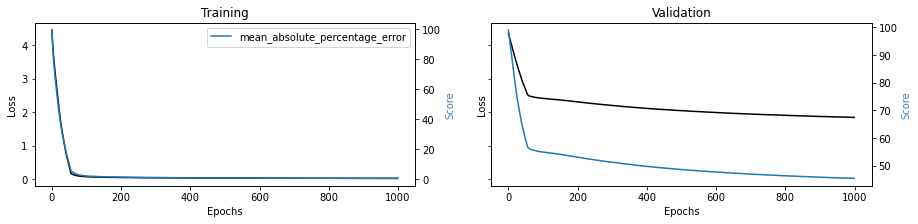

In [274]:
utils_plot_keras_training(training)

In [277]:
# Test
test['yhat'] = model.predict([test["user"], test["product"]])
test
#np.mean((test['overall']-test['yhat'])**2)

,user,product,overall,yhat
0,2,2161,5.0,2.019211
1,3,2177,5.0,2.313081
2,4,2079,4.0,3.030834
3,4,2125,4.0,3.118089
4,4,2265,4.0,3.153425
...,...,...,...,...
1566,1608,2344,5.0,1.918438
1567,1608,2353,5.0,2.755638
1568,1608,2359,5.0,2.779956
1569,1608,2363,5.0,2.530440


(<AxesSubplot:>, <AxesSubplot:>)

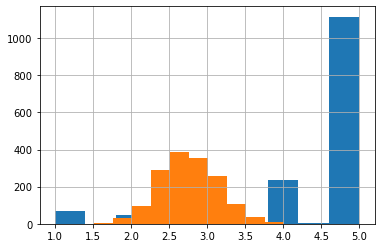

In [278]:
test['overall'].hist(), test['yhat'].hist()

In [279]:
np.mean((test['overall']-test['yhat'])**2)

4.06959178676985

# Performance metrics #

The following metrics will be used to provide an overview of the performance of the different models.
* MSE (or MAE) - i.e. measures of how accurately the value of the ratings are predicted.
* Raw classification measures - classification measures assuming that a predicted rating of >= 4 constitutes a success (purchase).
* Scaled classification measures - classification measures adjusted for the distribution of the predicted ratings. I.e. if 80% of the observed ratings are >= 4, then a predicted rating is considered a success if it is above the 20'th percentile of the predicted ratings (i.e. among the top 80% of predicted ratings).
* Ordering of products - Are the products with the highest predicted ratings also the products bought/reviewed?
The loss function of the models will only seek to optimize some of the performance metrics. Therefore, some of the metrics (such as 'ordering of products') is only used as ways of helping interpret the performance of the model.

In [280]:
from sklearn.metrics import r2_score

ypred = test['yhat']
ytrue = test['overall']
cutoff = 4

def PerformanceMetrics(ytrue, ypred, ydiff, cutoff):
    r2_model=r2_score(ytrue, ypred) # Calculate r2_score of predictions

    squarederror_model = (ytrue-ypred)**2 # Calculate SE of predictions
    MSE_model=squarederror_model.mean() # MSE

    abserror_model = np.abs(ytrue-ypred) # Calculate AE of predictions
    MAE_model = abserror_model.mean()

    APE_model = 100*np.abs((ytrue-ypred)/ytrue) # Calculate APE of predictions
    MAPE_model = APE_model.mean()
    positives_obs = (ytrue>=cutoff).sum()
    negatives_obs = (ytrue<cutoff).sum()
    positives_pred = (ypred>=cutoff).sum()
    negatives_pred = (ypred<cutoff).sum()

    tn = np.sum((ytrue<cutoff)&(ypred<cutoff))
    tp = np.sum((ytrue>=cutoff)&(ypred>=cutoff))
    fn = np.sum((ytrue>=cutoff)&(ypred<cutoff))
    fp = np.sum((ytrue<cutoff)&(ypred>=cutoff))

    #perc=test[test['overall']>=4].shape[0]/test.shape[0]
    #q=test['yhat'].quantile(1-perc)
    #positives_c = test[test['yhat']>=q].shape[0]
    #negatives_c = test[test['yhat']<q].shape[0]

    accuracy = (tp+tn)/(tp+tn+fp+fn)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1=2*(precision*recall)/(precision+recall)
    specificity = tn/(tn+fp)
    
    # Hvor mange er forudsagt mindre end de faktisk er
    under_modeln=np.sum(ydiff<0)

    # Hvor mange er forudsagt større end de faktisk er
    over_modeln=np.sum(ydiff>0)
    
    # Lige på
    equal_modeln = np.sum(ydiff==0)


    KPI_model = np.array([r2_model, MSE_model, MAE_model, MAPE_model, under_modeln, over_modeln, equal_modeln,
                         tp, tn, fp, fn, accuracy, precision, recall, f1, specificity])
    KPIdf=pd.DataFrame(KPI_model).T
    KPIdf.columns=['r2', 'MSE', 'MAE', 'MAPE', 'pred<true', 'pred>true', 'equal', 'TP', 'TN', 'FP', 'FN',
                  'Accuracy', 'Precision', 'Recall', 'f1', 'Specificity']


    return KPIdf, KPI_model

In [281]:
KPIdf, _=PerformanceMetrics(test['overall'], test['yhat'], test['overall']-test['yhat'], 4)

In [282]:
KPIdf

,r2,MSE,MAE,MAPE,pred<true,pred>true,equal,TP,TN,FP,FN,Accuracy,Precision,Recall,f1,Specificity
0,-2.688928,4.069592,1.895443,46.037999,142.0,1429.0,0.0,1.0,219.0,0.0,1351.0,0.140038,1.0,0.00074,0.001478,1.0


In [283]:
embeddings_size = 50
usr, prd = df_cf.shape[0], df_cf.shape[1]

# Input layer
xusers_in = layers.Input(name="xusers_in", shape=(1,))
xproducts_in = layers.Input(name="xproducts_in", shape=(1,))

# Matrix Factorization
## embeddings and reshape
cf_xusers_emb = layers.Embedding(name="cf_xusers_emb", input_dim=usr, output_dim=embeddings_size)(xusers_in)
cf_xusers = layers.Reshape(name='cf_xusers', target_shape=(embeddings_size,))(cf_xusers_emb)
## embeddings and reshape
cf_xproducts_emb = layers.Embedding(name="cf_xproducts_emb", input_dim=prd, output_dim=embeddings_size)(xproducts_in)
cf_xproducts = layers.Reshape(name='cf_xproducts', target_shape=(embeddings_size,))(cf_xproducts_emb)
## product
cf_xx = layers.Dot(name='cf_xx', normalize=True, axes=1)([cf_xusers, cf_xproducts])

# Neural Network
## embeddings and reshape
nn_xusers_emb = layers.Embedding(name="nn_xusers_emb", input_dim=usr, output_dim=embeddings_size)(xusers_in)
nn_xusers = layers.Reshape(name='nn_xusers', target_shape=(embeddings_size,))(nn_xusers_emb)
## embeddings and reshape
nn_xproducts_emb = layers.Embedding(name="nn_xproducts_emb", input_dim=prd, output_dim=embeddings_size)(xproducts_in)
nn_xproducts = layers.Reshape(name='nn_xproducts', target_shape=(embeddings_size,))(nn_xproducts_emb)
## concat and dense
nn_xx = layers.Concatenate()([nn_xusers, nn_xproducts])
nn_xx = layers.Dense(name="nn_xx", units=int(embeddings_size/2), activation='relu')(nn_xx)

# Merge A & B
y_out = layers.Concatenate()([cf_xx, nn_xx])
y_out = layers.Dense(name="y_out", units=1, activation='linear')(y_out)

# Compile
model = models.Model(inputs=[xusers_in,xproducts_in], outputs=y_out, name="Neural_CollaborativeFiltering")
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mean_absolute_percentage_error'])
#model.summary()

Epoch 1/1000
39/39 [==============================] - 1s 6ms/step - loss: 4.3493 - mean_absolute_percentage_error: 96.7429 - val_loss: 4.1472 - val_mean_absolute_percentage_error: 93.3814
Epoch 2/1000
39/39 [==============================] - 0s 3ms/step - loss: 3.6777 - mean_absolute_percentage_error: 80.0476 - val_loss: 3.5213 - val_mean_absolute_percentage_error: 77.3090
Epoch 3/1000
39/39 [==============================] - 0s 3ms/step - loss: 1.9534 - mean_absolute_percentage_error: 45.9881 - val_loss: 2.4077 - val_mean_absolute_percentage_error: 55.8048
Epoch 4/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.8220 - mean_absolute_percentage_error: 27.1692 - val_loss: 2.4244 - val_mean_absolute_percentage_error: 55.8720
Epoch 5/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.5744 - mean_absolute_percentage_error: 20.4743 - val_loss: 2.3844 - val_mean_absolute_percentage_error: 55.1220
Epoch 6/1000
39/39 [==============================] - 0s 3ms

39/39 [==============================] - 0s 3ms/step - loss: 0.1424 - mean_absolute_percentage_error: 5.3090 - val_loss: 2.1573 - val_mean_absolute_percentage_error: 50.7442
Epoch 45/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.1429 - mean_absolute_percentage_error: 5.2763 - val_loss: 2.1422 - val_mean_absolute_percentage_error: 50.5285
Epoch 46/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.1375 - mean_absolute_percentage_error: 5.1049 - val_loss: 2.1291 - val_mean_absolute_percentage_error: 50.2655
Epoch 47/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.1378 - mean_absolute_percentage_error: 5.0992 - val_loss: 2.1377 - val_mean_absolute_percentage_error: 50.4852
Epoch 48/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.1347 - mean_absolute_percentage_error: 4.9402 - val_loss: 2.1268 - val_mean_absolute_percentage_error: 50.2205
Epoch 49/1000
39/39 [==============================] - 0s 3ms/step - loss:

Epoch 88/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0871 - mean_absolute_percentage_error: 2.9114 - val_loss: 1.8318 - val_mean_absolute_percentage_error: 45.2719
Epoch 89/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0837 - mean_absolute_percentage_error: 2.8082 - val_loss: 1.8312 - val_mean_absolute_percentage_error: 45.2197
Epoch 90/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0835 - mean_absolute_percentage_error: 2.7939 - val_loss: 1.8168 - val_mean_absolute_percentage_error: 45.0212
Epoch 91/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0821 - mean_absolute_percentage_error: 2.7382 - val_loss: 1.8100 - val_mean_absolute_percentage_error: 44.9077
Epoch 92/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0828 - mean_absolute_percentage_error: 2.7849 - val_loss: 1.8026 - val_mean_absolute_percentage_error: 44.8287
Epoch 93/1000
39/39 [==============================] - 0s 3m

39/39 [==============================] - 0s 3ms/step - loss: 0.0648 - mean_absolute_percentage_error: 2.0877 - val_loss: 1.6225 - val_mean_absolute_percentage_error: 42.0299
Epoch 132/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0640 - mean_absolute_percentage_error: 2.0538 - val_loss: 1.6247 - val_mean_absolute_percentage_error: 42.0622
Epoch 133/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0641 - mean_absolute_percentage_error: 2.0582 - val_loss: 1.6123 - val_mean_absolute_percentage_error: 41.8757
Epoch 134/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0615 - mean_absolute_percentage_error: 2.0002 - val_loss: 1.6041 - val_mean_absolute_percentage_error: 41.7403
Epoch 135/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0636 - mean_absolute_percentage_error: 2.0442 - val_loss: 1.6155 - val_mean_absolute_percentage_error: 41.9009
Epoch 136/1000
39/39 [==============================] - 0s 3ms/step - 

39/39 [==============================] - 0s 4ms/step - loss: 0.0537 - mean_absolute_percentage_error: 1.6862 - val_loss: 1.5133 - val_mean_absolute_percentage_error: 40.3969
Epoch 175/1000
39/39 [==============================] - 0s 4ms/step - loss: 0.0531 - mean_absolute_percentage_error: 1.6588 - val_loss: 1.5086 - val_mean_absolute_percentage_error: 40.3412
Epoch 176/1000
39/39 [==============================] - 0s 4ms/step - loss: 0.0530 - mean_absolute_percentage_error: 1.6726 - val_loss: 1.5114 - val_mean_absolute_percentage_error: 40.3805
Epoch 177/1000
39/39 [==============================] - 0s 4ms/step - loss: 0.0525 - mean_absolute_percentage_error: 1.6464 - val_loss: 1.5054 - val_mean_absolute_percentage_error: 40.2873
Epoch 178/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0534 - mean_absolute_percentage_error: 1.6738 - val_loss: 1.5157 - val_mean_absolute_percentage_error: 40.4385
Epoch 179/1000
39/39 [==============================] - 0s 3ms/step - 

39/39 [==============================] - 0s 3ms/step - loss: 0.0465 - mean_absolute_percentage_error: 1.4066 - val_loss: 1.4544 - val_mean_absolute_percentage_error: 39.5454
Epoch 218/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0467 - mean_absolute_percentage_error: 1.4229 - val_loss: 1.4464 - val_mean_absolute_percentage_error: 39.4500
Epoch 219/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0462 - mean_absolute_percentage_error: 1.4158 - val_loss: 1.4448 - val_mean_absolute_percentage_error: 39.4319
Epoch 220/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0469 - mean_absolute_percentage_error: 1.4231 - val_loss: 1.4468 - val_mean_absolute_percentage_error: 39.4554
Epoch 221/1000
39/39 [==============================] - 0s 4ms/step - loss: 0.0474 - mean_absolute_percentage_error: 1.4242 - val_loss: 1.4416 - val_mean_absolute_percentage_error: 39.3770
Epoch 222/1000
39/39 [==============================] - 0s 3ms/step - 

39/39 [==============================] - 0s 3ms/step - loss: 0.0405 - mean_absolute_percentage_error: 1.1838 - val_loss: 1.4009 - val_mean_absolute_percentage_error: 38.8459
Epoch 261/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0419 - mean_absolute_percentage_error: 1.2346 - val_loss: 1.4020 - val_mean_absolute_percentage_error: 38.8545
Epoch 262/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0405 - mean_absolute_percentage_error: 1.1958 - val_loss: 1.3978 - val_mean_absolute_percentage_error: 38.7841
Epoch 263/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0413 - mean_absolute_percentage_error: 1.2208 - val_loss: 1.4023 - val_mean_absolute_percentage_error: 38.8610
Epoch 264/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0421 - mean_absolute_percentage_error: 1.2234 - val_loss: 1.3941 - val_mean_absolute_percentage_error: 38.7442
Epoch 265/1000
39/39 [==============================] - 0s 3ms/step - 

39/39 [==============================] - 0s 3ms/step - loss: 0.0391 - mean_absolute_percentage_error: 1.1038 - val_loss: 1.3607 - val_mean_absolute_percentage_error: 38.3173
Epoch 304/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0373 - mean_absolute_percentage_error: 1.0666 - val_loss: 1.3635 - val_mean_absolute_percentage_error: 38.3482
Epoch 305/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0367 - mean_absolute_percentage_error: 1.0460 - val_loss: 1.3601 - val_mean_absolute_percentage_error: 38.3080
Epoch 306/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0378 - mean_absolute_percentage_error: 1.0923 - val_loss: 1.3619 - val_mean_absolute_percentage_error: 38.3183
Epoch 307/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0386 - mean_absolute_percentage_error: 1.0973 - val_loss: 1.3656 - val_mean_absolute_percentage_error: 38.3672
Epoch 308/1000
39/39 [==============================] - 0s 3ms/step - 

39/39 [==============================] - 0s 3ms/step - loss: 0.0326 - mean_absolute_percentage_error: 0.9301 - val_loss: 1.3331 - val_mean_absolute_percentage_error: 37.9461
Epoch 347/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0330 - mean_absolute_percentage_error: 0.9521 - val_loss: 1.3395 - val_mean_absolute_percentage_error: 38.0307
Epoch 348/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0336 - mean_absolute_percentage_error: 0.9485 - val_loss: 1.3368 - val_mean_absolute_percentage_error: 37.9855
Epoch 349/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0338 - mean_absolute_percentage_error: 0.9695 - val_loss: 1.3387 - val_mean_absolute_percentage_error: 38.0094
Epoch 350/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0337 - mean_absolute_percentage_error: 0.9595 - val_loss: 1.3379 - val_mean_absolute_percentage_error: 38.0006
Epoch 351/1000
39/39 [==============================] - 0s 3ms/step - 

39/39 [==============================] - 0s 3ms/step - loss: 0.0313 - mean_absolute_percentage_error: 0.8953 - val_loss: 1.3211 - val_mean_absolute_percentage_error: 37.7770
Epoch 390/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0322 - mean_absolute_percentage_error: 0.9171 - val_loss: 1.3119 - val_mean_absolute_percentage_error: 37.6598
Epoch 391/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0306 - mean_absolute_percentage_error: 0.8825 - val_loss: 1.3126 - val_mean_absolute_percentage_error: 37.6758
Epoch 392/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0317 - mean_absolute_percentage_error: 0.8979 - val_loss: 1.3118 - val_mean_absolute_percentage_error: 37.6586
Epoch 393/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0305 - mean_absolute_percentage_error: 0.8683 - val_loss: 1.3175 - val_mean_absolute_percentage_error: 37.7377
Epoch 394/1000
39/39 [==============================] - 0s 3ms/step - 

39/39 [==============================] - 0s 3ms/step - loss: 0.0299 - mean_absolute_percentage_error: 0.8457 - val_loss: 1.2962 - val_mean_absolute_percentage_error: 37.4446
Epoch 433/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0307 - mean_absolute_percentage_error: 0.8770 - val_loss: 1.2958 - val_mean_absolute_percentage_error: 37.4576
Epoch 434/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0304 - mean_absolute_percentage_error: 0.8505 - val_loss: 1.2915 - val_mean_absolute_percentage_error: 37.3815
Epoch 435/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0297 - mean_absolute_percentage_error: 0.8602 - val_loss: 1.2961 - val_mean_absolute_percentage_error: 37.4549
Epoch 436/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0287 - mean_absolute_percentage_error: 0.8177 - val_loss: 1.2947 - val_mean_absolute_percentage_error: 37.4274
Epoch 437/1000
39/39 [==============================] - 0s 3ms/step - 

39/39 [==============================] - 0s 3ms/step - loss: 0.0275 - mean_absolute_percentage_error: 0.7804 - val_loss: 1.2869 - val_mean_absolute_percentage_error: 37.3283
Epoch 476/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0277 - mean_absolute_percentage_error: 0.7980 - val_loss: 1.2886 - val_mean_absolute_percentage_error: 37.3429
Epoch 477/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0288 - mean_absolute_percentage_error: 0.8201 - val_loss: 1.2916 - val_mean_absolute_percentage_error: 37.3777
Epoch 478/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0270 - mean_absolute_percentage_error: 0.7754 - val_loss: 1.2890 - val_mean_absolute_percentage_error: 37.3586
Epoch 479/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0279 - mean_absolute_percentage_error: 0.7893 - val_loss: 1.2896 - val_mean_absolute_percentage_error: 37.3624
Epoch 480/1000
39/39 [==============================] - 0s 3ms/step - 

39/39 [==============================] - 0s 3ms/step - loss: 0.0271 - mean_absolute_percentage_error: 0.7561 - val_loss: 1.2824 - val_mean_absolute_percentage_error: 37.2650
Epoch 519/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0270 - mean_absolute_percentage_error: 0.7637 - val_loss: 1.2764 - val_mean_absolute_percentage_error: 37.1891
Epoch 520/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0279 - mean_absolute_percentage_error: 0.7894 - val_loss: 1.2776 - val_mean_absolute_percentage_error: 37.2002
Epoch 521/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0272 - mean_absolute_percentage_error: 0.7764 - val_loss: 1.2843 - val_mean_absolute_percentage_error: 37.2920
Epoch 522/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0276 - mean_absolute_percentage_error: 0.7692 - val_loss: 1.2787 - val_mean_absolute_percentage_error: 37.2253
Epoch 523/1000
39/39 [==============================] - 0s 3ms/step - 

39/39 [==============================] - 0s 3ms/step - loss: 0.0258 - mean_absolute_percentage_error: 0.7203 - val_loss: 1.2677 - val_mean_absolute_percentage_error: 37.0768
Epoch 562/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0261 - mean_absolute_percentage_error: 0.7274 - val_loss: 1.2740 - val_mean_absolute_percentage_error: 37.1620
Epoch 563/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0258 - mean_absolute_percentage_error: 0.7316 - val_loss: 1.2734 - val_mean_absolute_percentage_error: 37.1524
Epoch 564/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0253 - mean_absolute_percentage_error: 0.7086 - val_loss: 1.2716 - val_mean_absolute_percentage_error: 37.1227
Epoch 565/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0254 - mean_absolute_percentage_error: 0.7151 - val_loss: 1.2694 - val_mean_absolute_percentage_error: 37.1024
Epoch 566/1000
39/39 [==============================] - 0s 3ms/step - 

39/39 [==============================] - 0s 3ms/step - loss: 0.0248 - mean_absolute_percentage_error: 0.7012 - val_loss: 1.2669 - val_mean_absolute_percentage_error: 37.0550
Epoch 605/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0240 - mean_absolute_percentage_error: 0.6702 - val_loss: 1.2622 - val_mean_absolute_percentage_error: 36.9906
Epoch 606/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0234 - mean_absolute_percentage_error: 0.6689 - val_loss: 1.2694 - val_mean_absolute_percentage_error: 37.0860
Epoch 607/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0246 - mean_absolute_percentage_error: 0.6805 - val_loss: 1.2645 - val_mean_absolute_percentage_error: 37.0201
Epoch 608/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0260 - mean_absolute_percentage_error: 0.7153 - val_loss: 1.2715 - val_mean_absolute_percentage_error: 37.1143
Epoch 609/1000
39/39 [==============================] - 0s 3ms/step - 

39/39 [==============================] - 0s 3ms/step - loss: 0.0241 - mean_absolute_percentage_error: 0.6757 - val_loss: 1.2608 - val_mean_absolute_percentage_error: 36.9686
Epoch 648/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0235 - mean_absolute_percentage_error: 0.6620 - val_loss: 1.2579 - val_mean_absolute_percentage_error: 36.9378
Epoch 649/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0247 - mean_absolute_percentage_error: 0.6933 - val_loss: 1.2619 - val_mean_absolute_percentage_error: 36.9925
Epoch 650/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0242 - mean_absolute_percentage_error: 0.6765 - val_loss: 1.2564 - val_mean_absolute_percentage_error: 36.9323
Epoch 651/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0235 - mean_absolute_percentage_error: 0.6679 - val_loss: 1.2622 - val_mean_absolute_percentage_error: 36.9969
Epoch 652/1000
39/39 [==============================] - 0s 3ms/step - 

39/39 [==============================] - 0s 3ms/step - loss: 0.0232 - mean_absolute_percentage_error: 0.6520 - val_loss: 1.2534 - val_mean_absolute_percentage_error: 36.8803
Epoch 691/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0226 - mean_absolute_percentage_error: 0.6221 - val_loss: 1.2534 - val_mean_absolute_percentage_error: 36.8711
Epoch 692/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0218 - mean_absolute_percentage_error: 0.6112 - val_loss: 1.2491 - val_mean_absolute_percentage_error: 36.8250
Epoch 693/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0233 - mean_absolute_percentage_error: 0.6519 - val_loss: 1.2565 - val_mean_absolute_percentage_error: 36.9125
Epoch 694/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0238 - mean_absolute_percentage_error: 0.6639 - val_loss: 1.2484 - val_mean_absolute_percentage_error: 36.8228
Epoch 695/1000
39/39 [==============================] - 0s 3ms/step - 

39/39 [==============================] - 0s 3ms/step - loss: 0.0223 - mean_absolute_percentage_error: 0.6154 - val_loss: 1.2517 - val_mean_absolute_percentage_error: 36.8494
Epoch 734/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0218 - mean_absolute_percentage_error: 0.6121 - val_loss: 1.2439 - val_mean_absolute_percentage_error: 36.7534
Epoch 735/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0217 - mean_absolute_percentage_error: 0.6112 - val_loss: 1.2537 - val_mean_absolute_percentage_error: 36.8657
Epoch 736/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0216 - mean_absolute_percentage_error: 0.6132 - val_loss: 1.2489 - val_mean_absolute_percentage_error: 36.8114
Epoch 737/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0224 - mean_absolute_percentage_error: 0.6182 - val_loss: 1.2502 - val_mean_absolute_percentage_error: 36.8227
Epoch 738/1000
39/39 [==============================] - 0s 3ms/step - 

39/39 [==============================] - 0s 3ms/step - loss: 0.0202 - mean_absolute_percentage_error: 0.5604 - val_loss: 1.2487 - val_mean_absolute_percentage_error: 36.8163
Epoch 777/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0215 - mean_absolute_percentage_error: 0.6057 - val_loss: 1.2498 - val_mean_absolute_percentage_error: 36.8150
Epoch 778/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0212 - mean_absolute_percentage_error: 0.5959 - val_loss: 1.2502 - val_mean_absolute_percentage_error: 36.8186
Epoch 779/1000
39/39 [==============================] - 0s 4ms/step - loss: 0.0215 - mean_absolute_percentage_error: 0.6075 - val_loss: 1.2479 - val_mean_absolute_percentage_error: 36.7958
Epoch 780/1000
39/39 [==============================] - 0s 4ms/step - loss: 0.0209 - mean_absolute_percentage_error: 0.5778 - val_loss: 1.2430 - val_mean_absolute_percentage_error: 36.7269
Epoch 781/1000
39/39 [==============================] - 0s 3ms/step - 

39/39 [==============================] - 0s 3ms/step - loss: 0.0206 - mean_absolute_percentage_error: 0.5790 - val_loss: 1.2429 - val_mean_absolute_percentage_error: 36.7360
Epoch 820/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0203 - mean_absolute_percentage_error: 0.5559 - val_loss: 1.2393 - val_mean_absolute_percentage_error: 36.6864
Epoch 821/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0213 - mean_absolute_percentage_error: 0.5890 - val_loss: 1.2418 - val_mean_absolute_percentage_error: 36.7240
Epoch 822/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0210 - mean_absolute_percentage_error: 0.5785 - val_loss: 1.2394 - val_mean_absolute_percentage_error: 36.6953
Epoch 823/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0213 - mean_absolute_percentage_error: 0.5870 - val_loss: 1.2422 - val_mean_absolute_percentage_error: 36.7242
Epoch 824/1000
39/39 [==============================] - 0s 3ms/step - 

39/39 [==============================] - 0s 3ms/step - loss: 0.0203 - mean_absolute_percentage_error: 0.5562 - val_loss: 1.2385 - val_mean_absolute_percentage_error: 36.6763
Epoch 863/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0201 - mean_absolute_percentage_error: 0.5518 - val_loss: 1.2362 - val_mean_absolute_percentage_error: 36.6501
Epoch 864/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0204 - mean_absolute_percentage_error: 0.5617 - val_loss: 1.2397 - val_mean_absolute_percentage_error: 36.6902
Epoch 865/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0208 - mean_absolute_percentage_error: 0.5732 - val_loss: 1.2406 - val_mean_absolute_percentage_error: 36.7022
Epoch 866/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0204 - mean_absolute_percentage_error: 0.5723 - val_loss: 1.2418 - val_mean_absolute_percentage_error: 36.7232
Epoch 867/1000
39/39 [==============================] - 0s 3ms/step - 

39/39 [==============================] - 0s 3ms/step - loss: 0.0197 - mean_absolute_percentage_error: 0.5497 - val_loss: 1.2412 - val_mean_absolute_percentage_error: 36.7135
Epoch 906/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0196 - mean_absolute_percentage_error: 0.5267 - val_loss: 1.2358 - val_mean_absolute_percentage_error: 36.6539
Epoch 907/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0205 - mean_absolute_percentage_error: 0.5730 - val_loss: 1.2390 - val_mean_absolute_percentage_error: 36.6888
Epoch 908/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0199 - mean_absolute_percentage_error: 0.5360 - val_loss: 1.2372 - val_mean_absolute_percentage_error: 36.6642
Epoch 909/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0195 - mean_absolute_percentage_error: 0.5381 - val_loss: 1.2338 - val_mean_absolute_percentage_error: 36.6201
Epoch 910/1000
39/39 [==============================] - 0s 3ms/step - 

39/39 [==============================] - 0s 3ms/step - loss: 0.0191 - mean_absolute_percentage_error: 0.5287 - val_loss: 1.2312 - val_mean_absolute_percentage_error: 36.5872
Epoch 949/1000
39/39 [==============================] - 0s 4ms/step - loss: 0.0199 - mean_absolute_percentage_error: 0.5614 - val_loss: 1.2380 - val_mean_absolute_percentage_error: 36.6666
Epoch 950/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0190 - mean_absolute_percentage_error: 0.5258 - val_loss: 1.2381 - val_mean_absolute_percentage_error: 36.6800
Epoch 951/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0187 - mean_absolute_percentage_error: 0.5117 - val_loss: 1.2365 - val_mean_absolute_percentage_error: 36.6505
Epoch 952/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0192 - mean_absolute_percentage_error: 0.5344 - val_loss: 1.2376 - val_mean_absolute_percentage_error: 36.6719
Epoch 953/1000
39/39 [==============================] - 0s 3ms/step - 

39/39 [==============================] - 0s 3ms/step - loss: 0.0187 - mean_absolute_percentage_error: 0.5174 - val_loss: 1.2292 - val_mean_absolute_percentage_error: 36.5611
Epoch 992/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0195 - mean_absolute_percentage_error: 0.5317 - val_loss: 1.2370 - val_mean_absolute_percentage_error: 36.6549
Epoch 993/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0190 - mean_absolute_percentage_error: 0.5324 - val_loss: 1.2312 - val_mean_absolute_percentage_error: 36.5873
Epoch 994/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0186 - mean_absolute_percentage_error: 0.5260 - val_loss: 1.2337 - val_mean_absolute_percentage_error: 36.6101
Epoch 995/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.0185 - mean_absolute_percentage_error: 0.5178 - val_loss: 1.2311 - val_mean_absolute_percentage_error: 36.5875
Epoch 996/1000
39/39 [==============================] - 0s 3ms/step - 

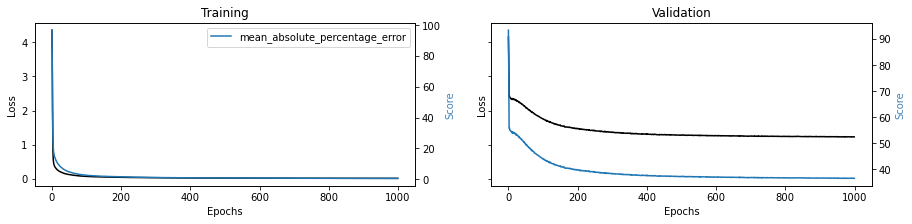

In [284]:
# train
training = model.fit(x=[train["user"], train["product"]], y=train["overall"], 
                     epochs=1000, batch_size=128, shuffle=True, verbose=1, validation_split=0.3)
model = training.model
utils_plot_keras_training(training)

In [285]:
# Test
test['yhat'] = model.predict([test["user"], test["product"]])
np.mean((test['overall']-test['yhat'])**2)

1.9072311458529423

(<AxesSubplot:>, <AxesSubplot:>)

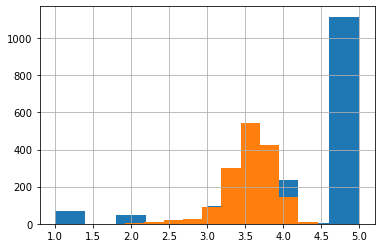

In [286]:
test['overall'].hist(), test['yhat'].hist()

# Adding context and product features #

Fuld NN her.

In [307]:
#dfs['vote']=dfs['vote'].fillna(0)
dfs.loc[dfs['verified']=='SAND', 'verified']=1
dfs.loc[dfs['verified']=='FALSK', 'verified']=0

In [314]:
counts=dfs.groupby('bottomcat').count()['overall']
counts=counts[counts>40]

In [317]:
dfs['bottomcat_other']=[i if i in counts else 'other' for i in dfs['bottomcat']]

In [321]:
df4=pd.read_csv('merged_df.csv')

In [328]:
merged=dfs.join(df4['unixReviewTime'])

In [329]:
#df4['marker']=df4.index
#dfs['marker']=dfs.index
#dfs.merge(df4['unixReviewTime'], how="left", left_on="marker", right_index=True)

In [359]:
df=merged[['unixReviewTime', 'asin', 'reviewerID']]
df.columns=['time', 'product', 'user']
df2=merged[['unixReviewTime', 'price', 'vote', 'bottomcat_other', 'asin', 'reviewerID']]
df2.columns=['time', 'price', 'vote', 'cat', 'product', 'user']

In [362]:
#train.merge(df['time'], how="left", left_on="product", right_index=True)
trainf=train.merge(df2[['time', 'price', 'vote', 'cat', 'product', 'user']], how = 'inner', on = ['product', 'user'])
testf=test.merge(df2[['time', 'price', 'vote', 'cat', 'product', 'user']], how = 'inner', on = ['product', 'user'])

In [379]:
embeddings_size = 50
usr, prd = df_cf.shape[0], df_cf.shape[1]
feat = 1 # price, vote
ctx = 2 # time

########################################## COLLABORATIVE FILTERING ###################################################
# Input layer
xusers_in = layers.Input(name="xusers_in", shape=(1,))
xproducts_in = layers.Input(name="xproducts_in", shape=(1,))

# A) Matrix Factorization
## embeddings and reshape
cf_xusers_emb = layers.Embedding(name="cf_xusers_emb", input_dim=usr, output_dim=embeddings_size)(xusers_in)
cf_xusers = layers.Reshape(name='cf_xusers', target_shape=(embeddings_size,))(cf_xusers_emb)
## embeddings and reshape
cf_xproducts_emb = layers.Embedding(name="cf_xproducts_emb", input_dim=prd, output_dim=embeddings_size)(xproducts_in)
cf_xproducts = layers.Reshape(name='cf_xproducts', target_shape=(embeddings_size,))(cf_xproducts_emb)
## product
cf_xx = layers.Dot(name='cf_xx', normalize=True, axes=1)([cf_xusers, cf_xproducts])

# B) Neural Network
## embeddings and reshape
nn_xusers_emb = layers.Embedding(name="nn_xusers_emb", input_dim=usr, output_dim=embeddings_size)(xusers_in)
nn_xusers = layers.Reshape(name='nn_xusers', target_shape=(embeddings_size,))(nn_xusers_emb)
## embeddings and reshape
nn_xproducts_emb = layers.Embedding(name="nn_xproducts_emb", input_dim=prd, output_dim=embeddings_size)(xproducts_in)
nn_xproducts = layers.Reshape(name='nn_xproducts', target_shape=(embeddings_size,))(nn_xproducts_emb)
## concat and dense
nn_xx = layers.Concatenate()([nn_xusers, nn_xproducts])
nn_xx = layers.Dense(name="nn_xx", units=int(embeddings_size/2), activation='relu')(nn_xx)

########################################## CONTENT BASED ###################################################
# Product Features
features_in = layers.Input(name="features_in", shape=(feat,))
features_x = layers.Dense(name="features_x", units=feat, activation='relu')(features_in)

########################################## KNOWLEDGE BASED #################################################
# Context
contexts_in = layers.Input(name="contexts_in", shape=(ctx,))
context_x = layers.Dense(name="context_x", units=ctx, activation='relu')(contexts_in)

########################################## OUTPUT ###################################################
# Merge all
y_out = layers.Concatenate()([cf_xx, nn_xx, features_x, context_x])
y_out = layers.Dense(name="y_out", units=1, activation='linear')(y_out)

# Compile
model = models.Model(inputs=[xusers_in,xproducts_in, features_in, contexts_in], outputs=y_out, name="Hybrid_Model")
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mean_absolute_percentage_error'])
#model.summary()

In [386]:
trainf['price']=(preprocessing.MinMaxScaler(feature_range=(0.1,1)).fit_transform(trainf[['price']].values))
trainf['time']=(preprocessing.MinMaxScaler(feature_range=(0.1,1)).fit_transform(trainf[['time']].values))
trainf['vote']=(preprocessing.MinMaxScaler(feature_range=(0.1,1)).fit_transform(trainf[['vote']].values))
testf['price']=(preprocessing.MinMaxScaler(feature_range=(0.1,1)).fit_transform(testf[['price']].values))
testf['time']=(preprocessing.MinMaxScaler(feature_range=(0.1,1)).fit_transform(testf[['time']].values))
testf['vote']=(preprocessing.MinMaxScaler(feature_range=(0.1,1)).fit_transform(testf[['vote']].values))

In [373]:
trainf['price']=trainf['price'].fillna(trainf['price'].mean())

In [377]:
trainf.dtypes

user         int64
product      int64
overall    float64
time       float64
price      float64
vote       float64
cat         object
dtype: object

In [383]:
# train
training = model.fit(x=[trainf["user"], trainf["product"], trainf['time'], trainf[['price', 'vote']]], y=trainf["overall"], 
                     epochs=1000, batch_size=128, shuffle=True, verbose=1, validation_split=0.3)

Epoch 1/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.0172 - mean_absolute_percentage_error: 0.4865 - val_loss: 1.1934 - val_mean_absolute_percentage_error: 36.4426
Epoch 2/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0170 - mean_absolute_percentage_error: 0.4850 - val_loss: 1.1960 - val_mean_absolute_percentage_error: 36.4677
Epoch 3/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0166 - mean_absolute_percentage_error: 0.4780 - val_loss: 1.1923 - val_mean_absolute_percentage_error: 36.4290
Epoch 4/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0167 - mean_absolute_percentage_error: 0.4774 - val_loss: 1.1974 - val_mean_absolute_percentage_error: 36.4888
Epoch 5/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0166 - mean_absolute_percentage_error: 0.4716 - val_loss: 1.1925 - val_mean_absolute_percentage_error: 36.4305
Epoch 6/10000
41/41 [==============================] - 0s 3m

41/41 [==============================] - 0s 3ms/step - loss: 0.0166 - mean_absolute_percentage_error: 0.4765 - val_loss: 1.1951 - val_mean_absolute_percentage_error: 36.4497
Epoch 45/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0167 - mean_absolute_percentage_error: 0.4753 - val_loss: 1.1910 - val_mean_absolute_percentage_error: 36.4022
Epoch 46/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0168 - mean_absolute_percentage_error: 0.4801 - val_loss: 1.1951 - val_mean_absolute_percentage_error: 36.4560
Epoch 47/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0160 - mean_absolute_percentage_error: 0.4606 - val_loss: 1.1942 - val_mean_absolute_percentage_error: 36.4434
Epoch 48/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0166 - mean_absolute_percentage_error: 0.4732 - val_loss: 1.1913 - val_mean_absolute_percentage_error: 36.4014
Epoch 49/10000
41/41 [==============================] - 0s 3ms/step - 

41/41 [==============================] - 0s 3ms/step - loss: 0.0159 - mean_absolute_percentage_error: 0.4464 - val_loss: 1.1920 - val_mean_absolute_percentage_error: 36.4185
Epoch 88/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0164 - mean_absolute_percentage_error: 0.4701 - val_loss: 1.1863 - val_mean_absolute_percentage_error: 36.3488
Epoch 89/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0162 - mean_absolute_percentage_error: 0.4596 - val_loss: 1.1926 - val_mean_absolute_percentage_error: 36.4218
Epoch 90/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0165 - mean_absolute_percentage_error: 0.4780 - val_loss: 1.1904 - val_mean_absolute_percentage_error: 36.4073
Epoch 91/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0163 - mean_absolute_percentage_error: 0.4677 - val_loss: 1.1923 - val_mean_absolute_percentage_error: 36.4188
Epoch 92/10000
41/41 [==============================] - 0s 3ms/step - 

41/41 [==============================] - 0s 3ms/step - loss: 0.0159 - mean_absolute_percentage_error: 0.4518 - val_loss: 1.1904 - val_mean_absolute_percentage_error: 36.3972
Epoch 131/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0153 - mean_absolute_percentage_error: 0.4445 - val_loss: 1.1894 - val_mean_absolute_percentage_error: 36.3910
Epoch 132/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0159 - mean_absolute_percentage_error: 0.4469 - val_loss: 1.1873 - val_mean_absolute_percentage_error: 36.3614
Epoch 133/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0161 - mean_absolute_percentage_error: 0.4660 - val_loss: 1.1911 - val_mean_absolute_percentage_error: 36.3990
Epoch 134/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0162 - mean_absolute_percentage_error: 0.4747 - val_loss: 1.1862 - val_mean_absolute_percentage_error: 36.3413
Epoch 135/10000
41/41 [==============================] - 0s 3ms/st

41/41 [==============================] - 0s 3ms/step - loss: 0.0157 - mean_absolute_percentage_error: 0.4461 - val_loss: 1.1856 - val_mean_absolute_percentage_error: 36.3403
Epoch 174/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0158 - mean_absolute_percentage_error: 0.4509 - val_loss: 1.1873 - val_mean_absolute_percentage_error: 36.3511
Epoch 175/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0152 - mean_absolute_percentage_error: 0.4427 - val_loss: 1.1864 - val_mean_absolute_percentage_error: 36.3520
Epoch 176/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0157 - mean_absolute_percentage_error: 0.4499 - val_loss: 1.1849 - val_mean_absolute_percentage_error: 36.3305
Epoch 177/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0158 - mean_absolute_percentage_error: 0.4454 - val_loss: 1.1889 - val_mean_absolute_percentage_error: 36.3688
Epoch 178/10000
41/41 [==============================] - 0s 3ms/st

41/41 [==============================] - 0s 3ms/step - loss: 0.0159 - mean_absolute_percentage_error: 0.4546 - val_loss: 1.1896 - val_mean_absolute_percentage_error: 36.3840
Epoch 217/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0153 - mean_absolute_percentage_error: 0.4379 - val_loss: 1.1849 - val_mean_absolute_percentage_error: 36.3256
Epoch 218/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0161 - mean_absolute_percentage_error: 0.4460 - val_loss: 1.1864 - val_mean_absolute_percentage_error: 36.3438
Epoch 219/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0156 - mean_absolute_percentage_error: 0.4434 - val_loss: 1.1839 - val_mean_absolute_percentage_error: 36.3155
Epoch 220/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0156 - mean_absolute_percentage_error: 0.4415 - val_loss: 1.1839 - val_mean_absolute_percentage_error: 36.3143
Epoch 221/10000
41/41 [==============================] - 0s 3ms/st

41/41 [==============================] - 0s 3ms/step - loss: 0.0151 - mean_absolute_percentage_error: 0.4455 - val_loss: 1.1830 - val_mean_absolute_percentage_error: 36.2971
Epoch 260/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0153 - mean_absolute_percentage_error: 0.4366 - val_loss: 1.1843 - val_mean_absolute_percentage_error: 36.3093
Epoch 261/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0149 - mean_absolute_percentage_error: 0.4339 - val_loss: 1.1903 - val_mean_absolute_percentage_error: 36.3892
Epoch 262/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0152 - mean_absolute_percentage_error: 0.4326 - val_loss: 1.1862 - val_mean_absolute_percentage_error: 36.3381
Epoch 263/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0154 - mean_absolute_percentage_error: 0.4419 - val_loss: 1.1823 - val_mean_absolute_percentage_error: 36.2900
Epoch 264/10000
41/41 [==============================] - 0s 3ms/st

41/41 [==============================] - 0s 3ms/step - loss: 0.0155 - mean_absolute_percentage_error: 0.4528 - val_loss: 1.1866 - val_mean_absolute_percentage_error: 36.3361
Epoch 303/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0151 - mean_absolute_percentage_error: 0.4355 - val_loss: 1.1812 - val_mean_absolute_percentage_error: 36.2816
Epoch 304/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0147 - mean_absolute_percentage_error: 0.4259 - val_loss: 1.1834 - val_mean_absolute_percentage_error: 36.3025
Epoch 305/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0148 - mean_absolute_percentage_error: 0.4248 - val_loss: 1.1791 - val_mean_absolute_percentage_error: 36.2537
Epoch 306/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0153 - mean_absolute_percentage_error: 0.4457 - val_loss: 1.1860 - val_mean_absolute_percentage_error: 36.3296
Epoch 307/10000
41/41 [==============================] - 0s 3ms/st

41/41 [==============================] - 0s 3ms/step - loss: 0.0143 - mean_absolute_percentage_error: 0.4095 - val_loss: 1.1864 - val_mean_absolute_percentage_error: 36.3401
Epoch 346/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0147 - mean_absolute_percentage_error: 0.4266 - val_loss: 1.1822 - val_mean_absolute_percentage_error: 36.2898
Epoch 347/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0153 - mean_absolute_percentage_error: 0.4342 - val_loss: 1.1835 - val_mean_absolute_percentage_error: 36.3037
Epoch 348/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0152 - mean_absolute_percentage_error: 0.4373 - val_loss: 1.1809 - val_mean_absolute_percentage_error: 36.2740
Epoch 349/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0150 - mean_absolute_percentage_error: 0.4262 - val_loss: 1.1834 - val_mean_absolute_percentage_error: 36.3036
Epoch 350/10000
41/41 [==============================] - 0s 3ms/st

41/41 [==============================] - 0s 3ms/step - loss: 0.0153 - mean_absolute_percentage_error: 0.4402 - val_loss: 1.1861 - val_mean_absolute_percentage_error: 36.3358
Epoch 389/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0145 - mean_absolute_percentage_error: 0.4125 - val_loss: 1.1845 - val_mean_absolute_percentage_error: 36.3156
Epoch 390/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0148 - mean_absolute_percentage_error: 0.4375 - val_loss: 1.1831 - val_mean_absolute_percentage_error: 36.2948
Epoch 391/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0141 - mean_absolute_percentage_error: 0.4019 - val_loss: 1.1815 - val_mean_absolute_percentage_error: 36.2712
Epoch 392/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0143 - mean_absolute_percentage_error: 0.4122 - val_loss: 1.1875 - val_mean_absolute_percentage_error: 36.3517
Epoch 393/10000
41/41 [==============================] - 0s 3ms/st

41/41 [==============================] - 0s 3ms/step - loss: 0.0144 - mean_absolute_percentage_error: 0.4181 - val_loss: 1.1807 - val_mean_absolute_percentage_error: 36.2694
Epoch 432/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0148 - mean_absolute_percentage_error: 0.4236 - val_loss: 1.1802 - val_mean_absolute_percentage_error: 36.2706
Epoch 433/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0147 - mean_absolute_percentage_error: 0.4226 - val_loss: 1.1813 - val_mean_absolute_percentage_error: 36.2780
Epoch 434/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0137 - mean_absolute_percentage_error: 0.3932 - val_loss: 1.1827 - val_mean_absolute_percentage_error: 36.2931
Epoch 435/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0142 - mean_absolute_percentage_error: 0.4106 - val_loss: 1.1809 - val_mean_absolute_percentage_error: 36.2705
Epoch 436/10000
41/41 [==============================] - 0s 3ms/st

41/41 [==============================] - 0s 3ms/step - loss: 0.0138 - mean_absolute_percentage_error: 0.3969 - val_loss: 1.1799 - val_mean_absolute_percentage_error: 36.2637
Epoch 475/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0142 - mean_absolute_percentage_error: 0.4113 - val_loss: 1.1814 - val_mean_absolute_percentage_error: 36.2766
Epoch 476/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0144 - mean_absolute_percentage_error: 0.4136 - val_loss: 1.1798 - val_mean_absolute_percentage_error: 36.2596
Epoch 477/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0145 - mean_absolute_percentage_error: 0.4152 - val_loss: 1.1803 - val_mean_absolute_percentage_error: 36.2640
Epoch 478/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0143 - mean_absolute_percentage_error: 0.4157 - val_loss: 1.1801 - val_mean_absolute_percentage_error: 36.2628
Epoch 479/10000
41/41 [==============================] - 0s 4ms/st

41/41 [==============================] - 0s 3ms/step - loss: 0.0144 - mean_absolute_percentage_error: 0.4162 - val_loss: 1.1818 - val_mean_absolute_percentage_error: 36.2824
Epoch 518/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0139 - mean_absolute_percentage_error: 0.4044 - val_loss: 1.1791 - val_mean_absolute_percentage_error: 36.2464
Epoch 519/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0135 - mean_absolute_percentage_error: 0.3970 - val_loss: 1.1778 - val_mean_absolute_percentage_error: 36.2320
Epoch 520/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0145 - mean_absolute_percentage_error: 0.4117 - val_loss: 1.1813 - val_mean_absolute_percentage_error: 36.2769
Epoch 521/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0147 - mean_absolute_percentage_error: 0.4283 - val_loss: 1.1786 - val_mean_absolute_percentage_error: 36.2452
Epoch 522/10000
41/41 [==============================] - 0s 3ms/st

41/41 [==============================] - 0s 3ms/step - loss: 0.0140 - mean_absolute_percentage_error: 0.4066 - val_loss: 1.1790 - val_mean_absolute_percentage_error: 36.2506
Epoch 561/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0136 - mean_absolute_percentage_error: 0.3894 - val_loss: 1.1792 - val_mean_absolute_percentage_error: 36.2479
Epoch 562/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0134 - mean_absolute_percentage_error: 0.3877 - val_loss: 1.1785 - val_mean_absolute_percentage_error: 36.2419
Epoch 563/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0133 - mean_absolute_percentage_error: 0.3874 - val_loss: 1.1809 - val_mean_absolute_percentage_error: 36.2765
Epoch 564/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0135 - mean_absolute_percentage_error: 0.3931 - val_loss: 1.1806 - val_mean_absolute_percentage_error: 36.2574
Epoch 565/10000
41/41 [==============================] - 0s 3ms/st

41/41 [==============================] - 0s 3ms/step - loss: 0.0134 - mean_absolute_percentage_error: 0.3866 - val_loss: 1.1769 - val_mean_absolute_percentage_error: 36.2163
Epoch 604/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0132 - mean_absolute_percentage_error: 0.3917 - val_loss: 1.1796 - val_mean_absolute_percentage_error: 36.2492
Epoch 605/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0136 - mean_absolute_percentage_error: 0.4006 - val_loss: 1.1806 - val_mean_absolute_percentage_error: 36.2615
Epoch 606/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.0131 - mean_absolute_percentage_error: 0.3803 - val_loss: 1.1759 - val_mean_absolute_percentage_error: 36.1980
Epoch 607/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.0136 - mean_absolute_percentage_error: 0.3871 - val_loss: 1.1791 - val_mean_absolute_percentage_error: 36.2428
Epoch 608/10000
41/41 [==============================] - 0s 4ms/st

41/41 [==============================] - 0s 4ms/step - loss: 0.0131 - mean_absolute_percentage_error: 0.3819 - val_loss: 1.1750 - val_mean_absolute_percentage_error: 36.1875
Epoch 647/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0135 - mean_absolute_percentage_error: 0.3890 - val_loss: 1.1776 - val_mean_absolute_percentage_error: 36.2176
Epoch 648/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.0132 - mean_absolute_percentage_error: 0.3848 - val_loss: 1.1774 - val_mean_absolute_percentage_error: 36.2282
Epoch 649/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0137 - mean_absolute_percentage_error: 0.4018 - val_loss: 1.1776 - val_mean_absolute_percentage_error: 36.2156
Epoch 650/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.0133 - mean_absolute_percentage_error: 0.3852 - val_loss: 1.1811 - val_mean_absolute_percentage_error: 36.2696
Epoch 651/10000
41/41 [==============================] - 0s 4ms/st

41/41 [==============================] - 0s 3ms/step - loss: 0.0131 - mean_absolute_percentage_error: 0.3838 - val_loss: 1.1781 - val_mean_absolute_percentage_error: 36.2237
Epoch 690/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0134 - mean_absolute_percentage_error: 0.3911 - val_loss: 1.1786 - val_mean_absolute_percentage_error: 36.2224
Epoch 691/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0131 - mean_absolute_percentage_error: 0.3749 - val_loss: 1.1770 - val_mean_absolute_percentage_error: 36.2049
Epoch 692/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0124 - mean_absolute_percentage_error: 0.3721 - val_loss: 1.1765 - val_mean_absolute_percentage_error: 36.1916
Epoch 693/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0132 - mean_absolute_percentage_error: 0.3807 - val_loss: 1.1747 - val_mean_absolute_percentage_error: 36.1766
Epoch 694/10000
41/41 [==============================] - 0s 3ms/st

41/41 [==============================] - 0s 3ms/step - loss: 0.0128 - mean_absolute_percentage_error: 0.3798 - val_loss: 1.1749 - val_mean_absolute_percentage_error: 36.1789
Epoch 733/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0129 - mean_absolute_percentage_error: 0.3781 - val_loss: 1.1773 - val_mean_absolute_percentage_error: 36.2129
Epoch 734/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0128 - mean_absolute_percentage_error: 0.3756 - val_loss: 1.1785 - val_mean_absolute_percentage_error: 36.2176
Epoch 735/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0127 - mean_absolute_percentage_error: 0.3711 - val_loss: 1.1785 - val_mean_absolute_percentage_error: 36.2156
Epoch 736/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0131 - mean_absolute_percentage_error: 0.3712 - val_loss: 1.1783 - val_mean_absolute_percentage_error: 36.2205
Epoch 737/10000
41/41 [==============================] - 0s 3ms/st

41/41 [==============================] - 0s 3ms/step - loss: 0.0137 - mean_absolute_percentage_error: 0.3980 - val_loss: 1.1790 - val_mean_absolute_percentage_error: 36.2348
Epoch 776/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0133 - mean_absolute_percentage_error: 0.3858 - val_loss: 1.1781 - val_mean_absolute_percentage_error: 36.2198
Epoch 777/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0136 - mean_absolute_percentage_error: 0.3929 - val_loss: 1.1758 - val_mean_absolute_percentage_error: 36.1915
Epoch 778/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0128 - mean_absolute_percentage_error: 0.3723 - val_loss: 1.1730 - val_mean_absolute_percentage_error: 36.1576
Epoch 779/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0134 - mean_absolute_percentage_error: 0.3852 - val_loss: 1.1777 - val_mean_absolute_percentage_error: 36.2178
Epoch 780/10000
41/41 [==============================] - 0s 3ms/st

41/41 [==============================] - 0s 3ms/step - loss: 0.0128 - mean_absolute_percentage_error: 0.3747 - val_loss: 1.1756 - val_mean_absolute_percentage_error: 36.1920
Epoch 819/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0125 - mean_absolute_percentage_error: 0.3610 - val_loss: 1.1752 - val_mean_absolute_percentage_error: 36.1862
Epoch 820/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0130 - mean_absolute_percentage_error: 0.3844 - val_loss: 1.1743 - val_mean_absolute_percentage_error: 36.1733
Epoch 821/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0132 - mean_absolute_percentage_error: 0.3892 - val_loss: 1.1771 - val_mean_absolute_percentage_error: 36.2097
Epoch 822/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0127 - mean_absolute_percentage_error: 0.3683 - val_loss: 1.1764 - val_mean_absolute_percentage_error: 36.2057
Epoch 823/10000
41/41 [==============================] - 0s 3ms/st

41/41 [==============================] - 0s 3ms/step - loss: 0.0128 - mean_absolute_percentage_error: 0.3693 - val_loss: 1.1737 - val_mean_absolute_percentage_error: 36.1715
Epoch 862/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0128 - mean_absolute_percentage_error: 0.3790 - val_loss: 1.1733 - val_mean_absolute_percentage_error: 36.1660
Epoch 863/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0130 - mean_absolute_percentage_error: 0.3738 - val_loss: 1.1753 - val_mean_absolute_percentage_error: 36.1882
Epoch 864/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0129 - mean_absolute_percentage_error: 0.3777 - val_loss: 1.1741 - val_mean_absolute_percentage_error: 36.1740
Epoch 865/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0128 - mean_absolute_percentage_error: 0.3713 - val_loss: 1.1750 - val_mean_absolute_percentage_error: 36.1767
Epoch 866/10000
41/41 [==============================] - 0s 3ms/st

41/41 [==============================] - 0s 3ms/step - loss: 0.0124 - mean_absolute_percentage_error: 0.3617 - val_loss: 1.1748 - val_mean_absolute_percentage_error: 36.1836
Epoch 905/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0123 - mean_absolute_percentage_error: 0.3602 - val_loss: 1.1785 - val_mean_absolute_percentage_error: 36.2244
Epoch 906/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0123 - mean_absolute_percentage_error: 0.3580 - val_loss: 1.1743 - val_mean_absolute_percentage_error: 36.1762
Epoch 907/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0127 - mean_absolute_percentage_error: 0.3758 - val_loss: 1.1790 - val_mean_absolute_percentage_error: 36.2395
Epoch 908/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0126 - mean_absolute_percentage_error: 0.3566 - val_loss: 1.1754 - val_mean_absolute_percentage_error: 36.1853
Epoch 909/10000
41/41 [==============================] - 0s 3ms/st

41/41 [==============================] - 0s 3ms/step - loss: 0.0124 - mean_absolute_percentage_error: 0.3577 - val_loss: 1.1731 - val_mean_absolute_percentage_error: 36.1595
Epoch 948/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0131 - mean_absolute_percentage_error: 0.3782 - val_loss: 1.1744 - val_mean_absolute_percentage_error: 36.1735
Epoch 949/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0131 - mean_absolute_percentage_error: 0.3725 - val_loss: 1.1761 - val_mean_absolute_percentage_error: 36.2100
Epoch 950/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0126 - mean_absolute_percentage_error: 0.3665 - val_loss: 1.1712 - val_mean_absolute_percentage_error: 36.1355
Epoch 951/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0123 - mean_absolute_percentage_error: 0.3585 - val_loss: 1.1794 - val_mean_absolute_percentage_error: 36.2424
Epoch 952/10000
41/41 [==============================] - 0s 3ms/st

41/41 [==============================] - 0s 3ms/step - loss: 0.0121 - mean_absolute_percentage_error: 0.3557 - val_loss: 1.1734 - val_mean_absolute_percentage_error: 36.1605
Epoch 991/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0124 - mean_absolute_percentage_error: 0.3609 - val_loss: 1.1710 - val_mean_absolute_percentage_error: 36.1332
Epoch 992/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0126 - mean_absolute_percentage_error: 0.3676 - val_loss: 1.1749 - val_mean_absolute_percentage_error: 36.1692
Epoch 993/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0123 - mean_absolute_percentage_error: 0.3525 - val_loss: 1.1743 - val_mean_absolute_percentage_error: 36.1769
Epoch 994/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0117 - mean_absolute_percentage_error: 0.3400 - val_loss: 1.1748 - val_mean_absolute_percentage_error: 36.1732
Epoch 995/10000
41/41 [==============================] - 0s 3ms/st

41/41 [==============================] - 0s 3ms/step - loss: 0.0118 - mean_absolute_percentage_error: 0.3464 - val_loss: 1.1730 - val_mean_absolute_percentage_error: 36.1547
Epoch 1034/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0116 - mean_absolute_percentage_error: 0.3403 - val_loss: 1.1730 - val_mean_absolute_percentage_error: 36.1468
Epoch 1035/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0121 - mean_absolute_percentage_error: 0.3609 - val_loss: 1.1751 - val_mean_absolute_percentage_error: 36.1862
Epoch 1036/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0120 - mean_absolute_percentage_error: 0.3480 - val_loss: 1.1720 - val_mean_absolute_percentage_error: 36.1434
Epoch 1037/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0121 - mean_absolute_percentage_error: 0.3544 - val_loss: 1.1721 - val_mean_absolute_percentage_error: 36.1423
Epoch 1038/10000
41/41 [==============================] - 0s 3

Epoch 1076/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0118 - mean_absolute_percentage_error: 0.3441 - val_loss: 1.1710 - val_mean_absolute_percentage_error: 36.1336
Epoch 1077/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0121 - mean_absolute_percentage_error: 0.3511 - val_loss: 1.1775 - val_mean_absolute_percentage_error: 36.2242
Epoch 1078/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0124 - mean_absolute_percentage_error: 0.3671 - val_loss: 1.1752 - val_mean_absolute_percentage_error: 36.1909
Epoch 1079/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0127 - mean_absolute_percentage_error: 0.3654 - val_loss: 1.1712 - val_mean_absolute_percentage_error: 36.1484
Epoch 1080/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0119 - mean_absolute_percentage_error: 0.3476 - val_loss: 1.1735 - val_mean_absolute_percentage_error: 36.1711
Epoch 1081/10000
41/41 [=====================

Epoch 1119/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0120 - mean_absolute_percentage_error: 0.3530 - val_loss: 1.1735 - val_mean_absolute_percentage_error: 36.1664
Epoch 1120/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0119 - mean_absolute_percentage_error: 0.3495 - val_loss: 1.1720 - val_mean_absolute_percentage_error: 36.1476
Epoch 1121/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0121 - mean_absolute_percentage_error: 0.3557 - val_loss: 1.1717 - val_mean_absolute_percentage_error: 36.1446
Epoch 1122/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0118 - mean_absolute_percentage_error: 0.3479 - val_loss: 1.1738 - val_mean_absolute_percentage_error: 36.1704
Epoch 1123/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0120 - mean_absolute_percentage_error: 0.3454 - val_loss: 1.1714 - val_mean_absolute_percentage_error: 36.1416
Epoch 1124/10000
41/41 [=====================

Epoch 1162/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0118 - mean_absolute_percentage_error: 0.3416 - val_loss: 1.1746 - val_mean_absolute_percentage_error: 36.1739
Epoch 1163/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0119 - mean_absolute_percentage_error: 0.3433 - val_loss: 1.1732 - val_mean_absolute_percentage_error: 36.1635
Epoch 1164/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0120 - mean_absolute_percentage_error: 0.3500 - val_loss: 1.1760 - val_mean_absolute_percentage_error: 36.1851
Epoch 1165/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0120 - mean_absolute_percentage_error: 0.3444 - val_loss: 1.1722 - val_mean_absolute_percentage_error: 36.1424
Epoch 1166/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0115 - mean_absolute_percentage_error: 0.3345 - val_loss: 1.1724 - val_mean_absolute_percentage_error: 36.1359
Epoch 1167/10000
41/41 [=====================

Epoch 1205/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0118 - mean_absolute_percentage_error: 0.3391 - val_loss: 1.1745 - val_mean_absolute_percentage_error: 36.1714
Epoch 1206/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0116 - mean_absolute_percentage_error: 0.3398 - val_loss: 1.1692 - val_mean_absolute_percentage_error: 36.1065
Epoch 1207/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0117 - mean_absolute_percentage_error: 0.3396 - val_loss: 1.1702 - val_mean_absolute_percentage_error: 36.1205
Epoch 1208/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0114 - mean_absolute_percentage_error: 0.3283 - val_loss: 1.1718 - val_mean_absolute_percentage_error: 36.1338
Epoch 1209/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0114 - mean_absolute_percentage_error: 0.3359 - val_loss: 1.1729 - val_mean_absolute_percentage_error: 36.1551
Epoch 1210/10000
41/41 [=====================

Epoch 1248/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0113 - mean_absolute_percentage_error: 0.3286 - val_loss: 1.1710 - val_mean_absolute_percentage_error: 36.1194
Epoch 1249/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0119 - mean_absolute_percentage_error: 0.3518 - val_loss: 1.1728 - val_mean_absolute_percentage_error: 36.1529
Epoch 1250/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0118 - mean_absolute_percentage_error: 0.3425 - val_loss: 1.1708 - val_mean_absolute_percentage_error: 36.1299
Epoch 1251/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0119 - mean_absolute_percentage_error: 0.3448 - val_loss: 1.1699 - val_mean_absolute_percentage_error: 36.1147
Epoch 1252/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0116 - mean_absolute_percentage_error: 0.3369 - val_loss: 1.1721 - val_mean_absolute_percentage_error: 36.1365
Epoch 1253/10000
41/41 [=====================

Epoch 1291/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0113 - mean_absolute_percentage_error: 0.3353 - val_loss: 1.1718 - val_mean_absolute_percentage_error: 36.1397
Epoch 1292/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0113 - mean_absolute_percentage_error: 0.3330 - val_loss: 1.1717 - val_mean_absolute_percentage_error: 36.1283
Epoch 1293/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0120 - mean_absolute_percentage_error: 0.3524 - val_loss: 1.1743 - val_mean_absolute_percentage_error: 36.1629
Epoch 1294/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0116 - mean_absolute_percentage_error: 0.3342 - val_loss: 1.1716 - val_mean_absolute_percentage_error: 36.1291
Epoch 1295/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0116 - mean_absolute_percentage_error: 0.3437 - val_loss: 1.1717 - val_mean_absolute_percentage_error: 36.1367
Epoch 1296/10000
41/41 [=====================

Epoch 1334/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0111 - mean_absolute_percentage_error: 0.3285 - val_loss: 1.1692 - val_mean_absolute_percentage_error: 36.1074
Epoch 1335/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0117 - mean_absolute_percentage_error: 0.3416 - val_loss: 1.1735 - val_mean_absolute_percentage_error: 36.1561
Epoch 1336/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0113 - mean_absolute_percentage_error: 0.3255 - val_loss: 1.1732 - val_mean_absolute_percentage_error: 36.1594
Epoch 1337/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0114 - mean_absolute_percentage_error: 0.3379 - val_loss: 1.1721 - val_mean_absolute_percentage_error: 36.1414
Epoch 1338/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0111 - mean_absolute_percentage_error: 0.3249 - val_loss: 1.1702 - val_mean_absolute_percentage_error: 36.1220
Epoch 1339/10000
41/41 [=====================

Epoch 1377/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0111 - mean_absolute_percentage_error: 0.3198 - val_loss: 1.1725 - val_mean_absolute_percentage_error: 36.1435
Epoch 1378/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0109 - mean_absolute_percentage_error: 0.3202 - val_loss: 1.1710 - val_mean_absolute_percentage_error: 36.1272
Epoch 1379/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0111 - mean_absolute_percentage_error: 0.3329 - val_loss: 1.1704 - val_mean_absolute_percentage_error: 36.1213
Epoch 1380/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0112 - mean_absolute_percentage_error: 0.3309 - val_loss: 1.1722 - val_mean_absolute_percentage_error: 36.1376
Epoch 1381/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0114 - mean_absolute_percentage_error: 0.3387 - val_loss: 1.1717 - val_mean_absolute_percentage_error: 36.1355
Epoch 1382/10000
41/41 [=====================

Epoch 1420/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0109 - mean_absolute_percentage_error: 0.3173 - val_loss: 1.1720 - val_mean_absolute_percentage_error: 36.1311
Epoch 1421/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0107 - mean_absolute_percentage_error: 0.3190 - val_loss: 1.1695 - val_mean_absolute_percentage_error: 36.1075
Epoch 1422/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0112 - mean_absolute_percentage_error: 0.3287 - val_loss: 1.1714 - val_mean_absolute_percentage_error: 36.1281
Epoch 1423/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0112 - mean_absolute_percentage_error: 0.3370 - val_loss: 1.1703 - val_mean_absolute_percentage_error: 36.1130
Epoch 1424/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0114 - mean_absolute_percentage_error: 0.3374 - val_loss: 1.1705 - val_mean_absolute_percentage_error: 36.1160
Epoch 1425/10000
41/41 [=====================

Epoch 1463/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0110 - mean_absolute_percentage_error: 0.3218 - val_loss: 1.1712 - val_mean_absolute_percentage_error: 36.1294
Epoch 1464/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0110 - mean_absolute_percentage_error: 0.3245 - val_loss: 1.1700 - val_mean_absolute_percentage_error: 36.1132
Epoch 1465/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0108 - mean_absolute_percentage_error: 0.3166 - val_loss: 1.1658 - val_mean_absolute_percentage_error: 36.0606
Epoch 1466/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0116 - mean_absolute_percentage_error: 0.3378 - val_loss: 1.1702 - val_mean_absolute_percentage_error: 36.1121
Epoch 1467/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0108 - mean_absolute_percentage_error: 0.3120 - val_loss: 1.1686 - val_mean_absolute_percentage_error: 36.1013
Epoch 1468/10000
41/41 [=====================

Epoch 1506/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0108 - mean_absolute_percentage_error: 0.3096 - val_loss: 1.1704 - val_mean_absolute_percentage_error: 36.1173
Epoch 1507/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0111 - mean_absolute_percentage_error: 0.3260 - val_loss: 1.1736 - val_mean_absolute_percentage_error: 36.1542
Epoch 1508/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0113 - mean_absolute_percentage_error: 0.3286 - val_loss: 1.1701 - val_mean_absolute_percentage_error: 36.1200
Epoch 1509/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0108 - mean_absolute_percentage_error: 0.3157 - val_loss: 1.1682 - val_mean_absolute_percentage_error: 36.0867
Epoch 1510/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0116 - mean_absolute_percentage_error: 0.3343 - val_loss: 1.1725 - val_mean_absolute_percentage_error: 36.1393
Epoch 1511/10000
41/41 [=====================

Epoch 1549/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0106 - mean_absolute_percentage_error: 0.3110 - val_loss: 1.1711 - val_mean_absolute_percentage_error: 36.1321
Epoch 1550/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0110 - mean_absolute_percentage_error: 0.3242 - val_loss: 1.1707 - val_mean_absolute_percentage_error: 36.1152
Epoch 1551/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0103 - mean_absolute_percentage_error: 0.3000 - val_loss: 1.1723 - val_mean_absolute_percentage_error: 36.1396
Epoch 1552/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0112 - mean_absolute_percentage_error: 0.3342 - val_loss: 1.1688 - val_mean_absolute_percentage_error: 36.0961
Epoch 1553/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0107 - mean_absolute_percentage_error: 0.3163 - val_loss: 1.1707 - val_mean_absolute_percentage_error: 36.1206
Epoch 1554/10000
41/41 [=====================

Epoch 1592/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0106 - mean_absolute_percentage_error: 0.3125 - val_loss: 1.1700 - val_mean_absolute_percentage_error: 36.1208
Epoch 1593/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0108 - mean_absolute_percentage_error: 0.3167 - val_loss: 1.1695 - val_mean_absolute_percentage_error: 36.1069
Epoch 1594/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.0106 - mean_absolute_percentage_error: 0.3128 - val_loss: 1.1704 - val_mean_absolute_percentage_error: 36.1253
Epoch 1595/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0109 - mean_absolute_percentage_error: 0.3192 - val_loss: 1.1702 - val_mean_absolute_percentage_error: 36.1162
Epoch 1596/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0107 - mean_absolute_percentage_error: 0.3165 - val_loss: 1.1706 - val_mean_absolute_percentage_error: 36.1286
Epoch 1597/10000
41/41 [=====================

Epoch 1635/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0107 - mean_absolute_percentage_error: 0.3171 - val_loss: 1.1704 - val_mean_absolute_percentage_error: 36.1137
Epoch 1636/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0105 - mean_absolute_percentage_error: 0.3173 - val_loss: 1.1678 - val_mean_absolute_percentage_error: 36.0862
Epoch 1637/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0109 - mean_absolute_percentage_error: 0.3208 - val_loss: 1.1666 - val_mean_absolute_percentage_error: 36.0657
Epoch 1638/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0110 - mean_absolute_percentage_error: 0.3243 - val_loss: 1.1673 - val_mean_absolute_percentage_error: 36.0780
Epoch 1639/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0110 - mean_absolute_percentage_error: 0.3176 - val_loss: 1.1673 - val_mean_absolute_percentage_error: 36.0765
Epoch 1640/10000
41/41 [=====================

Epoch 1678/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0106 - mean_absolute_percentage_error: 0.3130 - val_loss: 1.1702 - val_mean_absolute_percentage_error: 36.1125
Epoch 1679/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0104 - mean_absolute_percentage_error: 0.3069 - val_loss: 1.1685 - val_mean_absolute_percentage_error: 36.0884
Epoch 1680/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0103 - mean_absolute_percentage_error: 0.3013 - val_loss: 1.1682 - val_mean_absolute_percentage_error: 36.0836
Epoch 1681/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0105 - mean_absolute_percentage_error: 0.3104 - val_loss: 1.1699 - val_mean_absolute_percentage_error: 36.1014
Epoch 1682/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0109 - mean_absolute_percentage_error: 0.3191 - val_loss: 1.1707 - val_mean_absolute_percentage_error: 36.1161
Epoch 1683/10000
41/41 [=====================

Epoch 1721/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0103 - mean_absolute_percentage_error: 0.3047 - val_loss: 1.1726 - val_mean_absolute_percentage_error: 36.1364
Epoch 1722/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0104 - mean_absolute_percentage_error: 0.3039 - val_loss: 1.1708 - val_mean_absolute_percentage_error: 36.1124
Epoch 1723/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0108 - mean_absolute_percentage_error: 0.3148 - val_loss: 1.1733 - val_mean_absolute_percentage_error: 36.1436
Epoch 1724/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0105 - mean_absolute_percentage_error: 0.3072 - val_loss: 1.1687 - val_mean_absolute_percentage_error: 36.0950
Epoch 1725/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0105 - mean_absolute_percentage_error: 0.3043 - val_loss: 1.1702 - val_mean_absolute_percentage_error: 36.1081
Epoch 1726/10000
41/41 [=====================

Epoch 1764/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0110 - mean_absolute_percentage_error: 0.3209 - val_loss: 1.1689 - val_mean_absolute_percentage_error: 36.0979
Epoch 1765/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0105 - mean_absolute_percentage_error: 0.3024 - val_loss: 1.1704 - val_mean_absolute_percentage_error: 36.1107
Epoch 1766/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0106 - mean_absolute_percentage_error: 0.3183 - val_loss: 1.1696 - val_mean_absolute_percentage_error: 36.0996
Epoch 1767/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0105 - mean_absolute_percentage_error: 0.3102 - val_loss: 1.1677 - val_mean_absolute_percentage_error: 36.0784
Epoch 1768/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0103 - mean_absolute_percentage_error: 0.2990 - val_loss: 1.1705 - val_mean_absolute_percentage_error: 36.1185
Epoch 1769/10000
41/41 [=====================

Epoch 1807/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0105 - mean_absolute_percentage_error: 0.3068 - val_loss: 1.1721 - val_mean_absolute_percentage_error: 36.1367
Epoch 1808/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0108 - mean_absolute_percentage_error: 0.3208 - val_loss: 1.1688 - val_mean_absolute_percentage_error: 36.0955
Epoch 1809/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0104 - mean_absolute_percentage_error: 0.3078 - val_loss: 1.1697 - val_mean_absolute_percentage_error: 36.1050
Epoch 1810/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0105 - mean_absolute_percentage_error: 0.3079 - val_loss: 1.1673 - val_mean_absolute_percentage_error: 36.0807
Epoch 1811/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0106 - mean_absolute_percentage_error: 0.3141 - val_loss: 1.1712 - val_mean_absolute_percentage_error: 36.1329
Epoch 1812/10000
41/41 [=====================

Epoch 1850/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0103 - mean_absolute_percentage_error: 0.3022 - val_loss: 1.1695 - val_mean_absolute_percentage_error: 36.1017
Epoch 1851/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0100 - mean_absolute_percentage_error: 0.2863 - val_loss: 1.1695 - val_mean_absolute_percentage_error: 36.1021
Epoch 1852/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0104 - mean_absolute_percentage_error: 0.3086 - val_loss: 1.1696 - val_mean_absolute_percentage_error: 36.0930
Epoch 1853/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0099 - mean_absolute_percentage_error: 0.2888 - val_loss: 1.1702 - val_mean_absolute_percentage_error: 36.1103
Epoch 1854/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0099 - mean_absolute_percentage_error: 0.2955 - val_loss: 1.1687 - val_mean_absolute_percentage_error: 36.0890
Epoch 1855/10000
41/41 [=====================

Epoch 1893/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.0100 - mean_absolute_percentage_error: 0.2989 - val_loss: 1.1685 - val_mean_absolute_percentage_error: 36.0914
Epoch 1894/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.0102 - mean_absolute_percentage_error: 0.2993 - val_loss: 1.1690 - val_mean_absolute_percentage_error: 36.0903
Epoch 1895/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.0102 - mean_absolute_percentage_error: 0.2992 - val_loss: 1.1697 - val_mean_absolute_percentage_error: 36.1101
Epoch 1896/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.0101 - mean_absolute_percentage_error: 0.2964 - val_loss: 1.1690 - val_mean_absolute_percentage_error: 36.0991
Epoch 1897/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0101 - mean_absolute_percentage_error: 0.2992 - val_loss: 1.1710 - val_mean_absolute_percentage_error: 36.1274
Epoch 1898/10000
41/41 [=====================

Epoch 1936/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0104 - mean_absolute_percentage_error: 0.3143 - val_loss: 1.1679 - val_mean_absolute_percentage_error: 36.0759
Epoch 1937/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0101 - mean_absolute_percentage_error: 0.2988 - val_loss: 1.1701 - val_mean_absolute_percentage_error: 36.1098
Epoch 1938/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0106 - mean_absolute_percentage_error: 0.3127 - val_loss: 1.1686 - val_mean_absolute_percentage_error: 36.0907
Epoch 1939/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0101 - mean_absolute_percentage_error: 0.2932 - val_loss: 1.1704 - val_mean_absolute_percentage_error: 36.1136
Epoch 1940/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0097 - mean_absolute_percentage_error: 0.2826 - val_loss: 1.1695 - val_mean_absolute_percentage_error: 36.1043
Epoch 1941/10000
41/41 [=====================

Epoch 1979/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0102 - mean_absolute_percentage_error: 0.3016 - val_loss: 1.1693 - val_mean_absolute_percentage_error: 36.1037
Epoch 1980/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0099 - mean_absolute_percentage_error: 0.2899 - val_loss: 1.1689 - val_mean_absolute_percentage_error: 36.0929
Epoch 1981/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0099 - mean_absolute_percentage_error: 0.2911 - val_loss: 1.1673 - val_mean_absolute_percentage_error: 36.0820
Epoch 1982/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0100 - mean_absolute_percentage_error: 0.2957 - val_loss: 1.1712 - val_mean_absolute_percentage_error: 36.1292
Epoch 1983/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0103 - mean_absolute_percentage_error: 0.3062 - val_loss: 1.1700 - val_mean_absolute_percentage_error: 36.1166
Epoch 1984/10000
41/41 [=====================

Epoch 2022/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0101 - mean_absolute_percentage_error: 0.3017 - val_loss: 1.1705 - val_mean_absolute_percentage_error: 36.1131
Epoch 2023/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0100 - mean_absolute_percentage_error: 0.2962 - val_loss: 1.1686 - val_mean_absolute_percentage_error: 36.0994
Epoch 2024/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0099 - mean_absolute_percentage_error: 0.2924 - val_loss: 1.1683 - val_mean_absolute_percentage_error: 36.0865
Epoch 2025/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0105 - mean_absolute_percentage_error: 0.3127 - val_loss: 1.1697 - val_mean_absolute_percentage_error: 36.1024
Epoch 2026/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0100 - mean_absolute_percentage_error: 0.2927 - val_loss: 1.1698 - val_mean_absolute_percentage_error: 36.1099
Epoch 2027/10000
41/41 [=====================

Epoch 2065/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0100 - mean_absolute_percentage_error: 0.2900 - val_loss: 1.1685 - val_mean_absolute_percentage_error: 36.0882
Epoch 2066/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.0096 - mean_absolute_percentage_error: 0.2880 - val_loss: 1.1675 - val_mean_absolute_percentage_error: 36.0777
Epoch 2067/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.0099 - mean_absolute_percentage_error: 0.2961 - val_loss: 1.1684 - val_mean_absolute_percentage_error: 36.0815
Epoch 2068/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.0098 - mean_absolute_percentage_error: 0.2873 - val_loss: 1.1666 - val_mean_absolute_percentage_error: 36.0736
Epoch 2069/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0101 - mean_absolute_percentage_error: 0.2923 - val_loss: 1.1674 - val_mean_absolute_percentage_error: 36.0721
Epoch 2070/10000
41/41 [=====================

Epoch 2108/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0098 - mean_absolute_percentage_error: 0.2916 - val_loss: 1.1699 - val_mean_absolute_percentage_error: 36.1003
Epoch 2109/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0101 - mean_absolute_percentage_error: 0.3002 - val_loss: 1.1667 - val_mean_absolute_percentage_error: 36.0567
Epoch 2110/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0098 - mean_absolute_percentage_error: 0.2944 - val_loss: 1.1715 - val_mean_absolute_percentage_error: 36.1236
Epoch 2111/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0099 - mean_absolute_percentage_error: 0.2954 - val_loss: 1.1669 - val_mean_absolute_percentage_error: 36.0671
Epoch 2112/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0098 - mean_absolute_percentage_error: 0.2886 - val_loss: 1.1664 - val_mean_absolute_percentage_error: 36.0576
Epoch 2113/10000
41/41 [=====================

Epoch 2151/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0098 - mean_absolute_percentage_error: 0.2937 - val_loss: 1.1709 - val_mean_absolute_percentage_error: 36.1184
Epoch 2152/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0100 - mean_absolute_percentage_error: 0.2989 - val_loss: 1.1718 - val_mean_absolute_percentage_error: 36.1190
Epoch 2153/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0098 - mean_absolute_percentage_error: 0.2858 - val_loss: 1.1692 - val_mean_absolute_percentage_error: 36.0987
Epoch 2154/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0097 - mean_absolute_percentage_error: 0.2914 - val_loss: 1.1692 - val_mean_absolute_percentage_error: 36.0885
Epoch 2155/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0096 - mean_absolute_percentage_error: 0.2890 - val_loss: 1.1687 - val_mean_absolute_percentage_error: 36.0861
Epoch 2156/10000
41/41 [=====================

Epoch 2194/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.0107 - mean_absolute_percentage_error: 0.3169 - val_loss: 1.1704 - val_mean_absolute_percentage_error: 36.1139
Epoch 2195/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.0099 - mean_absolute_percentage_error: 0.2897 - val_loss: 1.1693 - val_mean_absolute_percentage_error: 36.1036
Epoch 2196/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.0098 - mean_absolute_percentage_error: 0.2923 - val_loss: 1.1687 - val_mean_absolute_percentage_error: 36.0937
Epoch 2197/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.0096 - mean_absolute_percentage_error: 0.2831 - val_loss: 1.1689 - val_mean_absolute_percentage_error: 36.0999
Epoch 2198/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.0097 - mean_absolute_percentage_error: 0.2838 - val_loss: 1.1701 - val_mean_absolute_percentage_error: 36.1117
Epoch 2199/10000
41/41 [=====================

Epoch 2237/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0094 - mean_absolute_percentage_error: 0.2773 - val_loss: 1.1683 - val_mean_absolute_percentage_error: 36.0881
Epoch 2238/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0094 - mean_absolute_percentage_error: 0.2756 - val_loss: 1.1687 - val_mean_absolute_percentage_error: 36.1037
Epoch 2239/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0095 - mean_absolute_percentage_error: 0.2835 - val_loss: 1.1672 - val_mean_absolute_percentage_error: 36.0794
Epoch 2240/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0094 - mean_absolute_percentage_error: 0.2825 - val_loss: 1.1691 - val_mean_absolute_percentage_error: 36.1015
Epoch 2241/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0094 - mean_absolute_percentage_error: 0.2816 - val_loss: 1.1692 - val_mean_absolute_percentage_error: 36.1073
Epoch 2242/10000
41/41 [=====================

Epoch 2280/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0095 - mean_absolute_percentage_error: 0.2856 - val_loss: 1.1669 - val_mean_absolute_percentage_error: 36.0770
Epoch 2281/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0097 - mean_absolute_percentage_error: 0.2820 - val_loss: 1.1687 - val_mean_absolute_percentage_error: 36.0943
Epoch 2282/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0095 - mean_absolute_percentage_error: 0.2821 - val_loss: 1.1684 - val_mean_absolute_percentage_error: 36.0927
Epoch 2283/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0097 - mean_absolute_percentage_error: 0.2842 - val_loss: 1.1658 - val_mean_absolute_percentage_error: 36.0599
Epoch 2284/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0101 - mean_absolute_percentage_error: 0.2992 - val_loss: 1.1696 - val_mean_absolute_percentage_error: 36.1064
Epoch 2285/10000
41/41 [=====================

Epoch 2323/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0096 - mean_absolute_percentage_error: 0.2834 - val_loss: 1.1696 - val_mean_absolute_percentage_error: 36.1139
Epoch 2324/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0094 - mean_absolute_percentage_error: 0.2795 - val_loss: 1.1687 - val_mean_absolute_percentage_error: 36.0893
Epoch 2325/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0094 - mean_absolute_percentage_error: 0.2761 - val_loss: 1.1672 - val_mean_absolute_percentage_error: 36.0774
Epoch 2326/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0092 - mean_absolute_percentage_error: 0.2744 - val_loss: 1.1691 - val_mean_absolute_percentage_error: 36.0966
Epoch 2327/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0096 - mean_absolute_percentage_error: 0.2811 - val_loss: 1.1692 - val_mean_absolute_percentage_error: 36.1012
Epoch 2328/10000
41/41 [=====================

Epoch 2366/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0092 - mean_absolute_percentage_error: 0.2727 - val_loss: 1.1686 - val_mean_absolute_percentage_error: 36.0926
Epoch 2367/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0092 - mean_absolute_percentage_error: 0.2714 - val_loss: 1.1688 - val_mean_absolute_percentage_error: 36.0954
Epoch 2368/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0090 - mean_absolute_percentage_error: 0.2654 - val_loss: 1.1682 - val_mean_absolute_percentage_error: 36.0863
Epoch 2369/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0096 - mean_absolute_percentage_error: 0.2801 - val_loss: 1.1673 - val_mean_absolute_percentage_error: 36.0826
Epoch 2370/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0096 - mean_absolute_percentage_error: 0.2795 - val_loss: 1.1688 - val_mean_absolute_percentage_error: 36.0925
Epoch 2371/10000
41/41 [=====================

Epoch 2409/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0093 - mean_absolute_percentage_error: 0.2769 - val_loss: 1.1679 - val_mean_absolute_percentage_error: 36.0802
Epoch 2410/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0094 - mean_absolute_percentage_error: 0.2784 - val_loss: 1.1667 - val_mean_absolute_percentage_error: 36.0768
Epoch 2411/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0095 - mean_absolute_percentage_error: 0.2853 - val_loss: 1.1668 - val_mean_absolute_percentage_error: 36.0756
Epoch 2412/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0095 - mean_absolute_percentage_error: 0.2767 - val_loss: 1.1679 - val_mean_absolute_percentage_error: 36.0892
Epoch 2413/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0094 - mean_absolute_percentage_error: 0.2761 - val_loss: 1.1644 - val_mean_absolute_percentage_error: 36.0466
Epoch 2414/10000
41/41 [=====================

Epoch 2452/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0090 - mean_absolute_percentage_error: 0.2613 - val_loss: 1.1691 - val_mean_absolute_percentage_error: 36.1052
Epoch 2453/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0093 - mean_absolute_percentage_error: 0.2745 - val_loss: 1.1680 - val_mean_absolute_percentage_error: 36.0857
Epoch 2454/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0090 - mean_absolute_percentage_error: 0.2652 - val_loss: 1.1696 - val_mean_absolute_percentage_error: 36.1077
Epoch 2455/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0094 - mean_absolute_percentage_error: 0.2737 - val_loss: 1.1688 - val_mean_absolute_percentage_error: 36.0947
Epoch 2456/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0090 - mean_absolute_percentage_error: 0.2663 - val_loss: 1.1685 - val_mean_absolute_percentage_error: 36.0928
Epoch 2457/10000
41/41 [=====================

Epoch 2495/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0094 - mean_absolute_percentage_error: 0.2891 - val_loss: 1.1693 - val_mean_absolute_percentage_error: 36.1098
Epoch 2496/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0091 - mean_absolute_percentage_error: 0.2648 - val_loss: 1.1668 - val_mean_absolute_percentage_error: 36.0726
Epoch 2497/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0092 - mean_absolute_percentage_error: 0.2749 - val_loss: 1.1684 - val_mean_absolute_percentage_error: 36.0964
Epoch 2498/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0093 - mean_absolute_percentage_error: 0.2721 - val_loss: 1.1676 - val_mean_absolute_percentage_error: 36.0806
Epoch 2499/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0092 - mean_absolute_percentage_error: 0.2718 - val_loss: 1.1697 - val_mean_absolute_percentage_error: 36.1094
Epoch 2500/10000
41/41 [=====================

Epoch 2538/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0090 - mean_absolute_percentage_error: 0.2730 - val_loss: 1.1672 - val_mean_absolute_percentage_error: 36.0697
Epoch 2539/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.0087 - mean_absolute_percentage_error: 0.2549 - val_loss: 1.1703 - val_mean_absolute_percentage_error: 36.1109
Epoch 2540/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.0096 - mean_absolute_percentage_error: 0.2900 - val_loss: 1.1684 - val_mean_absolute_percentage_error: 36.0893
Epoch 2541/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.0090 - mean_absolute_percentage_error: 0.2569 - val_loss: 1.1682 - val_mean_absolute_percentage_error: 36.0895
Epoch 2542/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.0094 - mean_absolute_percentage_error: 0.2829 - val_loss: 1.1718 - val_mean_absolute_percentage_error: 36.1331
Epoch 2543/10000
41/41 [=====================

Epoch 2581/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0091 - mean_absolute_percentage_error: 0.2659 - val_loss: 1.1690 - val_mean_absolute_percentage_error: 36.0938
Epoch 2582/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0090 - mean_absolute_percentage_error: 0.2724 - val_loss: 1.1674 - val_mean_absolute_percentage_error: 36.0763
Epoch 2583/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0091 - mean_absolute_percentage_error: 0.2656 - val_loss: 1.1680 - val_mean_absolute_percentage_error: 36.0845
Epoch 2584/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0092 - mean_absolute_percentage_error: 0.2747 - val_loss: 1.1669 - val_mean_absolute_percentage_error: 36.0686
Epoch 2585/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0091 - mean_absolute_percentage_error: 0.2647 - val_loss: 1.1689 - val_mean_absolute_percentage_error: 36.0911
Epoch 2586/10000
41/41 [=====================

Epoch 2624/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0091 - mean_absolute_percentage_error: 0.2725 - val_loss: 1.1676 - val_mean_absolute_percentage_error: 36.0790
Epoch 2625/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0092 - mean_absolute_percentage_error: 0.2726 - val_loss: 1.1681 - val_mean_absolute_percentage_error: 36.0895
Epoch 2626/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0093 - mean_absolute_percentage_error: 0.2815 - val_loss: 1.1687 - val_mean_absolute_percentage_error: 36.0929
Epoch 2627/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0089 - mean_absolute_percentage_error: 0.2586 - val_loss: 1.1677 - val_mean_absolute_percentage_error: 36.0781
Epoch 2628/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0091 - mean_absolute_percentage_error: 0.2646 - val_loss: 1.1669 - val_mean_absolute_percentage_error: 36.0755
Epoch 2629/10000
41/41 [=====================

Epoch 2667/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0091 - mean_absolute_percentage_error: 0.2670 - val_loss: 1.1683 - val_mean_absolute_percentage_error: 36.0832
Epoch 2668/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0093 - mean_absolute_percentage_error: 0.2746 - val_loss: 1.1683 - val_mean_absolute_percentage_error: 36.0847
Epoch 2669/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0090 - mean_absolute_percentage_error: 0.2703 - val_loss: 1.1681 - val_mean_absolute_percentage_error: 36.0887
Epoch 2670/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0088 - mean_absolute_percentage_error: 0.2661 - val_loss: 1.1662 - val_mean_absolute_percentage_error: 36.0624
Epoch 2671/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0087 - mean_absolute_percentage_error: 0.2570 - val_loss: 1.1662 - val_mean_absolute_percentage_error: 36.0587
Epoch 2672/10000
41/41 [=====================

Epoch 2710/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0092 - mean_absolute_percentage_error: 0.2714 - val_loss: 1.1665 - val_mean_absolute_percentage_error: 36.0671
Epoch 2711/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0088 - mean_absolute_percentage_error: 0.2585 - val_loss: 1.1694 - val_mean_absolute_percentage_error: 36.0963
Epoch 2712/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.0089 - mean_absolute_percentage_error: 0.2638 - val_loss: 1.1675 - val_mean_absolute_percentage_error: 36.0749
Epoch 2713/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0090 - mean_absolute_percentage_error: 0.2633 - val_loss: 1.1678 - val_mean_absolute_percentage_error: 36.0793
Epoch 2714/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0093 - mean_absolute_percentage_error: 0.2792 - val_loss: 1.1667 - val_mean_absolute_percentage_error: 36.0738
Epoch 2715/10000
41/41 [=====================

Epoch 2753/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0091 - mean_absolute_percentage_error: 0.2685 - val_loss: 1.1678 - val_mean_absolute_percentage_error: 36.0763
Epoch 2754/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0092 - mean_absolute_percentage_error: 0.2773 - val_loss: 1.1681 - val_mean_absolute_percentage_error: 36.0843
Epoch 2755/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0091 - mean_absolute_percentage_error: 0.2688 - val_loss: 1.1663 - val_mean_absolute_percentage_error: 36.0547
Epoch 2756/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0091 - mean_absolute_percentage_error: 0.2713 - val_loss: 1.1642 - val_mean_absolute_percentage_error: 36.0338
Epoch 2757/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0087 - mean_absolute_percentage_error: 0.2535 - val_loss: 1.1686 - val_mean_absolute_percentage_error: 36.0891
Epoch 2758/10000
41/41 [=====================

Epoch 2796/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0091 - mean_absolute_percentage_error: 0.2725 - val_loss: 1.1654 - val_mean_absolute_percentage_error: 36.0503
Epoch 2797/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0087 - mean_absolute_percentage_error: 0.2577 - val_loss: 1.1650 - val_mean_absolute_percentage_error: 36.0402
Epoch 2798/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0089 - mean_absolute_percentage_error: 0.2651 - val_loss: 1.1660 - val_mean_absolute_percentage_error: 36.0556
Epoch 2799/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0089 - mean_absolute_percentage_error: 0.2572 - val_loss: 1.1686 - val_mean_absolute_percentage_error: 36.0876
Epoch 2800/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0090 - mean_absolute_percentage_error: 0.2677 - val_loss: 1.1682 - val_mean_absolute_percentage_error: 36.0802
Epoch 2801/10000
41/41 [=====================

Epoch 2839/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0089 - mean_absolute_percentage_error: 0.2677 - val_loss: 1.1657 - val_mean_absolute_percentage_error: 36.0467
Epoch 2840/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0090 - mean_absolute_percentage_error: 0.2692 - val_loss: 1.1662 - val_mean_absolute_percentage_error: 36.0582
Epoch 2841/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0090 - mean_absolute_percentage_error: 0.2702 - val_loss: 1.1687 - val_mean_absolute_percentage_error: 36.0845
Epoch 2842/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0089 - mean_absolute_percentage_error: 0.2621 - val_loss: 1.1649 - val_mean_absolute_percentage_error: 36.0445
Epoch 2843/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0086 - mean_absolute_percentage_error: 0.2566 - val_loss: 1.1685 - val_mean_absolute_percentage_error: 36.0895
Epoch 2844/10000
41/41 [=====================

Epoch 2882/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0090 - mean_absolute_percentage_error: 0.2675 - val_loss: 1.1666 - val_mean_absolute_percentage_error: 36.0653
Epoch 2883/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0089 - mean_absolute_percentage_error: 0.2668 - val_loss: 1.1679 - val_mean_absolute_percentage_error: 36.0777
Epoch 2884/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0086 - mean_absolute_percentage_error: 0.2541 - val_loss: 1.1665 - val_mean_absolute_percentage_error: 36.0676
Epoch 2885/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0087 - mean_absolute_percentage_error: 0.2552 - val_loss: 1.1683 - val_mean_absolute_percentage_error: 36.0882
Epoch 2886/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0088 - mean_absolute_percentage_error: 0.2601 - val_loss: 1.1680 - val_mean_absolute_percentage_error: 36.0800
Epoch 2887/10000
41/41 [=====================

Epoch 2925/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0086 - mean_absolute_percentage_error: 0.2546 - val_loss: 1.1686 - val_mean_absolute_percentage_error: 36.0881
Epoch 2926/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0085 - mean_absolute_percentage_error: 0.2498 - val_loss: 1.1663 - val_mean_absolute_percentage_error: 36.0596
Epoch 2927/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0085 - mean_absolute_percentage_error: 0.2509 - val_loss: 1.1650 - val_mean_absolute_percentage_error: 36.0367
Epoch 2928/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0092 - mean_absolute_percentage_error: 0.2749 - val_loss: 1.1648 - val_mean_absolute_percentage_error: 36.0420
Epoch 2929/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0089 - mean_absolute_percentage_error: 0.2621 - val_loss: 1.1681 - val_mean_absolute_percentage_error: 36.0793
Epoch 2930/10000
41/41 [=====================

Epoch 2968/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0087 - mean_absolute_percentage_error: 0.2574 - val_loss: 1.1682 - val_mean_absolute_percentage_error: 36.0750
Epoch 2969/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0087 - mean_absolute_percentage_error: 0.2557 - val_loss: 1.1686 - val_mean_absolute_percentage_error: 36.0831
Epoch 2970/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0085 - mean_absolute_percentage_error: 0.2482 - val_loss: 1.1663 - val_mean_absolute_percentage_error: 36.0551
Epoch 2971/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0084 - mean_absolute_percentage_error: 0.2471 - val_loss: 1.1673 - val_mean_absolute_percentage_error: 36.0688
Epoch 2972/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0088 - mean_absolute_percentage_error: 0.2585 - val_loss: 1.1655 - val_mean_absolute_percentage_error: 36.0483
Epoch 2973/10000
41/41 [=====================

Epoch 3011/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0089 - mean_absolute_percentage_error: 0.2691 - val_loss: 1.1680 - val_mean_absolute_percentage_error: 36.0834
Epoch 3012/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0088 - mean_absolute_percentage_error: 0.2662 - val_loss: 1.1643 - val_mean_absolute_percentage_error: 36.0320
Epoch 3013/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0088 - mean_absolute_percentage_error: 0.2641 - val_loss: 1.1671 - val_mean_absolute_percentage_error: 36.0694
Epoch 3014/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.0087 - mean_absolute_percentage_error: 0.2595 - val_loss: 1.1682 - val_mean_absolute_percentage_error: 36.0776
Epoch 3015/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.0086 - mean_absolute_percentage_error: 0.2563 - val_loss: 1.1672 - val_mean_absolute_percentage_error: 36.0665
Epoch 3016/10000
41/41 [=====================

Epoch 3054/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0086 - mean_absolute_percentage_error: 0.2599 - val_loss: 1.1691 - val_mean_absolute_percentage_error: 36.0934
Epoch 3055/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0088 - mean_absolute_percentage_error: 0.2613 - val_loss: 1.1688 - val_mean_absolute_percentage_error: 36.0907
Epoch 3056/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0086 - mean_absolute_percentage_error: 0.2522 - val_loss: 1.1668 - val_mean_absolute_percentage_error: 36.0650
Epoch 3057/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0086 - mean_absolute_percentage_error: 0.2494 - val_loss: 1.1662 - val_mean_absolute_percentage_error: 36.0565
Epoch 3058/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0086 - mean_absolute_percentage_error: 0.2584 - val_loss: 1.1710 - val_mean_absolute_percentage_error: 36.1152
Epoch 3059/10000
41/41 [=====================

Epoch 3097/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0090 - mean_absolute_percentage_error: 0.2735 - val_loss: 1.1676 - val_mean_absolute_percentage_error: 36.0662
Epoch 3098/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0086 - mean_absolute_percentage_error: 0.2510 - val_loss: 1.1672 - val_mean_absolute_percentage_error: 36.0675
Epoch 3099/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.0085 - mean_absolute_percentage_error: 0.2546 - val_loss: 1.1670 - val_mean_absolute_percentage_error: 36.0602
Epoch 3100/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0083 - mean_absolute_percentage_error: 0.2423 - val_loss: 1.1684 - val_mean_absolute_percentage_error: 36.0848
Epoch 3101/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0081 - mean_absolute_percentage_error: 0.2421 - val_loss: 1.1674 - val_mean_absolute_percentage_error: 36.0635
Epoch 3102/10000
41/41 [=====================

Epoch 3140/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0086 - mean_absolute_percentage_error: 0.2555 - val_loss: 1.1667 - val_mean_absolute_percentage_error: 36.0601
Epoch 3141/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0090 - mean_absolute_percentage_error: 0.2650 - val_loss: 1.1643 - val_mean_absolute_percentage_error: 36.0237
Epoch 3142/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0091 - mean_absolute_percentage_error: 0.2646 - val_loss: 1.1669 - val_mean_absolute_percentage_error: 36.0595
Epoch 3143/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0087 - mean_absolute_percentage_error: 0.2535 - val_loss: 1.1662 - val_mean_absolute_percentage_error: 36.0510
Epoch 3144/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0083 - mean_absolute_percentage_error: 0.2468 - val_loss: 1.1667 - val_mean_absolute_percentage_error: 36.0571
Epoch 3145/10000
41/41 [=====================

Epoch 3183/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0086 - mean_absolute_percentage_error: 0.2460 - val_loss: 1.1636 - val_mean_absolute_percentage_error: 36.0237
Epoch 3184/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0086 - mean_absolute_percentage_error: 0.2564 - val_loss: 1.1673 - val_mean_absolute_percentage_error: 36.0688
Epoch 3185/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0084 - mean_absolute_percentage_error: 0.2446 - val_loss: 1.1678 - val_mean_absolute_percentage_error: 36.0689
Epoch 3186/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0084 - mean_absolute_percentage_error: 0.2495 - val_loss: 1.1646 - val_mean_absolute_percentage_error: 36.0420
Epoch 3187/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0089 - mean_absolute_percentage_error: 0.2572 - val_loss: 1.1673 - val_mean_absolute_percentage_error: 36.0736
Epoch 3188/10000
41/41 [=====================

Epoch 3226/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0084 - mean_absolute_percentage_error: 0.2491 - val_loss: 1.1670 - val_mean_absolute_percentage_error: 36.0699
Epoch 3227/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0086 - mean_absolute_percentage_error: 0.2594 - val_loss: 1.1692 - val_mean_absolute_percentage_error: 36.0953
Epoch 3228/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0086 - mean_absolute_percentage_error: 0.2564 - val_loss: 1.1658 - val_mean_absolute_percentage_error: 36.0556
Epoch 3229/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0087 - mean_absolute_percentage_error: 0.2571 - val_loss: 1.1677 - val_mean_absolute_percentage_error: 36.0791
Epoch 3230/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0084 - mean_absolute_percentage_error: 0.2519 - val_loss: 1.1686 - val_mean_absolute_percentage_error: 36.0883
Epoch 3231/10000
41/41 [=====================

Epoch 3269/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0085 - mean_absolute_percentage_error: 0.2550 - val_loss: 1.1670 - val_mean_absolute_percentage_error: 36.0741
Epoch 3270/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0085 - mean_absolute_percentage_error: 0.2582 - val_loss: 1.1676 - val_mean_absolute_percentage_error: 36.0717
Epoch 3271/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0090 - mean_absolute_percentage_error: 0.2678 - val_loss: 1.1650 - val_mean_absolute_percentage_error: 36.0472
Epoch 3272/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0086 - mean_absolute_percentage_error: 0.2566 - val_loss: 1.1662 - val_mean_absolute_percentage_error: 36.0604
Epoch 3273/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0083 - mean_absolute_percentage_error: 0.2456 - val_loss: 1.1655 - val_mean_absolute_percentage_error: 36.0590
Epoch 3274/10000
41/41 [=====================

Epoch 3312/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0083 - mean_absolute_percentage_error: 0.2406 - val_loss: 1.1663 - val_mean_absolute_percentage_error: 36.0497
Epoch 3313/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0084 - mean_absolute_percentage_error: 0.2619 - val_loss: 1.1672 - val_mean_absolute_percentage_error: 36.0680
Epoch 3314/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0083 - mean_absolute_percentage_error: 0.2435 - val_loss: 1.1675 - val_mean_absolute_percentage_error: 36.0681
Epoch 3315/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0086 - mean_absolute_percentage_error: 0.2536 - val_loss: 1.1670 - val_mean_absolute_percentage_error: 36.0699
Epoch 3316/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0087 - mean_absolute_percentage_error: 0.2544 - val_loss: 1.1645 - val_mean_absolute_percentage_error: 36.0341
Epoch 3317/10000
41/41 [=====================

Epoch 3355/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0082 - mean_absolute_percentage_error: 0.2429 - val_loss: 1.1663 - val_mean_absolute_percentage_error: 36.0591
Epoch 3356/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0081 - mean_absolute_percentage_error: 0.2401 - val_loss: 1.1644 - val_mean_absolute_percentage_error: 36.0375
Epoch 3357/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0083 - mean_absolute_percentage_error: 0.2458 - val_loss: 1.1673 - val_mean_absolute_percentage_error: 36.0698
Epoch 3358/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0082 - mean_absolute_percentage_error: 0.2502 - val_loss: 1.1655 - val_mean_absolute_percentage_error: 36.0516
Epoch 3359/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0082 - mean_absolute_percentage_error: 0.2427 - val_loss: 1.1668 - val_mean_absolute_percentage_error: 36.0628
Epoch 3360/10000
41/41 [=====================

Epoch 3398/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0083 - mean_absolute_percentage_error: 0.2516 - val_loss: 1.1676 - val_mean_absolute_percentage_error: 36.0738
Epoch 3399/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0082 - mean_absolute_percentage_error: 0.2461 - val_loss: 1.1657 - val_mean_absolute_percentage_error: 36.0546
Epoch 3400/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0085 - mean_absolute_percentage_error: 0.2498 - val_loss: 1.1683 - val_mean_absolute_percentage_error: 36.0820
Epoch 3401/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0082 - mean_absolute_percentage_error: 0.2425 - val_loss: 1.1641 - val_mean_absolute_percentage_error: 36.0345
Epoch 3402/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0084 - mean_absolute_percentage_error: 0.2513 - val_loss: 1.1670 - val_mean_absolute_percentage_error: 36.0654
Epoch 3403/10000
41/41 [=====================

Epoch 3441/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0084 - mean_absolute_percentage_error: 0.2505 - val_loss: 1.1683 - val_mean_absolute_percentage_error: 36.0769
Epoch 3442/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0086 - mean_absolute_percentage_error: 0.2551 - val_loss: 1.1680 - val_mean_absolute_percentage_error: 36.0765
Epoch 3443/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0085 - mean_absolute_percentage_error: 0.2493 - val_loss: 1.1685 - val_mean_absolute_percentage_error: 36.0822
Epoch 3444/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0080 - mean_absolute_percentage_error: 0.2381 - val_loss: 1.1654 - val_mean_absolute_percentage_error: 36.0466
Epoch 3445/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0087 - mean_absolute_percentage_error: 0.2547 - val_loss: 1.1679 - val_mean_absolute_percentage_error: 36.0774
Epoch 3446/10000
41/41 [=====================

Epoch 3484/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.0080 - mean_absolute_percentage_error: 0.2356 - val_loss: 1.1672 - val_mean_absolute_percentage_error: 36.0732
Epoch 3485/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.0082 - mean_absolute_percentage_error: 0.2446 - val_loss: 1.1672 - val_mean_absolute_percentage_error: 36.0640
Epoch 3486/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.0082 - mean_absolute_percentage_error: 0.2437 - val_loss: 1.1692 - val_mean_absolute_percentage_error: 36.0936
Epoch 3487/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.0083 - mean_absolute_percentage_error: 0.2460 - val_loss: 1.1672 - val_mean_absolute_percentage_error: 36.0678
Epoch 3488/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.0079 - mean_absolute_percentage_error: 0.2337 - val_loss: 1.1668 - val_mean_absolute_percentage_error: 36.0684
Epoch 3489/10000
41/41 [=====================

Epoch 3527/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0083 - mean_absolute_percentage_error: 0.2425 - val_loss: 1.1661 - val_mean_absolute_percentage_error: 36.0552
Epoch 3528/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0082 - mean_absolute_percentage_error: 0.2453 - val_loss: 1.1664 - val_mean_absolute_percentage_error: 36.0568
Epoch 3529/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0082 - mean_absolute_percentage_error: 0.2377 - val_loss: 1.1657 - val_mean_absolute_percentage_error: 36.0490
Epoch 3530/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0082 - mean_absolute_percentage_error: 0.2457 - val_loss: 1.1673 - val_mean_absolute_percentage_error: 36.0704
Epoch 3531/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0083 - mean_absolute_percentage_error: 0.2372 - val_loss: 1.1675 - val_mean_absolute_percentage_error: 36.0678
Epoch 3532/10000
41/41 [=====================

Epoch 3570/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0081 - mean_absolute_percentage_error: 0.2383 - val_loss: 1.1657 - val_mean_absolute_percentage_error: 36.0458
Epoch 3571/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0080 - mean_absolute_percentage_error: 0.2376 - val_loss: 1.1684 - val_mean_absolute_percentage_error: 36.0853
Epoch 3572/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0080 - mean_absolute_percentage_error: 0.2384 - val_loss: 1.1658 - val_mean_absolute_percentage_error: 36.0477
Epoch 3573/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0084 - mean_absolute_percentage_error: 0.2437 - val_loss: 1.1665 - val_mean_absolute_percentage_error: 36.0551
Epoch 3574/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0081 - mean_absolute_percentage_error: 0.2375 - val_loss: 1.1664 - val_mean_absolute_percentage_error: 36.0584
Epoch 3575/10000
41/41 [=====================

Epoch 3613/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0081 - mean_absolute_percentage_error: 0.2361 - val_loss: 1.1675 - val_mean_absolute_percentage_error: 36.0686
Epoch 3614/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0079 - mean_absolute_percentage_error: 0.2307 - val_loss: 1.1662 - val_mean_absolute_percentage_error: 36.0483
Epoch 3615/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0081 - mean_absolute_percentage_error: 0.2459 - val_loss: 1.1675 - val_mean_absolute_percentage_error: 36.0700
Epoch 3616/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0079 - mean_absolute_percentage_error: 0.2343 - val_loss: 1.1670 - val_mean_absolute_percentage_error: 36.0639
Epoch 3617/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0080 - mean_absolute_percentage_error: 0.2366 - val_loss: 1.1673 - val_mean_absolute_percentage_error: 36.0721
Epoch 3618/10000
41/41 [=====================

Epoch 3656/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0084 - mean_absolute_percentage_error: 0.2489 - val_loss: 1.1667 - val_mean_absolute_percentage_error: 36.0587
Epoch 3657/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0082 - mean_absolute_percentage_error: 0.2525 - val_loss: 1.1678 - val_mean_absolute_percentage_error: 36.0793
Epoch 3658/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0082 - mean_absolute_percentage_error: 0.2429 - val_loss: 1.1651 - val_mean_absolute_percentage_error: 36.0430
Epoch 3659/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0083 - mean_absolute_percentage_error: 0.2469 - val_loss: 1.1672 - val_mean_absolute_percentage_error: 36.0635
Epoch 3660/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0080 - mean_absolute_percentage_error: 0.2426 - val_loss: 1.1678 - val_mean_absolute_percentage_error: 36.0672
Epoch 3661/10000
41/41 [=====================

Epoch 3699/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0085 - mean_absolute_percentage_error: 0.2549 - val_loss: 1.1654 - val_mean_absolute_percentage_error: 36.0403
Epoch 3700/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0081 - mean_absolute_percentage_error: 0.2415 - val_loss: 1.1683 - val_mean_absolute_percentage_error: 36.0812
Epoch 3701/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0082 - mean_absolute_percentage_error: 0.2448 - val_loss: 1.1665 - val_mean_absolute_percentage_error: 36.0593
Epoch 3702/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0077 - mean_absolute_percentage_error: 0.2307 - val_loss: 1.1660 - val_mean_absolute_percentage_error: 36.0542
Epoch 3703/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.0079 - mean_absolute_percentage_error: 0.2367 - val_loss: 1.1684 - val_mean_absolute_percentage_error: 36.0820
Epoch 3704/10000
41/41 [=====================

Epoch 3742/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0081 - mean_absolute_percentage_error: 0.2432 - val_loss: 1.1667 - val_mean_absolute_percentage_error: 36.0610
Epoch 3743/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0077 - mean_absolute_percentage_error: 0.2292 - val_loss: 1.1655 - val_mean_absolute_percentage_error: 36.0456
Epoch 3744/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0077 - mean_absolute_percentage_error: 0.2338 - val_loss: 1.1674 - val_mean_absolute_percentage_error: 36.0638
Epoch 3745/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0076 - mean_absolute_percentage_error: 0.2258 - val_loss: 1.1683 - val_mean_absolute_percentage_error: 36.0755
Epoch 3746/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0078 - mean_absolute_percentage_error: 0.2352 - val_loss: 1.1648 - val_mean_absolute_percentage_error: 36.0355
Epoch 3747/10000
41/41 [=====================

Epoch 3785/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0082 - mean_absolute_percentage_error: 0.2434 - val_loss: 1.1674 - val_mean_absolute_percentage_error: 36.0676
Epoch 3786/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0079 - mean_absolute_percentage_error: 0.2352 - val_loss: 1.1672 - val_mean_absolute_percentage_error: 36.0672
Epoch 3787/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0077 - mean_absolute_percentage_error: 0.2274 - val_loss: 1.1655 - val_mean_absolute_percentage_error: 36.0465
Epoch 3788/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0081 - mean_absolute_percentage_error: 0.2444 - val_loss: 1.1659 - val_mean_absolute_percentage_error: 36.0503
Epoch 3789/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0079 - mean_absolute_percentage_error: 0.2300 - val_loss: 1.1707 - val_mean_absolute_percentage_error: 36.1073
Epoch 3790/10000
41/41 [=====================

Epoch 3828/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.0079 - mean_absolute_percentage_error: 0.2380 - val_loss: 1.1687 - val_mean_absolute_percentage_error: 36.0856
Epoch 3829/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.0080 - mean_absolute_percentage_error: 0.2385 - val_loss: 1.1684 - val_mean_absolute_percentage_error: 36.0816
Epoch 3830/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.0078 - mean_absolute_percentage_error: 0.2310 - val_loss: 1.1669 - val_mean_absolute_percentage_error: 36.0665
Epoch 3831/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.0078 - mean_absolute_percentage_error: 0.2309 - val_loss: 1.1689 - val_mean_absolute_percentage_error: 36.0842
Epoch 3832/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.0076 - mean_absolute_percentage_error: 0.2248 - val_loss: 1.1659 - val_mean_absolute_percentage_error: 36.0530
Epoch 3833/10000
41/41 [=====================

Epoch 3871/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0077 - mean_absolute_percentage_error: 0.2286 - val_loss: 1.1654 - val_mean_absolute_percentage_error: 36.0410
Epoch 3872/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0076 - mean_absolute_percentage_error: 0.2296 - val_loss: 1.1680 - val_mean_absolute_percentage_error: 36.0769
Epoch 3873/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0080 - mean_absolute_percentage_error: 0.2378 - val_loss: 1.1659 - val_mean_absolute_percentage_error: 36.0451
Epoch 3874/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0078 - mean_absolute_percentage_error: 0.2323 - val_loss: 1.1667 - val_mean_absolute_percentage_error: 36.0572
Epoch 3875/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0078 - mean_absolute_percentage_error: 0.2302 - val_loss: 1.1662 - val_mean_absolute_percentage_error: 36.0510
Epoch 3876/10000
41/41 [=====================

Epoch 3914/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0076 - mean_absolute_percentage_error: 0.2294 - val_loss: 1.1656 - val_mean_absolute_percentage_error: 36.0436
Epoch 3915/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0078 - mean_absolute_percentage_error: 0.2303 - val_loss: 1.1687 - val_mean_absolute_percentage_error: 36.0840
Epoch 3916/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0079 - mean_absolute_percentage_error: 0.2356 - val_loss: 1.1695 - val_mean_absolute_percentage_error: 36.0924
Epoch 3917/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0080 - mean_absolute_percentage_error: 0.2411 - val_loss: 1.1661 - val_mean_absolute_percentage_error: 36.0487
Epoch 3918/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0076 - mean_absolute_percentage_error: 0.2316 - val_loss: 1.1665 - val_mean_absolute_percentage_error: 36.0556
Epoch 3919/10000
41/41 [=====================

Epoch 3957/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.0078 - mean_absolute_percentage_error: 0.2360 - val_loss: 1.1675 - val_mean_absolute_percentage_error: 36.0657
Epoch 3958/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.0077 - mean_absolute_percentage_error: 0.2270 - val_loss: 1.1661 - val_mean_absolute_percentage_error: 36.0505
Epoch 3959/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0079 - mean_absolute_percentage_error: 0.2345 - val_loss: 1.1690 - val_mean_absolute_percentage_error: 36.0853
Epoch 3960/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0080 - mean_absolute_percentage_error: 0.2416 - val_loss: 1.1664 - val_mean_absolute_percentage_error: 36.0516
Epoch 3961/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.0079 - mean_absolute_percentage_error: 0.2364 - val_loss: 1.1686 - val_mean_absolute_percentage_error: 36.0798
Epoch 3962/10000
41/41 [=====================

Epoch 4000/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0076 - mean_absolute_percentage_error: 0.2254 - val_loss: 1.1673 - val_mean_absolute_percentage_error: 36.0700
Epoch 4001/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0079 - mean_absolute_percentage_error: 0.2340 - val_loss: 1.1677 - val_mean_absolute_percentage_error: 36.0699
Epoch 4002/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0076 - mean_absolute_percentage_error: 0.2239 - val_loss: 1.1669 - val_mean_absolute_percentage_error: 36.0641
Epoch 4003/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0078 - mean_absolute_percentage_error: 0.2306 - val_loss: 1.1667 - val_mean_absolute_percentage_error: 36.0580
Epoch 4004/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0080 - mean_absolute_percentage_error: 0.2341 - val_loss: 1.1683 - val_mean_absolute_percentage_error: 36.0746
Epoch 4005/10000
41/41 [=====================

Epoch 4043/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0078 - mean_absolute_percentage_error: 0.2304 - val_loss: 1.1684 - val_mean_absolute_percentage_error: 36.0763
Epoch 4044/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0078 - mean_absolute_percentage_error: 0.2333 - val_loss: 1.1690 - val_mean_absolute_percentage_error: 36.0894
Epoch 4045/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0077 - mean_absolute_percentage_error: 0.2343 - val_loss: 1.1644 - val_mean_absolute_percentage_error: 36.0307
Epoch 4046/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0079 - mean_absolute_percentage_error: 0.2298 - val_loss: 1.1666 - val_mean_absolute_percentage_error: 36.0569
Epoch 4047/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0078 - mean_absolute_percentage_error: 0.2380 - val_loss: 1.1670 - val_mean_absolute_percentage_error: 36.0663
Epoch 4048/10000
41/41 [=====================

Epoch 4086/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0080 - mean_absolute_percentage_error: 0.2351 - val_loss: 1.1675 - val_mean_absolute_percentage_error: 36.0685
Epoch 4087/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0075 - mean_absolute_percentage_error: 0.2210 - val_loss: 1.1673 - val_mean_absolute_percentage_error: 36.0609
Epoch 4088/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0073 - mean_absolute_percentage_error: 0.2173 - val_loss: 1.1675 - val_mean_absolute_percentage_error: 36.0719
Epoch 4089/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0074 - mean_absolute_percentage_error: 0.2256 - val_loss: 1.1672 - val_mean_absolute_percentage_error: 36.0658
Epoch 4090/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0076 - mean_absolute_percentage_error: 0.2267 - val_loss: 1.1653 - val_mean_absolute_percentage_error: 36.0416
Epoch 4091/10000
41/41 [=====================

Epoch 4129/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0078 - mean_absolute_percentage_error: 0.2333 - val_loss: 1.1679 - val_mean_absolute_percentage_error: 36.0668
Epoch 4130/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0076 - mean_absolute_percentage_error: 0.2319 - val_loss: 1.1663 - val_mean_absolute_percentage_error: 36.0527
Epoch 4131/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0079 - mean_absolute_percentage_error: 0.2348 - val_loss: 1.1691 - val_mean_absolute_percentage_error: 36.0902
Epoch 4132/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0076 - mean_absolute_percentage_error: 0.2251 - val_loss: 1.1667 - val_mean_absolute_percentage_error: 36.0563
Epoch 4133/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0078 - mean_absolute_percentage_error: 0.2246 - val_loss: 1.1676 - val_mean_absolute_percentage_error: 36.0669
Epoch 4134/10000
41/41 [=====================

Epoch 4172/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.0078 - mean_absolute_percentage_error: 0.2302 - val_loss: 1.1666 - val_mean_absolute_percentage_error: 36.0597
Epoch 4173/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.0078 - mean_absolute_percentage_error: 0.2312 - val_loss: 1.1669 - val_mean_absolute_percentage_error: 36.0655
Epoch 4174/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.0077 - mean_absolute_percentage_error: 0.2284 - val_loss: 1.1666 - val_mean_absolute_percentage_error: 36.0551
Epoch 4175/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.0080 - mean_absolute_percentage_error: 0.2307 - val_loss: 1.1676 - val_mean_absolute_percentage_error: 36.0727
Epoch 4176/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.0076 - mean_absolute_percentage_error: 0.2217 - val_loss: 1.1684 - val_mean_absolute_percentage_error: 36.0773
Epoch 4177/10000
41/41 [=====================

Epoch 4215/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0076 - mean_absolute_percentage_error: 0.2208 - val_loss: 1.1673 - val_mean_absolute_percentage_error: 36.0648
Epoch 4216/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0073 - mean_absolute_percentage_error: 0.2170 - val_loss: 1.1675 - val_mean_absolute_percentage_error: 36.0641
Epoch 4217/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0078 - mean_absolute_percentage_error: 0.2303 - val_loss: 1.1682 - val_mean_absolute_percentage_error: 36.0784
Epoch 4218/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0078 - mean_absolute_percentage_error: 0.2334 - val_loss: 1.1679 - val_mean_absolute_percentage_error: 36.0688
Epoch 4219/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0079 - mean_absolute_percentage_error: 0.2357 - val_loss: 1.1676 - val_mean_absolute_percentage_error: 36.0630
Epoch 4220/10000
41/41 [=====================

Epoch 4258/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0074 - mean_absolute_percentage_error: 0.2198 - val_loss: 1.1659 - val_mean_absolute_percentage_error: 36.0512
Epoch 4259/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0077 - mean_absolute_percentage_error: 0.2258 - val_loss: 1.1668 - val_mean_absolute_percentage_error: 36.0562
Epoch 4260/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0079 - mean_absolute_percentage_error: 0.2353 - val_loss: 1.1667 - val_mean_absolute_percentage_error: 36.0556
Epoch 4261/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0076 - mean_absolute_percentage_error: 0.2206 - val_loss: 1.1653 - val_mean_absolute_percentage_error: 36.0425
Epoch 4262/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0078 - mean_absolute_percentage_error: 0.2308 - val_loss: 1.1660 - val_mean_absolute_percentage_error: 36.0471
Epoch 4263/10000
41/41 [=====================

Epoch 4301/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0078 - mean_absolute_percentage_error: 0.2317 - val_loss: 1.1669 - val_mean_absolute_percentage_error: 36.0647
Epoch 4302/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0078 - mean_absolute_percentage_error: 0.2311 - val_loss: 1.1679 - val_mean_absolute_percentage_error: 36.0772
Epoch 4303/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0077 - mean_absolute_percentage_error: 0.2288 - val_loss: 1.1665 - val_mean_absolute_percentage_error: 36.0561
Epoch 4304/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0076 - mean_absolute_percentage_error: 0.2296 - val_loss: 1.1663 - val_mean_absolute_percentage_error: 36.0520
Epoch 4305/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0074 - mean_absolute_percentage_error: 0.2225 - val_loss: 1.1659 - val_mean_absolute_percentage_error: 36.0508
Epoch 4306/10000
41/41 [=====================

Epoch 4344/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0085 - mean_absolute_percentage_error: 0.2545 - val_loss: 1.1644 - val_mean_absolute_percentage_error: 36.0333
Epoch 4345/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0083 - mean_absolute_percentage_error: 0.2400 - val_loss: 1.1669 - val_mean_absolute_percentage_error: 36.0616
Epoch 4346/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0077 - mean_absolute_percentage_error: 0.2302 - val_loss: 1.1680 - val_mean_absolute_percentage_error: 36.0768
Epoch 4347/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0075 - mean_absolute_percentage_error: 0.2253 - val_loss: 1.1698 - val_mean_absolute_percentage_error: 36.0920
Epoch 4348/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0078 - mean_absolute_percentage_error: 0.2335 - val_loss: 1.1691 - val_mean_absolute_percentage_error: 36.0834
Epoch 4349/10000
41/41 [=====================

Epoch 4387/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0074 - mean_absolute_percentage_error: 0.2169 - val_loss: 1.1661 - val_mean_absolute_percentage_error: 36.0481
Epoch 4388/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0075 - mean_absolute_percentage_error: 0.2198 - val_loss: 1.1666 - val_mean_absolute_percentage_error: 36.0598
Epoch 4389/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0076 - mean_absolute_percentage_error: 0.2277 - val_loss: 1.1666 - val_mean_absolute_percentage_error: 36.0559
Epoch 4390/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0077 - mean_absolute_percentage_error: 0.2247 - val_loss: 1.1683 - val_mean_absolute_percentage_error: 36.0734
Epoch 4391/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0077 - mean_absolute_percentage_error: 0.2278 - val_loss: 1.1681 - val_mean_absolute_percentage_error: 36.0818
Epoch 4392/10000
41/41 [=====================

Epoch 4430/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0072 - mean_absolute_percentage_error: 0.2128 - val_loss: 1.1671 - val_mean_absolute_percentage_error: 36.0650
Epoch 4431/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0075 - mean_absolute_percentage_error: 0.2270 - val_loss: 1.1674 - val_mean_absolute_percentage_error: 36.0636
Epoch 4432/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0073 - mean_absolute_percentage_error: 0.2199 - val_loss: 1.1665 - val_mean_absolute_percentage_error: 36.0546
Epoch 4433/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0073 - mean_absolute_percentage_error: 0.2167 - val_loss: 1.1679 - val_mean_absolute_percentage_error: 36.0738
Epoch 4434/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0073 - mean_absolute_percentage_error: 0.2129 - val_loss: 1.1669 - val_mean_absolute_percentage_error: 36.0630
Epoch 4435/10000
41/41 [=====================

Epoch 4473/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0072 - mean_absolute_percentage_error: 0.2158 - val_loss: 1.1691 - val_mean_absolute_percentage_error: 36.0830
Epoch 4474/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.0075 - mean_absolute_percentage_error: 0.2253 - val_loss: 1.1678 - val_mean_absolute_percentage_error: 36.0700
Epoch 4475/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0074 - mean_absolute_percentage_error: 0.2190 - val_loss: 1.1663 - val_mean_absolute_percentage_error: 36.0538
Epoch 4476/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0073 - mean_absolute_percentage_error: 0.2172 - val_loss: 1.1656 - val_mean_absolute_percentage_error: 36.0454
Epoch 4477/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.0074 - mean_absolute_percentage_error: 0.2243 - val_loss: 1.1681 - val_mean_absolute_percentage_error: 36.0750
Epoch 4478/10000
41/41 [=====================

Epoch 4516/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.0074 - mean_absolute_percentage_error: 0.2236 - val_loss: 1.1676 - val_mean_absolute_percentage_error: 36.0664
Epoch 4517/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0072 - mean_absolute_percentage_error: 0.2142 - val_loss: 1.1666 - val_mean_absolute_percentage_error: 36.0531
Epoch 4518/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.0074 - mean_absolute_percentage_error: 0.2227 - val_loss: 1.1673 - val_mean_absolute_percentage_error: 36.0645
Epoch 4519/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.0074 - mean_absolute_percentage_error: 0.2189 - val_loss: 1.1672 - val_mean_absolute_percentage_error: 36.0639
Epoch 4520/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.0071 - mean_absolute_percentage_error: 0.2129 - val_loss: 1.1676 - val_mean_absolute_percentage_error: 36.0697
Epoch 4521/10000
41/41 [=====================

Epoch 4559/10000
41/41 [==============================] - 0s 5ms/step - loss: 0.0083 - mean_absolute_percentage_error: 0.2410 - val_loss: 1.1696 - val_mean_absolute_percentage_error: 36.0893
Epoch 4560/10000
41/41 [==============================] - 0s 5ms/step - loss: 0.0080 - mean_absolute_percentage_error: 0.2370 - val_loss: 1.1660 - val_mean_absolute_percentage_error: 36.0448
Epoch 4561/10000
41/41 [==============================] - 0s 5ms/step - loss: 0.0075 - mean_absolute_percentage_error: 0.2262 - val_loss: 1.1679 - val_mean_absolute_percentage_error: 36.0715
Epoch 4562/10000
41/41 [==============================] - 0s 5ms/step - loss: 0.0075 - mean_absolute_percentage_error: 0.2230 - val_loss: 1.1678 - val_mean_absolute_percentage_error: 36.0646
Epoch 4563/10000
41/41 [==============================] - 0s 5ms/step - loss: 0.0074 - mean_absolute_percentage_error: 0.2182 - val_loss: 1.1667 - val_mean_absolute_percentage_error: 36.0634
Epoch 4564/10000
41/41 [=====================

Epoch 4602/10000
41/41 [==============================] - 0s 5ms/step - loss: 0.0075 - mean_absolute_percentage_error: 0.2185 - val_loss: 1.1674 - val_mean_absolute_percentage_error: 36.0655
Epoch 4603/10000
41/41 [==============================] - 0s 5ms/step - loss: 0.0071 - mean_absolute_percentage_error: 0.2139 - val_loss: 1.1677 - val_mean_absolute_percentage_error: 36.0696
Epoch 4604/10000
41/41 [==============================] - 0s 5ms/step - loss: 0.0071 - mean_absolute_percentage_error: 0.2138 - val_loss: 1.1669 - val_mean_absolute_percentage_error: 36.0558
Epoch 4605/10000
41/41 [==============================] - 0s 5ms/step - loss: 0.0070 - mean_absolute_percentage_error: 0.2143 - val_loss: 1.1683 - val_mean_absolute_percentage_error: 36.0768
Epoch 4606/10000
41/41 [==============================] - 0s 5ms/step - loss: 0.0070 - mean_absolute_percentage_error: 0.2059 - val_loss: 1.1685 - val_mean_absolute_percentage_error: 36.0794
Epoch 4607/10000
41/41 [=====================

Epoch 4645/10000
41/41 [==============================] - 0s 5ms/step - loss: 0.0073 - mean_absolute_percentage_error: 0.2160 - val_loss: 1.1670 - val_mean_absolute_percentage_error: 36.0622
Epoch 4646/10000
41/41 [==============================] - 0s 5ms/step - loss: 0.0072 - mean_absolute_percentage_error: 0.2163 - val_loss: 1.1685 - val_mean_absolute_percentage_error: 36.0773
Epoch 4647/10000
41/41 [==============================] - 0s 5ms/step - loss: 0.0073 - mean_absolute_percentage_error: 0.2212 - val_loss: 1.1679 - val_mean_absolute_percentage_error: 36.0696
Epoch 4648/10000
41/41 [==============================] - 0s 5ms/step - loss: 0.0073 - mean_absolute_percentage_error: 0.2179 - val_loss: 1.1694 - val_mean_absolute_percentage_error: 36.0899
Epoch 4649/10000
41/41 [==============================] - 0s 5ms/step - loss: 0.0078 - mean_absolute_percentage_error: 0.2286 - val_loss: 1.1679 - val_mean_absolute_percentage_error: 36.0731
Epoch 4650/10000
41/41 [=====================

Epoch 4688/10000
41/41 [==============================] - 0s 5ms/step - loss: 0.0074 - mean_absolute_percentage_error: 0.2169 - val_loss: 1.1690 - val_mean_absolute_percentage_error: 36.0817
Epoch 4689/10000
41/41 [==============================] - 0s 5ms/step - loss: 0.0074 - mean_absolute_percentage_error: 0.2201 - val_loss: 1.1675 - val_mean_absolute_percentage_error: 36.0656
Epoch 4690/10000
41/41 [==============================] - 0s 5ms/step - loss: 0.0070 - mean_absolute_percentage_error: 0.2149 - val_loss: 1.1676 - val_mean_absolute_percentage_error: 36.0692
Epoch 4691/10000
41/41 [==============================] - 0s 5ms/step - loss: 0.0073 - mean_absolute_percentage_error: 0.2173 - val_loss: 1.1688 - val_mean_absolute_percentage_error: 36.0793
Epoch 4692/10000
41/41 [==============================] - 0s 5ms/step - loss: 0.0072 - mean_absolute_percentage_error: 0.2123 - val_loss: 1.1679 - val_mean_absolute_percentage_error: 36.0668
Epoch 4693/10000
41/41 [=====================

Epoch 4731/10000
41/41 [==============================] - 0s 5ms/step - loss: 0.0073 - mean_absolute_percentage_error: 0.2292 - val_loss: 1.1675 - val_mean_absolute_percentage_error: 36.0594
Epoch 4732/10000
41/41 [==============================] - 0s 5ms/step - loss: 0.0069 - mean_absolute_percentage_error: 0.2050 - val_loss: 1.1672 - val_mean_absolute_percentage_error: 36.0609
Epoch 4733/10000
41/41 [==============================] - 0s 5ms/step - loss: 0.0071 - mean_absolute_percentage_error: 0.2147 - val_loss: 1.1671 - val_mean_absolute_percentage_error: 36.0567
Epoch 4734/10000
41/41 [==============================] - 0s 5ms/step - loss: 0.0070 - mean_absolute_percentage_error: 0.2030 - val_loss: 1.1675 - val_mean_absolute_percentage_error: 36.0640
Epoch 4735/10000
41/41 [==============================] - 0s 5ms/step - loss: 0.0074 - mean_absolute_percentage_error: 0.2268 - val_loss: 1.1649 - val_mean_absolute_percentage_error: 36.0358
Epoch 4736/10000
41/41 [=====================

Epoch 4774/10000
41/41 [==============================] - 0s 5ms/step - loss: 0.0073 - mean_absolute_percentage_error: 0.2182 - val_loss: 1.1658 - val_mean_absolute_percentage_error: 36.0481
Epoch 4775/10000
41/41 [==============================] - 0s 5ms/step - loss: 0.0073 - mean_absolute_percentage_error: 0.2184 - val_loss: 1.1670 - val_mean_absolute_percentage_error: 36.0649
Epoch 4776/10000
41/41 [==============================] - 0s 5ms/step - loss: 0.0072 - mean_absolute_percentage_error: 0.2159 - val_loss: 1.1678 - val_mean_absolute_percentage_error: 36.0725
Epoch 4777/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.0073 - mean_absolute_percentage_error: 0.2134 - val_loss: 1.1661 - val_mean_absolute_percentage_error: 36.0496
Epoch 4778/10000
41/41 [==============================] - 0s 5ms/step - loss: 0.0071 - mean_absolute_percentage_error: 0.2104 - val_loss: 1.1685 - val_mean_absolute_percentage_error: 36.0842
Epoch 4779/10000
41/41 [=====================

Epoch 4817/10000
41/41 [==============================] - 0s 5ms/step - loss: 0.0078 - mean_absolute_percentage_error: 0.2330 - val_loss: 1.1686 - val_mean_absolute_percentage_error: 36.0798
Epoch 4818/10000
41/41 [==============================] - 0s 5ms/step - loss: 0.0073 - mean_absolute_percentage_error: 0.2135 - val_loss: 1.1669 - val_mean_absolute_percentage_error: 36.0658
Epoch 4819/10000
41/41 [==============================] - 0s 5ms/step - loss: 0.0071 - mean_absolute_percentage_error: 0.2096 - val_loss: 1.1668 - val_mean_absolute_percentage_error: 36.0556
Epoch 4820/10000
41/41 [==============================] - 0s 5ms/step - loss: 0.0069 - mean_absolute_percentage_error: 0.2031 - val_loss: 1.1672 - val_mean_absolute_percentage_error: 36.0680
Epoch 4821/10000
41/41 [==============================] - 0s 5ms/step - loss: 0.0073 - mean_absolute_percentage_error: 0.2188 - val_loss: 1.1672 - val_mean_absolute_percentage_error: 36.0621
Epoch 4822/10000
41/41 [=====================

Epoch 4860/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0069 - mean_absolute_percentage_error: 0.2026 - val_loss: 1.1682 - val_mean_absolute_percentage_error: 36.0749
Epoch 4861/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0074 - mean_absolute_percentage_error: 0.2181 - val_loss: 1.1650 - val_mean_absolute_percentage_error: 36.0372
Epoch 4862/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0076 - mean_absolute_percentage_error: 0.2227 - val_loss: 1.1692 - val_mean_absolute_percentage_error: 36.0821
Epoch 4863/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0073 - mean_absolute_percentage_error: 0.2136 - val_loss: 1.1641 - val_mean_absolute_percentage_error: 36.0237
Epoch 4864/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0070 - mean_absolute_percentage_error: 0.2044 - val_loss: 1.1644 - val_mean_absolute_percentage_error: 36.0228
Epoch 4865/10000
41/41 [=====================

Epoch 4903/10000
41/41 [==============================] - 0s 7ms/step - loss: 0.0073 - mean_absolute_percentage_error: 0.2143 - val_loss: 1.1689 - val_mean_absolute_percentage_error: 36.0812
Epoch 4904/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0071 - mean_absolute_percentage_error: 0.2117 - val_loss: 1.1666 - val_mean_absolute_percentage_error: 36.0530
Epoch 4905/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0071 - mean_absolute_percentage_error: 0.2148 - val_loss: 1.1666 - val_mean_absolute_percentage_error: 36.0579
Epoch 4906/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0068 - mean_absolute_percentage_error: 0.2050 - val_loss: 1.1676 - val_mean_absolute_percentage_error: 36.0680
Epoch 4907/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0071 - mean_absolute_percentage_error: 0.2110 - val_loss: 1.1680 - val_mean_absolute_percentage_error: 36.0694
Epoch 4908/10000
41/41 [=====================

Epoch 4946/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0072 - mean_absolute_percentage_error: 0.2148 - val_loss: 1.1662 - val_mean_absolute_percentage_error: 36.0452
Epoch 4947/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0070 - mean_absolute_percentage_error: 0.2035 - val_loss: 1.1654 - val_mean_absolute_percentage_error: 36.0364
Epoch 4948/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0070 - mean_absolute_percentage_error: 0.2079 - val_loss: 1.1669 - val_mean_absolute_percentage_error: 36.0611
Epoch 4949/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0070 - mean_absolute_percentage_error: 0.2041 - val_loss: 1.1665 - val_mean_absolute_percentage_error: 36.0540
Epoch 4950/10000
41/41 [==============================] - 0s 7ms/step - loss: 0.0071 - mean_absolute_percentage_error: 0.2149 - val_loss: 1.1661 - val_mean_absolute_percentage_error: 36.0508
Epoch 4951/10000
41/41 [=====================

Epoch 4989/10000
41/41 [==============================] - 0s 5ms/step - loss: 0.0070 - mean_absolute_percentage_error: 0.2105 - val_loss: 1.1665 - val_mean_absolute_percentage_error: 36.0519
Epoch 4990/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0070 - mean_absolute_percentage_error: 0.2086 - val_loss: 1.1654 - val_mean_absolute_percentage_error: 36.0422
Epoch 4991/10000
41/41 [==============================] - 0s 5ms/step - loss: 0.0071 - mean_absolute_percentage_error: 0.2132 - val_loss: 1.1664 - val_mean_absolute_percentage_error: 36.0527
Epoch 4992/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0074 - mean_absolute_percentage_error: 0.2303 - val_loss: 1.1671 - val_mean_absolute_percentage_error: 36.0663
Epoch 4993/10000
41/41 [==============================] - 0s 5ms/step - loss: 0.0072 - mean_absolute_percentage_error: 0.2128 - val_loss: 1.1687 - val_mean_absolute_percentage_error: 36.0816
Epoch 4994/10000
41/41 [=====================

Epoch 5032/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0071 - mean_absolute_percentage_error: 0.2084 - val_loss: 1.1655 - val_mean_absolute_percentage_error: 36.0437
Epoch 5033/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0070 - mean_absolute_percentage_error: 0.2132 - val_loss: 1.1672 - val_mean_absolute_percentage_error: 36.0621
Epoch 5034/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0069 - mean_absolute_percentage_error: 0.2058 - val_loss: 1.1656 - val_mean_absolute_percentage_error: 36.0378
Epoch 5035/10000
41/41 [==============================] - 0s 7ms/step - loss: 0.0070 - mean_absolute_percentage_error: 0.2096 - val_loss: 1.1691 - val_mean_absolute_percentage_error: 36.0834
Epoch 5036/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0077 - mean_absolute_percentage_error: 0.2290 - val_loss: 1.1663 - val_mean_absolute_percentage_error: 36.0469
Epoch 5037/10000
41/41 [=====================

Epoch 5075/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0068 - mean_absolute_percentage_error: 0.1997 - val_loss: 1.1683 - val_mean_absolute_percentage_error: 36.0750
Epoch 5076/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0070 - mean_absolute_percentage_error: 0.2117 - val_loss: 1.1682 - val_mean_absolute_percentage_error: 36.0746
Epoch 5077/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0069 - mean_absolute_percentage_error: 0.2093 - val_loss: 1.1664 - val_mean_absolute_percentage_error: 36.0507
Epoch 5078/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0069 - mean_absolute_percentage_error: 0.2038 - val_loss: 1.1661 - val_mean_absolute_percentage_error: 36.0491
Epoch 5079/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0069 - mean_absolute_percentage_error: 0.2091 - val_loss: 1.1686 - val_mean_absolute_percentage_error: 36.0792
Epoch 5080/10000
41/41 [=====================

Epoch 5118/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0073 - mean_absolute_percentage_error: 0.2169 - val_loss: 1.1688 - val_mean_absolute_percentage_error: 36.0787
Epoch 5119/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0069 - mean_absolute_percentage_error: 0.2028 - val_loss: 1.1677 - val_mean_absolute_percentage_error: 36.0652
Epoch 5120/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0069 - mean_absolute_percentage_error: 0.2029 - val_loss: 1.1683 - val_mean_absolute_percentage_error: 36.0708
Epoch 5121/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0070 - mean_absolute_percentage_error: 0.2102 - val_loss: 1.1680 - val_mean_absolute_percentage_error: 36.0701
Epoch 5122/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0070 - mean_absolute_percentage_error: 0.2100 - val_loss: 1.1672 - val_mean_absolute_percentage_error: 36.0600
Epoch 5123/10000
41/41 [=====================

Epoch 5161/10000
41/41 [==============================] - 0s 7ms/step - loss: 0.0068 - mean_absolute_percentage_error: 0.1985 - val_loss: 1.1674 - val_mean_absolute_percentage_error: 36.0657
Epoch 5162/10000
41/41 [==============================] - 0s 7ms/step - loss: 0.0068 - mean_absolute_percentage_error: 0.2075 - val_loss: 1.1657 - val_mean_absolute_percentage_error: 36.0427
Epoch 5163/10000
41/41 [==============================] - 0s 7ms/step - loss: 0.0071 - mean_absolute_percentage_error: 0.2107 - val_loss: 1.1658 - val_mean_absolute_percentage_error: 36.0400
Epoch 5164/10000
41/41 [==============================] - 0s 7ms/step - loss: 0.0070 - mean_absolute_percentage_error: 0.2082 - val_loss: 1.1694 - val_mean_absolute_percentage_error: 36.0946
Epoch 5165/10000
41/41 [==============================] - 0s 7ms/step - loss: 0.0068 - mean_absolute_percentage_error: 0.2067 - val_loss: 1.1666 - val_mean_absolute_percentage_error: 36.0509
Epoch 5166/10000
41/41 [=====================

Epoch 5204/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0073 - mean_absolute_percentage_error: 0.2182 - val_loss: 1.1669 - val_mean_absolute_percentage_error: 36.0494
Epoch 5205/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0068 - mean_absolute_percentage_error: 0.2019 - val_loss: 1.1679 - val_mean_absolute_percentage_error: 36.0719
Epoch 5206/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0072 - mean_absolute_percentage_error: 0.2096 - val_loss: 1.1662 - val_mean_absolute_percentage_error: 36.0453
Epoch 5207/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0071 - mean_absolute_percentage_error: 0.2119 - val_loss: 1.1664 - val_mean_absolute_percentage_error: 36.0509
Epoch 5208/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0071 - mean_absolute_percentage_error: 0.2039 - val_loss: 1.1690 - val_mean_absolute_percentage_error: 36.0846
Epoch 5209/10000
41/41 [=====================

Epoch 5247/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0069 - mean_absolute_percentage_error: 0.2087 - val_loss: 1.1656 - val_mean_absolute_percentage_error: 36.0411
Epoch 5248/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0072 - mean_absolute_percentage_error: 0.2158 - val_loss: 1.1693 - val_mean_absolute_percentage_error: 36.0823
Epoch 5249/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0070 - mean_absolute_percentage_error: 0.2110 - val_loss: 1.1691 - val_mean_absolute_percentage_error: 36.0856
Epoch 5250/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0071 - mean_absolute_percentage_error: 0.2108 - val_loss: 1.1650 - val_mean_absolute_percentage_error: 36.0330
Epoch 5251/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0070 - mean_absolute_percentage_error: 0.2101 - val_loss: 1.1679 - val_mean_absolute_percentage_error: 36.0705
Epoch 5252/10000
41/41 [=====================

Epoch 5290/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0070 - mean_absolute_percentage_error: 0.2075 - val_loss: 1.1695 - val_mean_absolute_percentage_error: 36.0935
Epoch 5291/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0069 - mean_absolute_percentage_error: 0.2076 - val_loss: 1.1682 - val_mean_absolute_percentage_error: 36.0723
Epoch 5292/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0070 - mean_absolute_percentage_error: 0.2069 - val_loss: 1.1707 - val_mean_absolute_percentage_error: 36.1080
Epoch 5293/10000
41/41 [==============================] - 0s 7ms/step - loss: 0.0070 - mean_absolute_percentage_error: 0.2110 - val_loss: 1.1671 - val_mean_absolute_percentage_error: 36.0647
Epoch 5294/10000
41/41 [==============================] - 0s 7ms/step - loss: 0.0067 - mean_absolute_percentage_error: 0.1935 - val_loss: 1.1671 - val_mean_absolute_percentage_error: 36.0595
Epoch 5295/10000
41/41 [=====================

Epoch 5333/10000
41/41 [==============================] - 0s 5ms/step - loss: 0.0068 - mean_absolute_percentage_error: 0.1976 - val_loss: 1.1675 - val_mean_absolute_percentage_error: 36.0689
Epoch 5334/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0068 - mean_absolute_percentage_error: 0.2020 - val_loss: 1.1676 - val_mean_absolute_percentage_error: 36.0657
Epoch 5335/10000
41/41 [==============================] - 0s 5ms/step - loss: 0.0066 - mean_absolute_percentage_error: 0.1955 - val_loss: 1.1670 - val_mean_absolute_percentage_error: 36.0623
Epoch 5336/10000
41/41 [==============================] - 0s 5ms/step - loss: 0.0067 - mean_absolute_percentage_error: 0.2035 - val_loss: 1.1675 - val_mean_absolute_percentage_error: 36.0659
Epoch 5337/10000
41/41 [==============================] - 0s 5ms/step - loss: 0.0065 - mean_absolute_percentage_error: 0.1962 - val_loss: 1.1668 - val_mean_absolute_percentage_error: 36.0623
Epoch 5338/10000
41/41 [=====================

Epoch 5376/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0073 - mean_absolute_percentage_error: 0.2205 - val_loss: 1.1689 - val_mean_absolute_percentage_error: 36.0813
Epoch 5377/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0068 - mean_absolute_percentage_error: 0.2022 - val_loss: 1.1659 - val_mean_absolute_percentage_error: 36.0473
Epoch 5378/10000
41/41 [==============================] - 0s 5ms/step - loss: 0.0068 - mean_absolute_percentage_error: 0.2000 - val_loss: 1.1679 - val_mean_absolute_percentage_error: 36.0693
Epoch 5379/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0067 - mean_absolute_percentage_error: 0.1979 - val_loss: 1.1658 - val_mean_absolute_percentage_error: 36.0436
Epoch 5380/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0069 - mean_absolute_percentage_error: 0.2069 - val_loss: 1.1694 - val_mean_absolute_percentage_error: 36.0847
Epoch 5381/10000
41/41 [=====================

Epoch 5419/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0066 - mean_absolute_percentage_error: 0.1903 - val_loss: 1.1679 - val_mean_absolute_percentage_error: 36.0764
Epoch 5420/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0068 - mean_absolute_percentage_error: 0.2020 - val_loss: 1.1672 - val_mean_absolute_percentage_error: 36.0579
Epoch 5421/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0068 - mean_absolute_percentage_error: 0.2014 - val_loss: 1.1656 - val_mean_absolute_percentage_error: 36.0459
Epoch 5422/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0068 - mean_absolute_percentage_error: 0.2093 - val_loss: 1.1665 - val_mean_absolute_percentage_error: 36.0495
Epoch 5423/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0065 - mean_absolute_percentage_error: 0.1883 - val_loss: 1.1687 - val_mean_absolute_percentage_error: 36.0797
Epoch 5424/10000
41/41 [=====================

Epoch 5462/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0068 - mean_absolute_percentage_error: 0.2007 - val_loss: 1.1682 - val_mean_absolute_percentage_error: 36.0702
Epoch 5463/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0069 - mean_absolute_percentage_error: 0.2094 - val_loss: 1.1677 - val_mean_absolute_percentage_error: 36.0639
Epoch 5464/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0069 - mean_absolute_percentage_error: 0.2056 - val_loss: 1.1683 - val_mean_absolute_percentage_error: 36.0779
Epoch 5465/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0067 - mean_absolute_percentage_error: 0.1987 - val_loss: 1.1672 - val_mean_absolute_percentage_error: 36.0650
Epoch 5466/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0068 - mean_absolute_percentage_error: 0.2039 - val_loss: 1.1677 - val_mean_absolute_percentage_error: 36.0598
Epoch 5467/10000
41/41 [=====================

Epoch 5505/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0071 - mean_absolute_percentage_error: 0.2122 - val_loss: 1.1672 - val_mean_absolute_percentage_error: 36.0619
Epoch 5506/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0072 - mean_absolute_percentage_error: 0.2141 - val_loss: 1.1650 - val_mean_absolute_percentage_error: 36.0314
Epoch 5507/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0067 - mean_absolute_percentage_error: 0.2024 - val_loss: 1.1685 - val_mean_absolute_percentage_error: 36.0865
Epoch 5508/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0066 - mean_absolute_percentage_error: 0.1991 - val_loss: 1.1682 - val_mean_absolute_percentage_error: 36.0746
Epoch 5509/10000
41/41 [==============================] - 0s 5ms/step - loss: 0.0071 - mean_absolute_percentage_error: 0.2148 - val_loss: 1.1669 - val_mean_absolute_percentage_error: 36.0609
Epoch 5510/10000
41/41 [=====================

Epoch 5548/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0068 - mean_absolute_percentage_error: 0.2034 - val_loss: 1.1667 - val_mean_absolute_percentage_error: 36.0573
Epoch 5549/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0065 - mean_absolute_percentage_error: 0.1943 - val_loss: 1.1670 - val_mean_absolute_percentage_error: 36.0602
Epoch 5550/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0067 - mean_absolute_percentage_error: 0.1995 - val_loss: 1.1686 - val_mean_absolute_percentage_error: 36.0815
Epoch 5551/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0064 - mean_absolute_percentage_error: 0.1874 - val_loss: 1.1683 - val_mean_absolute_percentage_error: 36.0714
Epoch 5552/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0066 - mean_absolute_percentage_error: 0.1994 - val_loss: 1.1669 - val_mean_absolute_percentage_error: 36.0607
Epoch 5553/10000
41/41 [=====================

Epoch 5591/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0066 - mean_absolute_percentage_error: 0.1897 - val_loss: 1.1688 - val_mean_absolute_percentage_error: 36.0888
Epoch 5592/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0070 - mean_absolute_percentage_error: 0.2085 - val_loss: 1.1669 - val_mean_absolute_percentage_error: 36.0596
Epoch 5593/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0069 - mean_absolute_percentage_error: 0.2024 - val_loss: 1.1652 - val_mean_absolute_percentage_error: 36.0391
Epoch 5594/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0069 - mean_absolute_percentage_error: 0.2044 - val_loss: 1.1663 - val_mean_absolute_percentage_error: 36.0520
Epoch 5595/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0067 - mean_absolute_percentage_error: 0.1940 - val_loss: 1.1667 - val_mean_absolute_percentage_error: 36.0533
Epoch 5596/10000
41/41 [=====================

Epoch 5634/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0066 - mean_absolute_percentage_error: 0.1985 - val_loss: 1.1663 - val_mean_absolute_percentage_error: 36.0468
Epoch 5635/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0071 - mean_absolute_percentage_error: 0.2117 - val_loss: 1.1671 - val_mean_absolute_percentage_error: 36.0552
Epoch 5636/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0072 - mean_absolute_percentage_error: 0.2098 - val_loss: 1.1675 - val_mean_absolute_percentage_error: 36.0615
Epoch 5637/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0070 - mean_absolute_percentage_error: 0.2072 - val_loss: 1.1695 - val_mean_absolute_percentage_error: 36.0871
Epoch 5638/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0069 - mean_absolute_percentage_error: 0.2052 - val_loss: 1.1680 - val_mean_absolute_percentage_error: 36.0716
Epoch 5639/10000
41/41 [=====================

Epoch 5677/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0067 - mean_absolute_percentage_error: 0.2036 - val_loss: 1.1679 - val_mean_absolute_percentage_error: 36.0700
Epoch 5678/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0065 - mean_absolute_percentage_error: 0.1913 - val_loss: 1.1668 - val_mean_absolute_percentage_error: 36.0557
Epoch 5679/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0066 - mean_absolute_percentage_error: 0.1973 - val_loss: 1.1661 - val_mean_absolute_percentage_error: 36.0457
Epoch 5680/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0066 - mean_absolute_percentage_error: 0.1965 - val_loss: 1.1676 - val_mean_absolute_percentage_error: 36.0657
Epoch 5681/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0070 - mean_absolute_percentage_error: 0.2027 - val_loss: 1.1686 - val_mean_absolute_percentage_error: 36.0779
Epoch 5682/10000
41/41 [=====================

Epoch 5720/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0066 - mean_absolute_percentage_error: 0.1996 - val_loss: 1.1707 - val_mean_absolute_percentage_error: 36.1004
Epoch 5721/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0070 - mean_absolute_percentage_error: 0.2058 - val_loss: 1.1676 - val_mean_absolute_percentage_error: 36.0656
Epoch 5722/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0067 - mean_absolute_percentage_error: 0.2013 - val_loss: 1.1679 - val_mean_absolute_percentage_error: 36.0666
Epoch 5723/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0065 - mean_absolute_percentage_error: 0.1945 - val_loss: 1.1665 - val_mean_absolute_percentage_error: 36.0566
Epoch 5724/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0065 - mean_absolute_percentage_error: 0.1930 - val_loss: 1.1661 - val_mean_absolute_percentage_error: 36.0408
Epoch 5725/10000
41/41 [=====================

Epoch 5763/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0066 - mean_absolute_percentage_error: 0.1981 - val_loss: 1.1680 - val_mean_absolute_percentage_error: 36.0725
Epoch 5764/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0065 - mean_absolute_percentage_error: 0.1925 - val_loss: 1.1668 - val_mean_absolute_percentage_error: 36.0617
Epoch 5765/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0065 - mean_absolute_percentage_error: 0.1920 - val_loss: 1.1675 - val_mean_absolute_percentage_error: 36.0702
Epoch 5766/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0066 - mean_absolute_percentage_error: 0.1994 - val_loss: 1.1689 - val_mean_absolute_percentage_error: 36.0814
Epoch 5767/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0067 - mean_absolute_percentage_error: 0.1975 - val_loss: 1.1667 - val_mean_absolute_percentage_error: 36.0574
Epoch 5768/10000
41/41 [=====================

Epoch 5806/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0067 - mean_absolute_percentage_error: 0.1962 - val_loss: 1.1662 - val_mean_absolute_percentage_error: 36.0458
Epoch 5807/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0068 - mean_absolute_percentage_error: 0.1990 - val_loss: 1.1685 - val_mean_absolute_percentage_error: 36.0722
Epoch 5808/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0065 - mean_absolute_percentage_error: 0.1967 - val_loss: 1.1670 - val_mean_absolute_percentage_error: 36.0552
Epoch 5809/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0065 - mean_absolute_percentage_error: 0.1971 - val_loss: 1.1664 - val_mean_absolute_percentage_error: 36.0470
Epoch 5810/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0064 - mean_absolute_percentage_error: 0.1946 - val_loss: 1.1679 - val_mean_absolute_percentage_error: 36.0687
Epoch 5811/10000
41/41 [=====================

Epoch 5849/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0064 - mean_absolute_percentage_error: 0.1930 - val_loss: 1.1674 - val_mean_absolute_percentage_error: 36.0581
Epoch 5850/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0064 - mean_absolute_percentage_error: 0.1895 - val_loss: 1.1663 - val_mean_absolute_percentage_error: 36.0459
Epoch 5851/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0065 - mean_absolute_percentage_error: 0.1939 - val_loss: 1.1670 - val_mean_absolute_percentage_error: 36.0538
Epoch 5852/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0065 - mean_absolute_percentage_error: 0.1948 - val_loss: 1.1677 - val_mean_absolute_percentage_error: 36.0628
Epoch 5853/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0067 - mean_absolute_percentage_error: 0.2008 - val_loss: 1.1695 - val_mean_absolute_percentage_error: 36.0853
Epoch 5854/10000
41/41 [=====================

Epoch 5892/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0068 - mean_absolute_percentage_error: 0.1999 - val_loss: 1.1671 - val_mean_absolute_percentage_error: 36.0583
Epoch 5893/10000
41/41 [==============================] - 0s 7ms/step - loss: 0.0067 - mean_absolute_percentage_error: 0.1965 - val_loss: 1.1672 - val_mean_absolute_percentage_error: 36.0600
Epoch 5894/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0065 - mean_absolute_percentage_error: 0.1981 - val_loss: 1.1665 - val_mean_absolute_percentage_error: 36.0556
Epoch 5895/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0065 - mean_absolute_percentage_error: 0.1963 - val_loss: 1.1671 - val_mean_absolute_percentage_error: 36.0591
Epoch 5896/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0063 - mean_absolute_percentage_error: 0.1831 - val_loss: 1.1682 - val_mean_absolute_percentage_error: 36.0744
Epoch 5897/10000
41/41 [=====================

Epoch 5935/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0066 - mean_absolute_percentage_error: 0.1931 - val_loss: 1.1689 - val_mean_absolute_percentage_error: 36.0820
Epoch 5936/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0065 - mean_absolute_percentage_error: 0.1991 - val_loss: 1.1678 - val_mean_absolute_percentage_error: 36.0690
Epoch 5937/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0066 - mean_absolute_percentage_error: 0.1972 - val_loss: 1.1667 - val_mean_absolute_percentage_error: 36.0518
Epoch 5938/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0065 - mean_absolute_percentage_error: 0.1931 - val_loss: 1.1666 - val_mean_absolute_percentage_error: 36.0563
Epoch 5939/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0064 - mean_absolute_percentage_error: 0.1908 - val_loss: 1.1666 - val_mean_absolute_percentage_error: 36.0499
Epoch 5940/10000
41/41 [=====================

Epoch 5978/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0062 - mean_absolute_percentage_error: 0.1842 - val_loss: 1.1682 - val_mean_absolute_percentage_error: 36.0727
Epoch 5979/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0063 - mean_absolute_percentage_error: 0.1928 - val_loss: 1.1668 - val_mean_absolute_percentage_error: 36.0566
Epoch 5980/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0065 - mean_absolute_percentage_error: 0.1903 - val_loss: 1.1696 - val_mean_absolute_percentage_error: 36.0912
Epoch 5981/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0065 - mean_absolute_percentage_error: 0.1971 - val_loss: 1.1693 - val_mean_absolute_percentage_error: 36.0869
Epoch 5982/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0063 - mean_absolute_percentage_error: 0.1858 - val_loss: 1.1686 - val_mean_absolute_percentage_error: 36.0829
Epoch 5983/10000
41/41 [=====================

Epoch 6021/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0064 - mean_absolute_percentage_error: 0.1895 - val_loss: 1.1678 - val_mean_absolute_percentage_error: 36.0670
Epoch 6022/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0067 - mean_absolute_percentage_error: 0.2043 - val_loss: 1.1677 - val_mean_absolute_percentage_error: 36.0628
Epoch 6023/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0064 - mean_absolute_percentage_error: 0.1905 - val_loss: 1.1662 - val_mean_absolute_percentage_error: 36.0462
Epoch 6024/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0065 - mean_absolute_percentage_error: 0.1934 - val_loss: 1.1684 - val_mean_absolute_percentage_error: 36.0708
Epoch 6025/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0065 - mean_absolute_percentage_error: 0.1917 - val_loss: 1.1661 - val_mean_absolute_percentage_error: 36.0498
Epoch 6026/10000
41/41 [=====================

Epoch 6064/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0065 - mean_absolute_percentage_error: 0.1931 - val_loss: 1.1677 - val_mean_absolute_percentage_error: 36.0670
Epoch 6065/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0066 - mean_absolute_percentage_error: 0.1962 - val_loss: 1.1670 - val_mean_absolute_percentage_error: 36.0581
Epoch 6066/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0066 - mean_absolute_percentage_error: 0.2025 - val_loss: 1.1682 - val_mean_absolute_percentage_error: 36.0720
Epoch 6067/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0068 - mean_absolute_percentage_error: 0.1998 - val_loss: 1.1689 - val_mean_absolute_percentage_error: 36.0794
Epoch 6068/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0066 - mean_absolute_percentage_error: 0.1978 - val_loss: 1.1668 - val_mean_absolute_percentage_error: 36.0561
Epoch 6069/10000
41/41 [=====================

Epoch 6107/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0065 - mean_absolute_percentage_error: 0.1959 - val_loss: 1.1670 - val_mean_absolute_percentage_error: 36.0578
Epoch 6108/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0063 - mean_absolute_percentage_error: 0.1885 - val_loss: 1.1688 - val_mean_absolute_percentage_error: 36.0770
Epoch 6109/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0065 - mean_absolute_percentage_error: 0.1960 - val_loss: 1.1688 - val_mean_absolute_percentage_error: 36.0771
Epoch 6110/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0065 - mean_absolute_percentage_error: 0.1982 - val_loss: 1.1680 - val_mean_absolute_percentage_error: 36.0687
Epoch 6111/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0066 - mean_absolute_percentage_error: 0.1955 - val_loss: 1.1669 - val_mean_absolute_percentage_error: 36.0536
Epoch 6112/10000
41/41 [=====================

Epoch 6150/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0064 - mean_absolute_percentage_error: 0.1909 - val_loss: 1.1680 - val_mean_absolute_percentage_error: 36.0711
Epoch 6151/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0064 - mean_absolute_percentage_error: 0.1875 - val_loss: 1.1674 - val_mean_absolute_percentage_error: 36.0602
Epoch 6152/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0068 - mean_absolute_percentage_error: 0.2044 - val_loss: 1.1674 - val_mean_absolute_percentage_error: 36.0682
Epoch 6153/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0066 - mean_absolute_percentage_error: 0.1921 - val_loss: 1.1683 - val_mean_absolute_percentage_error: 36.0695
Epoch 6154/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0063 - mean_absolute_percentage_error: 0.1911 - val_loss: 1.1677 - val_mean_absolute_percentage_error: 36.0700
Epoch 6155/10000
41/41 [=====================

Epoch 6193/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0064 - mean_absolute_percentage_error: 0.1907 - val_loss: 1.1682 - val_mean_absolute_percentage_error: 36.0750
Epoch 6194/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0064 - mean_absolute_percentage_error: 0.1936 - val_loss: 1.1667 - val_mean_absolute_percentage_error: 36.0552
Epoch 6195/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0064 - mean_absolute_percentage_error: 0.1904 - val_loss: 1.1685 - val_mean_absolute_percentage_error: 36.0721
Epoch 6196/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0062 - mean_absolute_percentage_error: 0.1835 - val_loss: 1.1657 - val_mean_absolute_percentage_error: 36.0422
Epoch 6197/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0065 - mean_absolute_percentage_error: 0.1970 - val_loss: 1.1657 - val_mean_absolute_percentage_error: 36.0476
Epoch 6198/10000
41/41 [=====================

Epoch 6236/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0063 - mean_absolute_percentage_error: 0.1856 - val_loss: 1.1681 - val_mean_absolute_percentage_error: 36.0670
Epoch 6237/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0064 - mean_absolute_percentage_error: 0.1913 - val_loss: 1.1671 - val_mean_absolute_percentage_error: 36.0612
Epoch 6238/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0064 - mean_absolute_percentage_error: 0.1921 - val_loss: 1.1663 - val_mean_absolute_percentage_error: 36.0485
Epoch 6239/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0064 - mean_absolute_percentage_error: 0.1905 - val_loss: 1.1689 - val_mean_absolute_percentage_error: 36.0811
Epoch 6240/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0063 - mean_absolute_percentage_error: 0.1868 - val_loss: 1.1684 - val_mean_absolute_percentage_error: 36.0751
Epoch 6241/10000
41/41 [=====================

Epoch 6279/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0066 - mean_absolute_percentage_error: 0.1985 - val_loss: 1.1700 - val_mean_absolute_percentage_error: 36.0944
Epoch 6280/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0064 - mean_absolute_percentage_error: 0.1903 - val_loss: 1.1674 - val_mean_absolute_percentage_error: 36.0667
Epoch 6281/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0064 - mean_absolute_percentage_error: 0.1932 - val_loss: 1.1669 - val_mean_absolute_percentage_error: 36.0599
Epoch 6282/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0061 - mean_absolute_percentage_error: 0.1842 - val_loss: 1.1688 - val_mean_absolute_percentage_error: 36.0769
Epoch 6283/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0063 - mean_absolute_percentage_error: 0.1896 - val_loss: 1.1695 - val_mean_absolute_percentage_error: 36.0932
Epoch 6284/10000
41/41 [=====================

Epoch 6322/10000
41/41 [==============================] - 0s 7ms/step - loss: 0.0065 - mean_absolute_percentage_error: 0.1920 - val_loss: 1.1672 - val_mean_absolute_percentage_error: 36.0627
Epoch 6323/10000
41/41 [==============================] - 0s 8ms/step - loss: 0.0063 - mean_absolute_percentage_error: 0.1893 - val_loss: 1.1680 - val_mean_absolute_percentage_error: 36.0688
Epoch 6324/10000
41/41 [==============================] - 0s 8ms/step - loss: 0.0062 - mean_absolute_percentage_error: 0.1886 - val_loss: 1.1668 - val_mean_absolute_percentage_error: 36.0547
Epoch 6325/10000
41/41 [==============================] - 0s 7ms/step - loss: 0.0064 - mean_absolute_percentage_error: 0.1944 - val_loss: 1.1675 - val_mean_absolute_percentage_error: 36.0621
Epoch 6326/10000
41/41 [==============================] - 0s 7ms/step - loss: 0.0063 - mean_absolute_percentage_error: 0.1871 - val_loss: 1.1675 - val_mean_absolute_percentage_error: 36.0645
Epoch 6327/10000
41/41 [=====================

Epoch 6365/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0064 - mean_absolute_percentage_error: 0.1924 - val_loss: 1.1657 - val_mean_absolute_percentage_error: 36.0375
Epoch 6366/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0066 - mean_absolute_percentage_error: 0.2017 - val_loss: 1.1669 - val_mean_absolute_percentage_error: 36.0558
Epoch 6367/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0065 - mean_absolute_percentage_error: 0.1934 - val_loss: 1.1680 - val_mean_absolute_percentage_error: 36.0706
Epoch 6368/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0062 - mean_absolute_percentage_error: 0.1860 - val_loss: 1.1664 - val_mean_absolute_percentage_error: 36.0507
Epoch 6369/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0063 - mean_absolute_percentage_error: 0.1917 - val_loss: 1.1652 - val_mean_absolute_percentage_error: 36.0430
Epoch 6370/10000
41/41 [=====================

Epoch 6408/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0064 - mean_absolute_percentage_error: 0.1930 - val_loss: 1.1689 - val_mean_absolute_percentage_error: 36.0807
Epoch 6409/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0062 - mean_absolute_percentage_error: 0.1848 - val_loss: 1.1696 - val_mean_absolute_percentage_error: 36.0926
Epoch 6410/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0063 - mean_absolute_percentage_error: 0.1910 - val_loss: 1.1664 - val_mean_absolute_percentage_error: 36.0547
Epoch 6411/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0065 - mean_absolute_percentage_error: 0.1888 - val_loss: 1.1680 - val_mean_absolute_percentage_error: 36.0707
Epoch 6412/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0063 - mean_absolute_percentage_error: 0.1868 - val_loss: 1.1664 - val_mean_absolute_percentage_error: 36.0538
Epoch 6413/10000
41/41 [=====================

Epoch 6451/10000
41/41 [==============================] - 0s 7ms/step - loss: 0.0064 - mean_absolute_percentage_error: 0.1938 - val_loss: 1.1665 - val_mean_absolute_percentage_error: 36.0478
Epoch 6452/10000
41/41 [==============================] - 0s 8ms/step - loss: 0.0066 - mean_absolute_percentage_error: 0.2001 - val_loss: 1.1681 - val_mean_absolute_percentage_error: 36.0661
Epoch 6453/10000
41/41 [==============================] - 0s 8ms/step - loss: 0.0063 - mean_absolute_percentage_error: 0.1908 - val_loss: 1.1680 - val_mean_absolute_percentage_error: 36.0689
Epoch 6454/10000
41/41 [==============================] - 0s 7ms/step - loss: 0.0066 - mean_absolute_percentage_error: 0.2003 - val_loss: 1.1660 - val_mean_absolute_percentage_error: 36.0429
Epoch 6455/10000
41/41 [==============================] - 0s 7ms/step - loss: 0.0064 - mean_absolute_percentage_error: 0.1929 - val_loss: 1.1668 - val_mean_absolute_percentage_error: 36.0564
Epoch 6456/10000
41/41 [=====================

Epoch 6494/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0063 - mean_absolute_percentage_error: 0.1904 - val_loss: 1.1672 - val_mean_absolute_percentage_error: 36.0561
Epoch 6495/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0062 - mean_absolute_percentage_error: 0.1882 - val_loss: 1.1671 - val_mean_absolute_percentage_error: 36.0595
Epoch 6496/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0064 - mean_absolute_percentage_error: 0.1901 - val_loss: 1.1697 - val_mean_absolute_percentage_error: 36.0941
Epoch 6497/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0065 - mean_absolute_percentage_error: 0.1923 - val_loss: 1.1674 - val_mean_absolute_percentage_error: 36.0623
Epoch 6498/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0064 - mean_absolute_percentage_error: 0.1923 - val_loss: 1.1672 - val_mean_absolute_percentage_error: 36.0580
Epoch 6499/10000
41/41 [=====================

Epoch 6537/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0063 - mean_absolute_percentage_error: 0.1933 - val_loss: 1.1651 - val_mean_absolute_percentage_error: 36.0324
Epoch 6538/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0063 - mean_absolute_percentage_error: 0.1926 - val_loss: 1.1671 - val_mean_absolute_percentage_error: 36.0558
Epoch 6539/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0061 - mean_absolute_percentage_error: 0.1835 - val_loss: 1.1651 - val_mean_absolute_percentage_error: 36.0331
Epoch 6540/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0065 - mean_absolute_percentage_error: 0.1947 - val_loss: 1.1695 - val_mean_absolute_percentage_error: 36.0840
Epoch 6541/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0064 - mean_absolute_percentage_error: 0.1918 - val_loss: 1.1663 - val_mean_absolute_percentage_error: 36.0483
Epoch 6542/10000
41/41 [=====================

Epoch 6580/10000
41/41 [==============================] - 0s 7ms/step - loss: 0.0061 - mean_absolute_percentage_error: 0.1818 - val_loss: 1.1687 - val_mean_absolute_percentage_error: 36.0742
Epoch 6581/10000
41/41 [==============================] - 0s 8ms/step - loss: 0.0061 - mean_absolute_percentage_error: 0.1831 - val_loss: 1.1679 - val_mean_absolute_percentage_error: 36.0630
Epoch 6582/10000
41/41 [==============================] - 0s 8ms/step - loss: 0.0064 - mean_absolute_percentage_error: 0.1897 - val_loss: 1.1666 - val_mean_absolute_percentage_error: 36.0498
Epoch 6583/10000
41/41 [==============================] - 0s 7ms/step - loss: 0.0067 - mean_absolute_percentage_error: 0.1978 - val_loss: 1.1671 - val_mean_absolute_percentage_error: 36.0573
Epoch 6584/10000
41/41 [==============================] - 0s 8ms/step - loss: 0.0067 - mean_absolute_percentage_error: 0.1999 - val_loss: 1.1691 - val_mean_absolute_percentage_error: 36.0831
Epoch 6585/10000
41/41 [=====================

Epoch 6623/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0062 - mean_absolute_percentage_error: 0.1857 - val_loss: 1.1678 - val_mean_absolute_percentage_error: 36.0606
Epoch 6624/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0061 - mean_absolute_percentage_error: 0.1852 - val_loss: 1.1654 - val_mean_absolute_percentage_error: 36.0318
Epoch 6625/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0064 - mean_absolute_percentage_error: 0.1901 - val_loss: 1.1666 - val_mean_absolute_percentage_error: 36.0520
Epoch 6626/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0063 - mean_absolute_percentage_error: 0.1872 - val_loss: 1.1690 - val_mean_absolute_percentage_error: 36.0782
Epoch 6627/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0063 - mean_absolute_percentage_error: 0.1897 - val_loss: 1.1671 - val_mean_absolute_percentage_error: 36.0565
Epoch 6628/10000
41/41 [=====================

Epoch 6666/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0062 - mean_absolute_percentage_error: 0.1861 - val_loss: 1.1670 - val_mean_absolute_percentage_error: 36.0574
Epoch 6667/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0060 - mean_absolute_percentage_error: 0.1802 - val_loss: 1.1695 - val_mean_absolute_percentage_error: 36.0867
Epoch 6668/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0061 - mean_absolute_percentage_error: 0.1841 - val_loss: 1.1676 - val_mean_absolute_percentage_error: 36.0632
Epoch 6669/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0060 - mean_absolute_percentage_error: 0.1789 - val_loss: 1.1672 - val_mean_absolute_percentage_error: 36.0604
Epoch 6670/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0061 - mean_absolute_percentage_error: 0.1851 - val_loss: 1.1673 - val_mean_absolute_percentage_error: 36.0615
Epoch 6671/10000
41/41 [=====================

Epoch 6709/10000
41/41 [==============================] - 0s 7ms/step - loss: 0.0063 - mean_absolute_percentage_error: 0.1910 - val_loss: 1.1672 - val_mean_absolute_percentage_error: 36.0559
Epoch 6710/10000
41/41 [==============================] - 0s 7ms/step - loss: 0.0065 - mean_absolute_percentage_error: 0.1950 - val_loss: 1.1655 - val_mean_absolute_percentage_error: 36.0346
Epoch 6711/10000
41/41 [==============================] - 0s 7ms/step - loss: 0.0061 - mean_absolute_percentage_error: 0.1810 - val_loss: 1.1666 - val_mean_absolute_percentage_error: 36.0476
Epoch 6712/10000
41/41 [==============================] - 0s 7ms/step - loss: 0.0061 - mean_absolute_percentage_error: 0.1813 - val_loss: 1.1678 - val_mean_absolute_percentage_error: 36.0653
Epoch 6713/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0060 - mean_absolute_percentage_error: 0.1798 - val_loss: 1.1673 - val_mean_absolute_percentage_error: 36.0570
Epoch 6714/10000
41/41 [=====================

Epoch 6752/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0060 - mean_absolute_percentage_error: 0.1784 - val_loss: 1.1674 - val_mean_absolute_percentage_error: 36.0580
Epoch 6753/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0061 - mean_absolute_percentage_error: 0.1777 - val_loss: 1.1696 - val_mean_absolute_percentage_error: 36.0856
Epoch 6754/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0064 - mean_absolute_percentage_error: 0.1945 - val_loss: 1.1678 - val_mean_absolute_percentage_error: 36.0658
Epoch 6755/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0062 - mean_absolute_percentage_error: 0.1861 - val_loss: 1.1669 - val_mean_absolute_percentage_error: 36.0588
Epoch 6756/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0061 - mean_absolute_percentage_error: 0.1852 - val_loss: 1.1664 - val_mean_absolute_percentage_error: 36.0448
Epoch 6757/10000
41/41 [=====================

Epoch 6795/10000
41/41 [==============================] - 0s 7ms/step - loss: 0.0061 - mean_absolute_percentage_error: 0.1801 - val_loss: 1.1661 - val_mean_absolute_percentage_error: 36.0439
Epoch 6796/10000
41/41 [==============================] - 0s 8ms/step - loss: 0.0061 - mean_absolute_percentage_error: 0.1849 - val_loss: 1.1670 - val_mean_absolute_percentage_error: 36.0509
Epoch 6797/10000
41/41 [==============================] - 0s 7ms/step - loss: 0.0061 - mean_absolute_percentage_error: 0.1799 - val_loss: 1.1669 - val_mean_absolute_percentage_error: 36.0499
Epoch 6798/10000
41/41 [==============================] - 0s 7ms/step - loss: 0.0061 - mean_absolute_percentage_error: 0.1858 - val_loss: 1.1676 - val_mean_absolute_percentage_error: 36.0589
Epoch 6799/10000
41/41 [==============================] - 0s 7ms/step - loss: 0.0060 - mean_absolute_percentage_error: 0.1794 - val_loss: 1.1680 - val_mean_absolute_percentage_error: 36.0641
Epoch 6800/10000
41/41 [=====================

Epoch 6838/10000
41/41 [==============================] - 0s 7ms/step - loss: 0.0060 - mean_absolute_percentage_error: 0.1804 - val_loss: 1.1665 - val_mean_absolute_percentage_error: 36.0442
Epoch 6839/10000
41/41 [==============================] - 0s 7ms/step - loss: 0.0061 - mean_absolute_percentage_error: 0.1815 - val_loss: 1.1679 - val_mean_absolute_percentage_error: 36.0648
Epoch 6840/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0063 - mean_absolute_percentage_error: 0.1930 - val_loss: 1.1676 - val_mean_absolute_percentage_error: 36.0570
Epoch 6841/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0061 - mean_absolute_percentage_error: 0.1854 - val_loss: 1.1667 - val_mean_absolute_percentage_error: 36.0508
Epoch 6842/10000
41/41 [==============================] - 0s 9ms/step - loss: 0.0062 - mean_absolute_percentage_error: 0.1842 - val_loss: 1.1690 - val_mean_absolute_percentage_error: 36.0780
Epoch 6843/10000
41/41 [=====================

Epoch 6881/10000
41/41 [==============================] - 0s 5ms/step - loss: 0.0063 - mean_absolute_percentage_error: 0.1896 - val_loss: 1.1679 - val_mean_absolute_percentage_error: 36.0675
Epoch 6882/10000
41/41 [==============================] - 0s 5ms/step - loss: 0.0067 - mean_absolute_percentage_error: 0.1982 - val_loss: 1.1677 - val_mean_absolute_percentage_error: 36.0636
Epoch 6883/10000
41/41 [==============================] - 0s 5ms/step - loss: 0.0064 - mean_absolute_percentage_error: 0.1959 - val_loss: 1.1673 - val_mean_absolute_percentage_error: 36.0591
Epoch 6884/10000
41/41 [==============================] - 0s 5ms/step - loss: 0.0064 - mean_absolute_percentage_error: 0.1930 - val_loss: 1.1676 - val_mean_absolute_percentage_error: 36.0606
Epoch 6885/10000
41/41 [==============================] - 0s 5ms/step - loss: 0.0062 - mean_absolute_percentage_error: 0.1879 - val_loss: 1.1680 - val_mean_absolute_percentage_error: 36.0628
Epoch 6886/10000
41/41 [=====================

Epoch 6924/10000
41/41 [==============================] - 0s 5ms/step - loss: 0.0060 - mean_absolute_percentage_error: 0.1762 - val_loss: 1.1676 - val_mean_absolute_percentage_error: 36.0571
Epoch 6925/10000
41/41 [==============================] - 0s 5ms/step - loss: 0.0060 - mean_absolute_percentage_error: 0.1791 - val_loss: 1.1674 - val_mean_absolute_percentage_error: 36.0591
Epoch 6926/10000
41/41 [==============================] - 0s 5ms/step - loss: 0.0058 - mean_absolute_percentage_error: 0.1706 - val_loss: 1.1672 - val_mean_absolute_percentage_error: 36.0526
Epoch 6927/10000
41/41 [==============================] - 0s 5ms/step - loss: 0.0059 - mean_absolute_percentage_error: 0.1797 - val_loss: 1.1667 - val_mean_absolute_percentage_error: 36.0496
Epoch 6928/10000
41/41 [==============================] - 0s 5ms/step - loss: 0.0061 - mean_absolute_percentage_error: 0.1851 - val_loss: 1.1689 - val_mean_absolute_percentage_error: 36.0735
Epoch 6929/10000
41/41 [=====================

Epoch 6967/10000
41/41 [==============================] - 0s 5ms/step - loss: 0.0062 - mean_absolute_percentage_error: 0.1883 - val_loss: 1.1681 - val_mean_absolute_percentage_error: 36.0572
Epoch 6968/10000
41/41 [==============================] - 0s 5ms/step - loss: 0.0062 - mean_absolute_percentage_error: 0.1861 - val_loss: 1.1677 - val_mean_absolute_percentage_error: 36.0584
Epoch 6969/10000
41/41 [==============================] - 0s 5ms/step - loss: 0.0060 - mean_absolute_percentage_error: 0.1805 - val_loss: 1.1694 - val_mean_absolute_percentage_error: 36.0770
Epoch 6970/10000
41/41 [==============================] - 0s 5ms/step - loss: 0.0061 - mean_absolute_percentage_error: 0.1785 - val_loss: 1.1661 - val_mean_absolute_percentage_error: 36.0323
Epoch 6971/10000
41/41 [==============================] - 0s 5ms/step - loss: 0.0063 - mean_absolute_percentage_error: 0.1886 - val_loss: 1.1688 - val_mean_absolute_percentage_error: 36.0728
Epoch 6972/10000
41/41 [=====================

Epoch 7010/10000
41/41 [==============================] - 0s 5ms/step - loss: 0.0061 - mean_absolute_percentage_error: 0.1775 - val_loss: 1.1684 - val_mean_absolute_percentage_error: 36.0712
Epoch 7011/10000
41/41 [==============================] - 0s 5ms/step - loss: 0.0059 - mean_absolute_percentage_error: 0.1769 - val_loss: 1.1663 - val_mean_absolute_percentage_error: 36.0463
Epoch 7012/10000
41/41 [==============================] - 0s 5ms/step - loss: 0.0062 - mean_absolute_percentage_error: 0.1785 - val_loss: 1.1699 - val_mean_absolute_percentage_error: 36.0847
Epoch 7013/10000
41/41 [==============================] - 0s 5ms/step - loss: 0.0065 - mean_absolute_percentage_error: 0.1947 - val_loss: 1.1675 - val_mean_absolute_percentage_error: 36.0589
Epoch 7014/10000
41/41 [==============================] - 0s 5ms/step - loss: 0.0060 - mean_absolute_percentage_error: 0.1779 - val_loss: 1.1676 - val_mean_absolute_percentage_error: 36.0578
Epoch 7015/10000
41/41 [=====================

Epoch 7053/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0062 - mean_absolute_percentage_error: 0.1857 - val_loss: 1.1687 - val_mean_absolute_percentage_error: 36.0665
Epoch 7054/10000
41/41 [==============================] - 0s 7ms/step - loss: 0.0061 - mean_absolute_percentage_error: 0.1868 - val_loss: 1.1645 - val_mean_absolute_percentage_error: 36.0224
Epoch 7055/10000
41/41 [==============================] - 0s 7ms/step - loss: 0.0066 - mean_absolute_percentage_error: 0.1936 - val_loss: 1.1675 - val_mean_absolute_percentage_error: 36.0536
Epoch 7056/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0062 - mean_absolute_percentage_error: 0.1838 - val_loss: 1.1680 - val_mean_absolute_percentage_error: 36.0665
Epoch 7057/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0061 - mean_absolute_percentage_error: 0.1849 - val_loss: 1.1693 - val_mean_absolute_percentage_error: 36.0778
Epoch 7058/10000
41/41 [=====================

Epoch 7096/10000
41/41 [==============================] - 0s 5ms/step - loss: 0.0061 - mean_absolute_percentage_error: 0.1762 - val_loss: 1.1678 - val_mean_absolute_percentage_error: 36.0591
Epoch 7097/10000
41/41 [==============================] - 0s 5ms/step - loss: 0.0060 - mean_absolute_percentage_error: 0.1818 - val_loss: 1.1658 - val_mean_absolute_percentage_error: 36.0388
Epoch 7098/10000
41/41 [==============================] - 0s 5ms/step - loss: 0.0060 - mean_absolute_percentage_error: 0.1807 - val_loss: 1.1649 - val_mean_absolute_percentage_error: 36.0261
Epoch 7099/10000
41/41 [==============================] - 0s 5ms/step - loss: 0.0064 - mean_absolute_percentage_error: 0.1947 - val_loss: 1.1681 - val_mean_absolute_percentage_error: 36.0649
Epoch 7100/10000
41/41 [==============================] - 0s 5ms/step - loss: 0.0063 - mean_absolute_percentage_error: 0.1884 - val_loss: 1.1671 - val_mean_absolute_percentage_error: 36.0544
Epoch 7101/10000
41/41 [=====================

Epoch 7139/10000
41/41 [==============================] - 0s 5ms/step - loss: 0.0063 - mean_absolute_percentage_error: 0.1921 - val_loss: 1.1689 - val_mean_absolute_percentage_error: 36.0722
Epoch 7140/10000
41/41 [==============================] - 0s 5ms/step - loss: 0.0062 - mean_absolute_percentage_error: 0.1823 - val_loss: 1.1686 - val_mean_absolute_percentage_error: 36.0705
Epoch 7141/10000
41/41 [==============================] - 0s 5ms/step - loss: 0.0060 - mean_absolute_percentage_error: 0.1813 - val_loss: 1.1669 - val_mean_absolute_percentage_error: 36.0477
Epoch 7142/10000
41/41 [==============================] - 0s 5ms/step - loss: 0.0058 - mean_absolute_percentage_error: 0.1742 - val_loss: 1.1680 - val_mean_absolute_percentage_error: 36.0578
Epoch 7143/10000
41/41 [==============================] - 0s 5ms/step - loss: 0.0061 - mean_absolute_percentage_error: 0.1882 - val_loss: 1.1679 - val_mean_absolute_percentage_error: 36.0600
Epoch 7144/10000
41/41 [=====================

Epoch 7182/10000
41/41 [==============================] - 0s 5ms/step - loss: 0.0058 - mean_absolute_percentage_error: 0.1702 - val_loss: 1.1672 - val_mean_absolute_percentage_error: 36.0498
Epoch 7183/10000
41/41 [==============================] - 0s 5ms/step - loss: 0.0060 - mean_absolute_percentage_error: 0.1838 - val_loss: 1.1687 - val_mean_absolute_percentage_error: 36.0682
Epoch 7184/10000
41/41 [==============================] - 0s 5ms/step - loss: 0.0059 - mean_absolute_percentage_error: 0.1785 - val_loss: 1.1668 - val_mean_absolute_percentage_error: 36.0455
Epoch 7185/10000
41/41 [==============================] - 0s 5ms/step - loss: 0.0060 - mean_absolute_percentage_error: 0.1810 - val_loss: 1.1686 - val_mean_absolute_percentage_error: 36.0611
Epoch 7186/10000
41/41 [==============================] - 0s 5ms/step - loss: 0.0057 - mean_absolute_percentage_error: 0.1728 - val_loss: 1.1701 - val_mean_absolute_percentage_error: 36.0845
Epoch 7187/10000
41/41 [=====================

Epoch 7225/10000
41/41 [==============================] - 0s 5ms/step - loss: 0.0065 - mean_absolute_percentage_error: 0.1897 - val_loss: 1.1687 - val_mean_absolute_percentage_error: 36.0675
Epoch 7226/10000
41/41 [==============================] - 0s 5ms/step - loss: 0.0063 - mean_absolute_percentage_error: 0.1869 - val_loss: 1.1679 - val_mean_absolute_percentage_error: 36.0544
Epoch 7227/10000
41/41 [==============================] - 0s 5ms/step - loss: 0.0061 - mean_absolute_percentage_error: 0.1769 - val_loss: 1.1672 - val_mean_absolute_percentage_error: 36.0507
Epoch 7228/10000
41/41 [==============================] - 0s 5ms/step - loss: 0.0063 - mean_absolute_percentage_error: 0.1863 - val_loss: 1.1692 - val_mean_absolute_percentage_error: 36.0707
Epoch 7229/10000
41/41 [==============================] - 0s 5ms/step - loss: 0.0063 - mean_absolute_percentage_error: 0.1812 - val_loss: 1.1683 - val_mean_absolute_percentage_error: 36.0615
Epoch 7230/10000
41/41 [=====================

Epoch 7268/10000
41/41 [==============================] - 0s 5ms/step - loss: 0.0064 - mean_absolute_percentage_error: 0.1906 - val_loss: 1.1661 - val_mean_absolute_percentage_error: 36.0349
Epoch 7269/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0061 - mean_absolute_percentage_error: 0.1828 - val_loss: 1.1663 - val_mean_absolute_percentage_error: 36.0392
Epoch 7270/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0060 - mean_absolute_percentage_error: 0.1823 - val_loss: 1.1682 - val_mean_absolute_percentage_error: 36.0601
Epoch 7271/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0059 - mean_absolute_percentage_error: 0.1767 - val_loss: 1.1701 - val_mean_absolute_percentage_error: 36.0849
Epoch 7272/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0060 - mean_absolute_percentage_error: 0.1807 - val_loss: 1.1657 - val_mean_absolute_percentage_error: 36.0331
Epoch 7273/10000
41/41 [=====================

Epoch 7311/10000
41/41 [==============================] - 0s 5ms/step - loss: 0.0061 - mean_absolute_percentage_error: 0.1848 - val_loss: 1.1671 - val_mean_absolute_percentage_error: 36.0435
Epoch 7312/10000
41/41 [==============================] - 0s 5ms/step - loss: 0.0061 - mean_absolute_percentage_error: 0.1823 - val_loss: 1.1669 - val_mean_absolute_percentage_error: 36.0470
Epoch 7313/10000
41/41 [==============================] - 0s 5ms/step - loss: 0.0059 - mean_absolute_percentage_error: 0.1790 - val_loss: 1.1677 - val_mean_absolute_percentage_error: 36.0572
Epoch 7314/10000
41/41 [==============================] - 0s 5ms/step - loss: 0.0058 - mean_absolute_percentage_error: 0.1736 - val_loss: 1.1679 - val_mean_absolute_percentage_error: 36.0551
Epoch 7315/10000
41/41 [==============================] - 0s 5ms/step - loss: 0.0058 - mean_absolute_percentage_error: 0.1747 - val_loss: 1.1677 - val_mean_absolute_percentage_error: 36.0591
Epoch 7316/10000
41/41 [=====================

Epoch 7354/10000
41/41 [==============================] - 0s 5ms/step - loss: 0.0059 - mean_absolute_percentage_error: 0.1749 - val_loss: 1.1685 - val_mean_absolute_percentage_error: 36.0611
Epoch 7355/10000
41/41 [==============================] - 0s 5ms/step - loss: 0.0058 - mean_absolute_percentage_error: 0.1766 - val_loss: 1.1676 - val_mean_absolute_percentage_error: 36.0566
Epoch 7356/10000
41/41 [==============================] - 0s 5ms/step - loss: 0.0060 - mean_absolute_percentage_error: 0.1813 - val_loss: 1.1677 - val_mean_absolute_percentage_error: 36.0597
Epoch 7357/10000
41/41 [==============================] - 0s 5ms/step - loss: 0.0058 - mean_absolute_percentage_error: 0.1737 - val_loss: 1.1673 - val_mean_absolute_percentage_error: 36.0554
Epoch 7358/10000
41/41 [==============================] - 0s 5ms/step - loss: 0.0061 - mean_absolute_percentage_error: 0.1850 - val_loss: 1.1692 - val_mean_absolute_percentage_error: 36.0716
Epoch 7359/10000
41/41 [=====================

Epoch 7397/10000
41/41 [==============================] - 0s 5ms/step - loss: 0.0058 - mean_absolute_percentage_error: 0.1703 - val_loss: 1.1677 - val_mean_absolute_percentage_error: 36.0558
Epoch 7398/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0059 - mean_absolute_percentage_error: 0.1762 - val_loss: 1.1677 - val_mean_absolute_percentage_error: 36.0554
Epoch 7399/10000
41/41 [==============================] - 0s 5ms/step - loss: 0.0058 - mean_absolute_percentage_error: 0.1720 - val_loss: 1.1686 - val_mean_absolute_percentage_error: 36.0618
Epoch 7400/10000
41/41 [==============================] - 0s 5ms/step - loss: 0.0060 - mean_absolute_percentage_error: 0.1849 - val_loss: 1.1677 - val_mean_absolute_percentage_error: 36.0548
Epoch 7401/10000
41/41 [==============================] - 0s 5ms/step - loss: 0.0060 - mean_absolute_percentage_error: 0.1782 - val_loss: 1.1648 - val_mean_absolute_percentage_error: 36.0140
Epoch 7402/10000
41/41 [=====================

Epoch 7440/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0060 - mean_absolute_percentage_error: 0.1790 - val_loss: 1.1667 - val_mean_absolute_percentage_error: 36.0406
Epoch 7441/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0061 - mean_absolute_percentage_error: 0.1837 - val_loss: 1.1683 - val_mean_absolute_percentage_error: 36.0619
Epoch 7442/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0060 - mean_absolute_percentage_error: 0.1804 - val_loss: 1.1666 - val_mean_absolute_percentage_error: 36.0407
Epoch 7443/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0060 - mean_absolute_percentage_error: 0.1826 - val_loss: 1.1680 - val_mean_absolute_percentage_error: 36.0586
Epoch 7444/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0060 - mean_absolute_percentage_error: 0.1780 - val_loss: 1.1663 - val_mean_absolute_percentage_error: 36.0417
Epoch 7445/10000
41/41 [=====================

Epoch 7483/10000
41/41 [==============================] - 0s 7ms/step - loss: 0.0059 - mean_absolute_percentage_error: 0.1778 - val_loss: 1.1661 - val_mean_absolute_percentage_error: 36.0320
Epoch 7484/10000
41/41 [==============================] - 0s 7ms/step - loss: 0.0060 - mean_absolute_percentage_error: 0.1837 - val_loss: 1.1661 - val_mean_absolute_percentage_error: 36.0303
Epoch 7485/10000
41/41 [==============================] - 0s 7ms/step - loss: 0.0057 - mean_absolute_percentage_error: 0.1713 - val_loss: 1.1676 - val_mean_absolute_percentage_error: 36.0515
Epoch 7486/10000
41/41 [==============================] - 0s 7ms/step - loss: 0.0058 - mean_absolute_percentage_error: 0.1779 - val_loss: 1.1655 - val_mean_absolute_percentage_error: 36.0239
Epoch 7487/10000
41/41 [==============================] - 0s 7ms/step - loss: 0.0057 - mean_absolute_percentage_error: 0.1667 - val_loss: 1.1682 - val_mean_absolute_percentage_error: 36.0641
Epoch 7488/10000
41/41 [=====================

Epoch 7526/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0059 - mean_absolute_percentage_error: 0.1782 - val_loss: 1.1683 - val_mean_absolute_percentage_error: 36.0600
Epoch 7527/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0058 - mean_absolute_percentage_error: 0.1738 - val_loss: 1.1658 - val_mean_absolute_percentage_error: 36.0329
Epoch 7528/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0059 - mean_absolute_percentage_error: 0.1760 - val_loss: 1.1663 - val_mean_absolute_percentage_error: 36.0374
Epoch 7529/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0058 - mean_absolute_percentage_error: 0.1734 - val_loss: 1.1671 - val_mean_absolute_percentage_error: 36.0446
Epoch 7530/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0058 - mean_absolute_percentage_error: 0.1778 - val_loss: 1.1664 - val_mean_absolute_percentage_error: 36.0391
Epoch 7531/10000
41/41 [=====================

Epoch 7569/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0057 - mean_absolute_percentage_error: 0.1700 - val_loss: 1.1683 - val_mean_absolute_percentage_error: 36.0620
Epoch 7570/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0057 - mean_absolute_percentage_error: 0.1700 - val_loss: 1.1662 - val_mean_absolute_percentage_error: 36.0346
Epoch 7571/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0059 - mean_absolute_percentage_error: 0.1791 - val_loss: 1.1675 - val_mean_absolute_percentage_error: 36.0513
Epoch 7572/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0058 - mean_absolute_percentage_error: 0.1738 - val_loss: 1.1685 - val_mean_absolute_percentage_error: 36.0651
Epoch 7573/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0063 - mean_absolute_percentage_error: 0.1851 - val_loss: 1.1663 - val_mean_absolute_percentage_error: 36.0374
Epoch 7574/10000
41/41 [=====================

Epoch 7612/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0058 - mean_absolute_percentage_error: 0.1746 - val_loss: 1.1673 - val_mean_absolute_percentage_error: 36.0492
Epoch 7613/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0057 - mean_absolute_percentage_error: 0.1676 - val_loss: 1.1679 - val_mean_absolute_percentage_error: 36.0568
Epoch 7614/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0056 - mean_absolute_percentage_error: 0.1720 - val_loss: 1.1675 - val_mean_absolute_percentage_error: 36.0524
Epoch 7615/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0056 - mean_absolute_percentage_error: 0.1651 - val_loss: 1.1678 - val_mean_absolute_percentage_error: 36.0568
Epoch 7616/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0057 - mean_absolute_percentage_error: 0.1741 - val_loss: 1.1681 - val_mean_absolute_percentage_error: 36.0565
Epoch 7617/10000
41/41 [=====================

Epoch 7655/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0058 - mean_absolute_percentage_error: 0.1728 - val_loss: 1.1676 - val_mean_absolute_percentage_error: 36.0518
Epoch 7656/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0057 - mean_absolute_percentage_error: 0.1697 - val_loss: 1.1670 - val_mean_absolute_percentage_error: 36.0444
Epoch 7657/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0058 - mean_absolute_percentage_error: 0.1739 - val_loss: 1.1664 - val_mean_absolute_percentage_error: 36.0402
Epoch 7658/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0057 - mean_absolute_percentage_error: 0.1705 - val_loss: 1.1682 - val_mean_absolute_percentage_error: 36.0614
Epoch 7659/10000
41/41 [==============================] - 0s 7ms/step - loss: 0.0056 - mean_absolute_percentage_error: 0.1667 - val_loss: 1.1683 - val_mean_absolute_percentage_error: 36.0616
Epoch 7660/10000
41/41 [=====================

Epoch 7698/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0060 - mean_absolute_percentage_error: 0.1792 - val_loss: 1.1687 - val_mean_absolute_percentage_error: 36.0613
Epoch 7699/10000
41/41 [==============================] - 0s 7ms/step - loss: 0.0057 - mean_absolute_percentage_error: 0.1708 - val_loss: 1.1676 - val_mean_absolute_percentage_error: 36.0503
Epoch 7700/10000
41/41 [==============================] - 0s 7ms/step - loss: 0.0058 - mean_absolute_percentage_error: 0.1772 - val_loss: 1.1653 - val_mean_absolute_percentage_error: 36.0236
Epoch 7701/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0058 - mean_absolute_percentage_error: 0.1756 - val_loss: 1.1671 - val_mean_absolute_percentage_error: 36.0393
Epoch 7702/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0057 - mean_absolute_percentage_error: 0.1690 - val_loss: 1.1656 - val_mean_absolute_percentage_error: 36.0232
Epoch 7703/10000
41/41 [=====================

Epoch 7741/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0056 - mean_absolute_percentage_error: 0.1661 - val_loss: 1.1664 - val_mean_absolute_percentage_error: 36.0334
Epoch 7742/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0058 - mean_absolute_percentage_error: 0.1818 - val_loss: 1.1678 - val_mean_absolute_percentage_error: 36.0533
Epoch 7743/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0058 - mean_absolute_percentage_error: 0.1748 - val_loss: 1.1670 - val_mean_absolute_percentage_error: 36.0383
Epoch 7744/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0058 - mean_absolute_percentage_error: 0.1773 - val_loss: 1.1673 - val_mean_absolute_percentage_error: 36.0416
Epoch 7745/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0056 - mean_absolute_percentage_error: 0.1693 - val_loss: 1.1702 - val_mean_absolute_percentage_error: 36.0787
Epoch 7746/10000
41/41 [=====================

Epoch 7784/10000
41/41 [==============================] - 0s 8ms/step - loss: 0.0058 - mean_absolute_percentage_error: 0.1788 - val_loss: 1.1701 - val_mean_absolute_percentage_error: 36.0763
Epoch 7785/10000
41/41 [==============================] - 0s 7ms/step - loss: 0.0060 - mean_absolute_percentage_error: 0.1800 - val_loss: 1.1688 - val_mean_absolute_percentage_error: 36.0587
Epoch 7786/10000
41/41 [==============================] - 0s 8ms/step - loss: 0.0058 - mean_absolute_percentage_error: 0.1736 - val_loss: 1.1689 - val_mean_absolute_percentage_error: 36.0606
Epoch 7787/10000
41/41 [==============================] - 0s 7ms/step - loss: 0.0057 - mean_absolute_percentage_error: 0.1716 - val_loss: 1.1680 - val_mean_absolute_percentage_error: 36.0524
Epoch 7788/10000
41/41 [==============================] - 0s 7ms/step - loss: 0.0056 - mean_absolute_percentage_error: 0.1669 - val_loss: 1.1674 - val_mean_absolute_percentage_error: 36.0429
Epoch 7789/10000
41/41 [=====================

Epoch 7827/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0056 - mean_absolute_percentage_error: 0.1659 - val_loss: 1.1691 - val_mean_absolute_percentage_error: 36.0620
Epoch 7828/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0057 - mean_absolute_percentage_error: 0.1728 - val_loss: 1.1673 - val_mean_absolute_percentage_error: 36.0420
Epoch 7829/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0060 - mean_absolute_percentage_error: 0.1775 - val_loss: 1.1682 - val_mean_absolute_percentage_error: 36.0536
Epoch 7830/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0059 - mean_absolute_percentage_error: 0.1758 - val_loss: 1.1682 - val_mean_absolute_percentage_error: 36.0568
Epoch 7831/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0057 - mean_absolute_percentage_error: 0.1726 - val_loss: 1.1681 - val_mean_absolute_percentage_error: 36.0493
Epoch 7832/10000
41/41 [=====================

Epoch 7870/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0059 - mean_absolute_percentage_error: 0.1788 - val_loss: 1.1675 - val_mean_absolute_percentage_error: 36.0434
Epoch 7871/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0055 - mean_absolute_percentage_error: 0.1647 - val_loss: 1.1672 - val_mean_absolute_percentage_error: 36.0414
Epoch 7872/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0057 - mean_absolute_percentage_error: 0.1772 - val_loss: 1.1669 - val_mean_absolute_percentage_error: 36.0378
Epoch 7873/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0055 - mean_absolute_percentage_error: 0.1612 - val_loss: 1.1660 - val_mean_absolute_percentage_error: 36.0235
Epoch 7874/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0058 - mean_absolute_percentage_error: 0.1782 - val_loss: 1.1672 - val_mean_absolute_percentage_error: 36.0411
Epoch 7875/10000
41/41 [=====================

Epoch 7913/10000
41/41 [==============================] - 0s 7ms/step - loss: 0.0056 - mean_absolute_percentage_error: 0.1687 - val_loss: 1.1680 - val_mean_absolute_percentage_error: 36.0468
Epoch 7914/10000
41/41 [==============================] - 0s 7ms/step - loss: 0.0056 - mean_absolute_percentage_error: 0.1675 - val_loss: 1.1677 - val_mean_absolute_percentage_error: 36.0413
Epoch 7915/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0056 - mean_absolute_percentage_error: 0.1701 - val_loss: 1.1680 - val_mean_absolute_percentage_error: 36.0502
Epoch 7916/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0056 - mean_absolute_percentage_error: 0.1690 - val_loss: 1.1683 - val_mean_absolute_percentage_error: 36.0539
Epoch 7917/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0057 - mean_absolute_percentage_error: 0.1672 - val_loss: 1.1682 - val_mean_absolute_percentage_error: 36.0530
Epoch 7918/10000
41/41 [=====================

Epoch 7956/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0060 - mean_absolute_percentage_error: 0.1844 - val_loss: 1.1668 - val_mean_absolute_percentage_error: 36.0274
Epoch 7957/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0056 - mean_absolute_percentage_error: 0.1705 - val_loss: 1.1654 - val_mean_absolute_percentage_error: 36.0143
Epoch 7958/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0058 - mean_absolute_percentage_error: 0.1751 - val_loss: 1.1687 - val_mean_absolute_percentage_error: 36.0527
Epoch 7959/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0058 - mean_absolute_percentage_error: 0.1728 - val_loss: 1.1698 - val_mean_absolute_percentage_error: 36.0675
Epoch 7960/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0059 - mean_absolute_percentage_error: 0.1777 - val_loss: 1.1673 - val_mean_absolute_percentage_error: 36.0380
Epoch 7961/10000
41/41 [=====================

Epoch 7999/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0059 - mean_absolute_percentage_error: 0.1769 - val_loss: 1.1680 - val_mean_absolute_percentage_error: 36.0468
Epoch 8000/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0058 - mean_absolute_percentage_error: 0.1733 - val_loss: 1.1658 - val_mean_absolute_percentage_error: 36.0214
Epoch 8001/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0057 - mean_absolute_percentage_error: 0.1710 - val_loss: 1.1687 - val_mean_absolute_percentage_error: 36.0559
Epoch 8002/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0057 - mean_absolute_percentage_error: 0.1709 - val_loss: 1.1666 - val_mean_absolute_percentage_error: 36.0283
Epoch 8003/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0055 - mean_absolute_percentage_error: 0.1647 - val_loss: 1.1670 - val_mean_absolute_percentage_error: 36.0319
Epoch 8004/10000
41/41 [=====================

Epoch 8042/10000
41/41 [==============================] - 0s 7ms/step - loss: 0.0057 - mean_absolute_percentage_error: 0.1668 - val_loss: 1.1690 - val_mean_absolute_percentage_error: 36.0633
Epoch 8043/10000
41/41 [==============================] - 0s 7ms/step - loss: 0.0057 - mean_absolute_percentage_error: 0.1710 - val_loss: 1.1678 - val_mean_absolute_percentage_error: 36.0467
Epoch 8044/10000
41/41 [==============================] - 0s 7ms/step - loss: 0.0054 - mean_absolute_percentage_error: 0.1628 - val_loss: 1.1693 - val_mean_absolute_percentage_error: 36.0692
Epoch 8045/10000
41/41 [==============================] - 0s 7ms/step - loss: 0.0055 - mean_absolute_percentage_error: 0.1636 - val_loss: 1.1674 - val_mean_absolute_percentage_error: 36.0418
Epoch 8046/10000
41/41 [==============================] - 0s 7ms/step - loss: 0.0055 - mean_absolute_percentage_error: 0.1687 - val_loss: 1.1665 - val_mean_absolute_percentage_error: 36.0366
Epoch 8047/10000
41/41 [=====================

Epoch 8085/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0056 - mean_absolute_percentage_error: 0.1693 - val_loss: 1.1667 - val_mean_absolute_percentage_error: 36.0305
Epoch 8086/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0057 - mean_absolute_percentage_error: 0.1731 - val_loss: 1.1667 - val_mean_absolute_percentage_error: 36.0384
Epoch 8087/10000
41/41 [==============================] - 0s 7ms/step - loss: 0.0055 - mean_absolute_percentage_error: 0.1670 - val_loss: 1.1663 - val_mean_absolute_percentage_error: 36.0317
Epoch 8088/10000
41/41 [==============================] - 0s 8ms/step - loss: 0.0056 - mean_absolute_percentage_error: 0.1686 - val_loss: 1.1672 - val_mean_absolute_percentage_error: 36.0441
Epoch 8089/10000
41/41 [==============================] - 0s 8ms/step - loss: 0.0057 - mean_absolute_percentage_error: 0.1688 - val_loss: 1.1677 - val_mean_absolute_percentage_error: 36.0472
Epoch 8090/10000
41/41 [=====================

Epoch 8128/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0055 - mean_absolute_percentage_error: 0.1666 - val_loss: 1.1680 - val_mean_absolute_percentage_error: 36.0537
Epoch 8129/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0056 - mean_absolute_percentage_error: 0.1734 - val_loss: 1.1685 - val_mean_absolute_percentage_error: 36.0577
Epoch 8130/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0057 - mean_absolute_percentage_error: 0.1756 - val_loss: 1.1682 - val_mean_absolute_percentage_error: 36.0604
Epoch 8131/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0057 - mean_absolute_percentage_error: 0.1747 - val_loss: 1.1681 - val_mean_absolute_percentage_error: 36.0547
Epoch 8132/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0055 - mean_absolute_percentage_error: 0.1703 - val_loss: 1.1671 - val_mean_absolute_percentage_error: 36.0404
Epoch 8133/10000
41/41 [=====================

Epoch 8171/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0061 - mean_absolute_percentage_error: 0.1801 - val_loss: 1.1665 - val_mean_absolute_percentage_error: 36.0312
Epoch 8172/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0061 - mean_absolute_percentage_error: 0.1836 - val_loss: 1.1671 - val_mean_absolute_percentage_error: 36.0384
Epoch 8173/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0059 - mean_absolute_percentage_error: 0.1785 - val_loss: 1.1678 - val_mean_absolute_percentage_error: 36.0475
Epoch 8174/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0058 - mean_absolute_percentage_error: 0.1788 - val_loss: 1.1690 - val_mean_absolute_percentage_error: 36.0619
Epoch 8175/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0056 - mean_absolute_percentage_error: 0.1678 - val_loss: 1.1681 - val_mean_absolute_percentage_error: 36.0498
Epoch 8176/10000
41/41 [=====================

Epoch 8214/10000
41/41 [==============================] - 0s 7ms/step - loss: 0.0059 - mean_absolute_percentage_error: 0.1791 - val_loss: 1.1675 - val_mean_absolute_percentage_error: 36.0409
Epoch 8215/10000
41/41 [==============================] - 0s 7ms/step - loss: 0.0057 - mean_absolute_percentage_error: 0.1699 - val_loss: 1.1672 - val_mean_absolute_percentage_error: 36.0388
Epoch 8216/10000
41/41 [==============================] - 0s 7ms/step - loss: 0.0055 - mean_absolute_percentage_error: 0.1654 - val_loss: 1.1696 - val_mean_absolute_percentage_error: 36.0681
Epoch 8217/10000
41/41 [==============================] - 0s 7ms/step - loss: 0.0058 - mean_absolute_percentage_error: 0.1720 - val_loss: 1.1668 - val_mean_absolute_percentage_error: 36.0308
Epoch 8218/10000
41/41 [==============================] - 0s 7ms/step - loss: 0.0058 - mean_absolute_percentage_error: 0.1768 - val_loss: 1.1672 - val_mean_absolute_percentage_error: 36.0362
Epoch 8219/10000
41/41 [=====================

Epoch 8257/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0055 - mean_absolute_percentage_error: 0.1660 - val_loss: 1.1665 - val_mean_absolute_percentage_error: 36.0267
Epoch 8258/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0055 - mean_absolute_percentage_error: 0.1671 - val_loss: 1.1678 - val_mean_absolute_percentage_error: 36.0431
Epoch 8259/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0055 - mean_absolute_percentage_error: 0.1629 - val_loss: 1.1670 - val_mean_absolute_percentage_error: 36.0359
Epoch 8260/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0057 - mean_absolute_percentage_error: 0.1701 - val_loss: 1.1689 - val_mean_absolute_percentage_error: 36.0591
Epoch 8261/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0058 - mean_absolute_percentage_error: 0.1736 - val_loss: 1.1692 - val_mean_absolute_percentage_error: 36.0607
Epoch 8262/10000
41/41 [=====================

Epoch 8300/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0058 - mean_absolute_percentage_error: 0.1726 - val_loss: 1.1682 - val_mean_absolute_percentage_error: 36.0488
Epoch 8301/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0057 - mean_absolute_percentage_error: 0.1726 - val_loss: 1.1681 - val_mean_absolute_percentage_error: 36.0464
Epoch 8302/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0055 - mean_absolute_percentage_error: 0.1653 - val_loss: 1.1668 - val_mean_absolute_percentage_error: 36.0316
Epoch 8303/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0055 - mean_absolute_percentage_error: 0.1718 - val_loss: 1.1678 - val_mean_absolute_percentage_error: 36.0460
Epoch 8304/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0055 - mean_absolute_percentage_error: 0.1675 - val_loss: 1.1684 - val_mean_absolute_percentage_error: 36.0501
Epoch 8305/10000
41/41 [=====================

Epoch 8343/10000
41/41 [==============================] - 0s 7ms/step - loss: 0.0056 - mean_absolute_percentage_error: 0.1641 - val_loss: 1.1669 - val_mean_absolute_percentage_error: 36.0302
Epoch 8344/10000
41/41 [==============================] - 0s 7ms/step - loss: 0.0057 - mean_absolute_percentage_error: 0.1725 - val_loss: 1.1677 - val_mean_absolute_percentage_error: 36.0390
Epoch 8345/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0054 - mean_absolute_percentage_error: 0.1680 - val_loss: 1.1681 - val_mean_absolute_percentage_error: 36.0478
Epoch 8346/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0056 - mean_absolute_percentage_error: 0.1716 - val_loss: 1.1678 - val_mean_absolute_percentage_error: 36.0420
Epoch 8347/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0060 - mean_absolute_percentage_error: 0.1743 - val_loss: 1.1665 - val_mean_absolute_percentage_error: 36.0278
Epoch 8348/10000
41/41 [=====================

Epoch 8386/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0056 - mean_absolute_percentage_error: 0.1664 - val_loss: 1.1673 - val_mean_absolute_percentage_error: 36.0393
Epoch 8387/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0057 - mean_absolute_percentage_error: 0.1740 - val_loss: 1.1674 - val_mean_absolute_percentage_error: 36.0424
Epoch 8388/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0054 - mean_absolute_percentage_error: 0.1597 - val_loss: 1.1686 - val_mean_absolute_percentage_error: 36.0553
Epoch 8389/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0056 - mean_absolute_percentage_error: 0.1681 - val_loss: 1.1679 - val_mean_absolute_percentage_error: 36.0461
Epoch 8390/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0059 - mean_absolute_percentage_error: 0.1733 - val_loss: 1.1670 - val_mean_absolute_percentage_error: 36.0344
Epoch 8391/10000
41/41 [=====================

Epoch 8429/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0054 - mean_absolute_percentage_error: 0.1690 - val_loss: 1.1683 - val_mean_absolute_percentage_error: 36.0500
Epoch 8430/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0057 - mean_absolute_percentage_error: 0.1724 - val_loss: 1.1679 - val_mean_absolute_percentage_error: 36.0473
Epoch 8431/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0056 - mean_absolute_percentage_error: 0.1739 - val_loss: 1.1688 - val_mean_absolute_percentage_error: 36.0567
Epoch 8432/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0057 - mean_absolute_percentage_error: 0.1680 - val_loss: 1.1668 - val_mean_absolute_percentage_error: 36.0345
Epoch 8433/10000
41/41 [==============================] - 0s 7ms/step - loss: 0.0055 - mean_absolute_percentage_error: 0.1679 - val_loss: 1.1684 - val_mean_absolute_percentage_error: 36.0522
Epoch 8434/10000
41/41 [=====================

Epoch 8472/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0057 - mean_absolute_percentage_error: 0.1747 - val_loss: 1.1665 - val_mean_absolute_percentage_error: 36.0244
Epoch 8473/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0055 - mean_absolute_percentage_error: 0.1698 - val_loss: 1.1672 - val_mean_absolute_percentage_error: 36.0395
Epoch 8474/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0056 - mean_absolute_percentage_error: 0.1681 - val_loss: 1.1673 - val_mean_absolute_percentage_error: 36.0362
Epoch 8475/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0055 - mean_absolute_percentage_error: 0.1658 - val_loss: 1.1666 - val_mean_absolute_percentage_error: 36.0307
Epoch 8476/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0058 - mean_absolute_percentage_error: 0.1785 - val_loss: 1.1678 - val_mean_absolute_percentage_error: 36.0457
Epoch 8477/10000
41/41 [=====================

Epoch 8515/10000
41/41 [==============================] - 0s 8ms/step - loss: 0.0055 - mean_absolute_percentage_error: 0.1665 - val_loss: 1.1670 - val_mean_absolute_percentage_error: 36.0310
Epoch 8516/10000
41/41 [==============================] - 0s 8ms/step - loss: 0.0055 - mean_absolute_percentage_error: 0.1658 - val_loss: 1.1682 - val_mean_absolute_percentage_error: 36.0511
Epoch 8517/10000
41/41 [==============================] - 0s 8ms/step - loss: 0.0054 - mean_absolute_percentage_error: 0.1644 - val_loss: 1.1687 - val_mean_absolute_percentage_error: 36.0563
Epoch 8518/10000
41/41 [==============================] - 0s 7ms/step - loss: 0.0055 - mean_absolute_percentage_error: 0.1659 - val_loss: 1.1669 - val_mean_absolute_percentage_error: 36.0319
Epoch 8519/10000
41/41 [==============================] - 0s 7ms/step - loss: 0.0054 - mean_absolute_percentage_error: 0.1623 - val_loss: 1.1686 - val_mean_absolute_percentage_error: 36.0553
Epoch 8520/10000
41/41 [=====================

Epoch 8558/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0055 - mean_absolute_percentage_error: 0.1657 - val_loss: 1.1684 - val_mean_absolute_percentage_error: 36.0562
Epoch 8559/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0052 - mean_absolute_percentage_error: 0.1571 - val_loss: 1.1687 - val_mean_absolute_percentage_error: 36.0572
Epoch 8560/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0055 - mean_absolute_percentage_error: 0.1677 - val_loss: 1.1679 - val_mean_absolute_percentage_error: 36.0481
Epoch 8561/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0055 - mean_absolute_percentage_error: 0.1656 - val_loss: 1.1683 - val_mean_absolute_percentage_error: 36.0526
Epoch 8562/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0053 - mean_absolute_percentage_error: 0.1617 - val_loss: 1.1681 - val_mean_absolute_percentage_error: 36.0503
Epoch 8563/10000
41/41 [=====================

Epoch 8601/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0058 - mean_absolute_percentage_error: 0.1741 - val_loss: 1.1684 - val_mean_absolute_percentage_error: 36.0510
Epoch 8602/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0056 - mean_absolute_percentage_error: 0.1636 - val_loss: 1.1693 - val_mean_absolute_percentage_error: 36.0617
Epoch 8603/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0057 - mean_absolute_percentage_error: 0.1681 - val_loss: 1.1669 - val_mean_absolute_percentage_error: 36.0355
Epoch 8604/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0059 - mean_absolute_percentage_error: 0.1729 - val_loss: 1.1682 - val_mean_absolute_percentage_error: 36.0529
Epoch 8605/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0058 - mean_absolute_percentage_error: 0.1748 - val_loss: 1.1694 - val_mean_absolute_percentage_error: 36.0617
Epoch 8606/10000
41/41 [=====================

Epoch 8644/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0056 - mean_absolute_percentage_error: 0.1711 - val_loss: 1.1668 - val_mean_absolute_percentage_error: 36.0295
Epoch 8645/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0057 - mean_absolute_percentage_error: 0.1662 - val_loss: 1.1679 - val_mean_absolute_percentage_error: 36.0457
Epoch 8646/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0055 - mean_absolute_percentage_error: 0.1681 - val_loss: 1.1676 - val_mean_absolute_percentage_error: 36.0406
Epoch 8647/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0053 - mean_absolute_percentage_error: 0.1613 - val_loss: 1.1703 - val_mean_absolute_percentage_error: 36.0742
Epoch 8648/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0056 - mean_absolute_percentage_error: 0.1670 - val_loss: 1.1695 - val_mean_absolute_percentage_error: 36.0659
Epoch 8649/10000
41/41 [=====================

Epoch 8687/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0057 - mean_absolute_percentage_error: 0.1686 - val_loss: 1.1687 - val_mean_absolute_percentage_error: 36.0618
Epoch 8688/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0053 - mean_absolute_percentage_error: 0.1661 - val_loss: 1.1674 - val_mean_absolute_percentage_error: 36.0408
Epoch 8689/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0054 - mean_absolute_percentage_error: 0.1598 - val_loss: 1.1674 - val_mean_absolute_percentage_error: 36.0423
Epoch 8690/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0054 - mean_absolute_percentage_error: 0.1671 - val_loss: 1.1680 - val_mean_absolute_percentage_error: 36.0496
Epoch 8691/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0054 - mean_absolute_percentage_error: 0.1625 - val_loss: 1.1678 - val_mean_absolute_percentage_error: 36.0510
Epoch 8692/10000
41/41 [=====================

Epoch 8730/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0055 - mean_absolute_percentage_error: 0.1701 - val_loss: 1.1689 - val_mean_absolute_percentage_error: 36.0607
Epoch 8731/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0054 - mean_absolute_percentage_error: 0.1640 - val_loss: 1.1675 - val_mean_absolute_percentage_error: 36.0391
Epoch 8732/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0055 - mean_absolute_percentage_error: 0.1705 - val_loss: 1.1689 - val_mean_absolute_percentage_error: 36.0567
Epoch 8733/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0054 - mean_absolute_percentage_error: 0.1617 - val_loss: 1.1680 - val_mean_absolute_percentage_error: 36.0476
Epoch 8734/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0053 - mean_absolute_percentage_error: 0.1623 - val_loss: 1.1668 - val_mean_absolute_percentage_error: 36.0326
Epoch 8735/10000
41/41 [=====================

Epoch 8773/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0055 - mean_absolute_percentage_error: 0.1657 - val_loss: 1.1669 - val_mean_absolute_percentage_error: 36.0289
Epoch 8774/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0055 - mean_absolute_percentage_error: 0.1672 - val_loss: 1.1675 - val_mean_absolute_percentage_error: 36.0404
Epoch 8775/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0056 - mean_absolute_percentage_error: 0.1652 - val_loss: 1.1661 - val_mean_absolute_percentage_error: 36.0206
Epoch 8776/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0062 - mean_absolute_percentage_error: 0.1834 - val_loss: 1.1665 - val_mean_absolute_percentage_error: 36.0273
Epoch 8777/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0058 - mean_absolute_percentage_error: 0.1720 - val_loss: 1.1693 - val_mean_absolute_percentage_error: 36.0645
Epoch 8778/10000
41/41 [=====================

Epoch 8816/10000
41/41 [==============================] - 0s 7ms/step - loss: 0.0055 - mean_absolute_percentage_error: 0.1653 - val_loss: 1.1697 - val_mean_absolute_percentage_error: 36.0645
Epoch 8817/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0055 - mean_absolute_percentage_error: 0.1656 - val_loss: 1.1675 - val_mean_absolute_percentage_error: 36.0389
Epoch 8818/10000
41/41 [==============================] - 0s 7ms/step - loss: 0.0055 - mean_absolute_percentage_error: 0.1621 - val_loss: 1.1687 - val_mean_absolute_percentage_error: 36.0536
Epoch 8819/10000
41/41 [==============================] - 0s 7ms/step - loss: 0.0056 - mean_absolute_percentage_error: 0.1702 - val_loss: 1.1674 - val_mean_absolute_percentage_error: 36.0386
Epoch 8820/10000
41/41 [==============================] - 0s 7ms/step - loss: 0.0054 - mean_absolute_percentage_error: 0.1623 - val_loss: 1.1683 - val_mean_absolute_percentage_error: 36.0510
Epoch 8821/10000
41/41 [=====================

Epoch 8859/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0055 - mean_absolute_percentage_error: 0.1679 - val_loss: 1.1676 - val_mean_absolute_percentage_error: 36.0432
Epoch 8860/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0052 - mean_absolute_percentage_error: 0.1537 - val_loss: 1.1675 - val_mean_absolute_percentage_error: 36.0398
Epoch 8861/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0055 - mean_absolute_percentage_error: 0.1705 - val_loss: 1.1660 - val_mean_absolute_percentage_error: 36.0198
Epoch 8862/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0055 - mean_absolute_percentage_error: 0.1657 - val_loss: 1.1673 - val_mean_absolute_percentage_error: 36.0380
Epoch 8863/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0055 - mean_absolute_percentage_error: 0.1653 - val_loss: 1.1670 - val_mean_absolute_percentage_error: 36.0316
Epoch 8864/10000
41/41 [=====================

Epoch 8902/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0054 - mean_absolute_percentage_error: 0.1626 - val_loss: 1.1655 - val_mean_absolute_percentage_error: 36.0145
Epoch 8903/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0059 - mean_absolute_percentage_error: 0.1778 - val_loss: 1.1692 - val_mean_absolute_percentage_error: 36.0626
Epoch 8904/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0056 - mean_absolute_percentage_error: 0.1682 - val_loss: 1.1673 - val_mean_absolute_percentage_error: 36.0368
Epoch 8905/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0052 - mean_absolute_percentage_error: 0.1604 - val_loss: 1.1664 - val_mean_absolute_percentage_error: 36.0305
Epoch 8906/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0053 - mean_absolute_percentage_error: 0.1577 - val_loss: 1.1666 - val_mean_absolute_percentage_error: 36.0278
Epoch 8907/10000
41/41 [=====================

Epoch 8945/10000
41/41 [==============================] - 0s 7ms/step - loss: 0.0054 - mean_absolute_percentage_error: 0.1653 - val_loss: 1.1673 - val_mean_absolute_percentage_error: 36.0358
Epoch 8946/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0053 - mean_absolute_percentage_error: 0.1597 - val_loss: 1.1691 - val_mean_absolute_percentage_error: 36.0550
Epoch 8947/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0058 - mean_absolute_percentage_error: 0.1738 - val_loss: 1.1679 - val_mean_absolute_percentage_error: 36.0457
Epoch 8948/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0057 - mean_absolute_percentage_error: 0.1700 - val_loss: 1.1659 - val_mean_absolute_percentage_error: 36.0227
Epoch 8949/10000
41/41 [==============================] - 0s 7ms/step - loss: 0.0057 - mean_absolute_percentage_error: 0.1712 - val_loss: 1.1697 - val_mean_absolute_percentage_error: 36.0635
Epoch 8950/10000
41/41 [=====================

Epoch 8988/10000
41/41 [==============================] - 0s 7ms/step - loss: 0.0053 - mean_absolute_percentage_error: 0.1629 - val_loss: 1.1685 - val_mean_absolute_percentage_error: 36.0509
Epoch 8989/10000
41/41 [==============================] - 0s 7ms/step - loss: 0.0052 - mean_absolute_percentage_error: 0.1616 - val_loss: 1.1681 - val_mean_absolute_percentage_error: 36.0468
Epoch 8990/10000
41/41 [==============================] - 0s 7ms/step - loss: 0.0054 - mean_absolute_percentage_error: 0.1593 - val_loss: 1.1693 - val_mean_absolute_percentage_error: 36.0612
Epoch 8991/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0055 - mean_absolute_percentage_error: 0.1681 - val_loss: 1.1687 - val_mean_absolute_percentage_error: 36.0520
Epoch 8992/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0052 - mean_absolute_percentage_error: 0.1565 - val_loss: 1.1675 - val_mean_absolute_percentage_error: 36.0397
Epoch 8993/10000
41/41 [=====================

Epoch 9031/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0053 - mean_absolute_percentage_error: 0.1571 - val_loss: 1.1695 - val_mean_absolute_percentage_error: 36.0637
Epoch 9032/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0054 - mean_absolute_percentage_error: 0.1649 - val_loss: 1.1666 - val_mean_absolute_percentage_error: 36.0321
Epoch 9033/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0053 - mean_absolute_percentage_error: 0.1601 - val_loss: 1.1689 - val_mean_absolute_percentage_error: 36.0580
Epoch 9034/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0054 - mean_absolute_percentage_error: 0.1652 - val_loss: 1.1681 - val_mean_absolute_percentage_error: 36.0487
Epoch 9035/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0053 - mean_absolute_percentage_error: 0.1582 - val_loss: 1.1692 - val_mean_absolute_percentage_error: 36.0546
Epoch 9036/10000
41/41 [=====================

Epoch 9074/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0054 - mean_absolute_percentage_error: 0.1633 - val_loss: 1.1679 - val_mean_absolute_percentage_error: 36.0439
Epoch 9075/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0051 - mean_absolute_percentage_error: 0.1567 - val_loss: 1.1680 - val_mean_absolute_percentage_error: 36.0444
Epoch 9076/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0053 - mean_absolute_percentage_error: 0.1576 - val_loss: 1.1664 - val_mean_absolute_percentage_error: 36.0288
Epoch 9077/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0052 - mean_absolute_percentage_error: 0.1584 - val_loss: 1.1683 - val_mean_absolute_percentage_error: 36.0483
Epoch 9078/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0053 - mean_absolute_percentage_error: 0.1580 - val_loss: 1.1678 - val_mean_absolute_percentage_error: 36.0425
Epoch 9079/10000
41/41 [=====================

Epoch 9117/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0053 - mean_absolute_percentage_error: 0.1604 - val_loss: 1.1687 - val_mean_absolute_percentage_error: 36.0481
Epoch 9118/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0055 - mean_absolute_percentage_error: 0.1632 - val_loss: 1.1676 - val_mean_absolute_percentage_error: 36.0336
Epoch 9119/10000
41/41 [==============================] - 0s 7ms/step - loss: 0.0055 - mean_absolute_percentage_error: 0.1672 - val_loss: 1.1675 - val_mean_absolute_percentage_error: 36.0416
Epoch 9120/10000
41/41 [==============================] - 0s 7ms/step - loss: 0.0053 - mean_absolute_percentage_error: 0.1592 - val_loss: 1.1672 - val_mean_absolute_percentage_error: 36.0331
Epoch 9121/10000
41/41 [==============================] - 0s 7ms/step - loss: 0.0052 - mean_absolute_percentage_error: 0.1616 - val_loss: 1.1677 - val_mean_absolute_percentage_error: 36.0371
Epoch 9122/10000
41/41 [=====================

Epoch 9160/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0053 - mean_absolute_percentage_error: 0.1600 - val_loss: 1.1679 - val_mean_absolute_percentage_error: 36.0428
Epoch 9161/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0051 - mean_absolute_percentage_error: 0.1583 - val_loss: 1.1677 - val_mean_absolute_percentage_error: 36.0396
Epoch 9162/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0051 - mean_absolute_percentage_error: 0.1552 - val_loss: 1.1682 - val_mean_absolute_percentage_error: 36.0436
Epoch 9163/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0053 - mean_absolute_percentage_error: 0.1619 - val_loss: 1.1679 - val_mean_absolute_percentage_error: 36.0397
Epoch 9164/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0052 - mean_absolute_percentage_error: 0.1575 - val_loss: 1.1684 - val_mean_absolute_percentage_error: 36.0493
Epoch 9165/10000
41/41 [=====================

Epoch 9203/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0054 - mean_absolute_percentage_error: 0.1638 - val_loss: 1.1691 - val_mean_absolute_percentage_error: 36.0566
Epoch 9204/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0053 - mean_absolute_percentage_error: 0.1567 - val_loss: 1.1676 - val_mean_absolute_percentage_error: 36.0385
Epoch 9205/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0053 - mean_absolute_percentage_error: 0.1578 - val_loss: 1.1678 - val_mean_absolute_percentage_error: 36.0429
Epoch 9206/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0053 - mean_absolute_percentage_error: 0.1649 - val_loss: 1.1674 - val_mean_absolute_percentage_error: 36.0358
Epoch 9207/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0054 - mean_absolute_percentage_error: 0.1638 - val_loss: 1.1673 - val_mean_absolute_percentage_error: 36.0354
Epoch 9208/10000
41/41 [=====================

Epoch 9246/10000
41/41 [==============================] - 0s 7ms/step - loss: 0.0051 - mean_absolute_percentage_error: 0.1565 - val_loss: 1.1682 - val_mean_absolute_percentage_error: 36.0519
Epoch 9247/10000
41/41 [==============================] - 0s 7ms/step - loss: 0.0053 - mean_absolute_percentage_error: 0.1587 - val_loss: 1.1671 - val_mean_absolute_percentage_error: 36.0343
Epoch 9248/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0052 - mean_absolute_percentage_error: 0.1593 - val_loss: 1.1684 - val_mean_absolute_percentage_error: 36.0497
Epoch 9249/10000
41/41 [==============================] - 0s 7ms/step - loss: 0.0052 - mean_absolute_percentage_error: 0.1540 - val_loss: 1.1687 - val_mean_absolute_percentage_error: 36.0529
Epoch 9250/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0055 - mean_absolute_percentage_error: 0.1711 - val_loss: 1.1680 - val_mean_absolute_percentage_error: 36.0477
Epoch 9251/10000
41/41 [=====================

Epoch 9289/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0056 - mean_absolute_percentage_error: 0.1678 - val_loss: 1.1689 - val_mean_absolute_percentage_error: 36.0521
Epoch 9290/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0052 - mean_absolute_percentage_error: 0.1573 - val_loss: 1.1682 - val_mean_absolute_percentage_error: 36.0459
Epoch 9291/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0054 - mean_absolute_percentage_error: 0.1684 - val_loss: 1.1671 - val_mean_absolute_percentage_error: 36.0321
Epoch 9292/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0053 - mean_absolute_percentage_error: 0.1645 - val_loss: 1.1673 - val_mean_absolute_percentage_error: 36.0356
Epoch 9293/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0053 - mean_absolute_percentage_error: 0.1661 - val_loss: 1.1684 - val_mean_absolute_percentage_error: 36.0463
Epoch 9294/10000
41/41 [=====================

Epoch 9332/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0052 - mean_absolute_percentage_error: 0.1568 - val_loss: 1.1673 - val_mean_absolute_percentage_error: 36.0324
Epoch 9333/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0052 - mean_absolute_percentage_error: 0.1611 - val_loss: 1.1667 - val_mean_absolute_percentage_error: 36.0259
Epoch 9334/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0053 - mean_absolute_percentage_error: 0.1591 - val_loss: 1.1677 - val_mean_absolute_percentage_error: 36.0349
Epoch 9335/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0052 - mean_absolute_percentage_error: 0.1617 - val_loss: 1.1681 - val_mean_absolute_percentage_error: 36.0415
Epoch 9336/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0052 - mean_absolute_percentage_error: 0.1573 - val_loss: 1.1696 - val_mean_absolute_percentage_error: 36.0620
Epoch 9337/10000
41/41 [=====================

Epoch 9375/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0055 - mean_absolute_percentage_error: 0.1682 - val_loss: 1.1671 - val_mean_absolute_percentage_error: 36.0307
Epoch 9376/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0053 - mean_absolute_percentage_error: 0.1635 - val_loss: 1.1685 - val_mean_absolute_percentage_error: 36.0480
Epoch 9377/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0053 - mean_absolute_percentage_error: 0.1637 - val_loss: 1.1678 - val_mean_absolute_percentage_error: 36.0385
Epoch 9378/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0051 - mean_absolute_percentage_error: 0.1526 - val_loss: 1.1670 - val_mean_absolute_percentage_error: 36.0282
Epoch 9379/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0051 - mean_absolute_percentage_error: 0.1538 - val_loss: 1.1678 - val_mean_absolute_percentage_error: 36.0366
Epoch 9380/10000
41/41 [=====================

Epoch 9418/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0051 - mean_absolute_percentage_error: 0.1576 - val_loss: 1.1674 - val_mean_absolute_percentage_error: 36.0361
Epoch 9419/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0053 - mean_absolute_percentage_error: 0.1645 - val_loss: 1.1662 - val_mean_absolute_percentage_error: 36.0196
Epoch 9420/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0053 - mean_absolute_percentage_error: 0.1615 - val_loss: 1.1661 - val_mean_absolute_percentage_error: 36.0216
Epoch 9421/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0052 - mean_absolute_percentage_error: 0.1546 - val_loss: 1.1672 - val_mean_absolute_percentage_error: 36.0310
Epoch 9422/10000
41/41 [==============================] - 0s 7ms/step - loss: 0.0051 - mean_absolute_percentage_error: 0.1579 - val_loss: 1.1656 - val_mean_absolute_percentage_error: 36.0127
Epoch 9423/10000
41/41 [=====================

Epoch 9461/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0052 - mean_absolute_percentage_error: 0.1567 - val_loss: 1.1678 - val_mean_absolute_percentage_error: 36.0388
Epoch 9462/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0050 - mean_absolute_percentage_error: 0.1480 - val_loss: 1.1681 - val_mean_absolute_percentage_error: 36.0418
Epoch 9463/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0053 - mean_absolute_percentage_error: 0.1645 - val_loss: 1.1679 - val_mean_absolute_percentage_error: 36.0395
Epoch 9464/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0051 - mean_absolute_percentage_error: 0.1503 - val_loss: 1.1667 - val_mean_absolute_percentage_error: 36.0249
Epoch 9465/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0051 - mean_absolute_percentage_error: 0.1582 - val_loss: 1.1667 - val_mean_absolute_percentage_error: 36.0237
Epoch 9466/10000
41/41 [=====================

Epoch 9504/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0051 - mean_absolute_percentage_error: 0.1537 - val_loss: 1.1676 - val_mean_absolute_percentage_error: 36.0387
Epoch 9505/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0052 - mean_absolute_percentage_error: 0.1579 - val_loss: 1.1683 - val_mean_absolute_percentage_error: 36.0424
Epoch 9506/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0051 - mean_absolute_percentage_error: 0.1548 - val_loss: 1.1684 - val_mean_absolute_percentage_error: 36.0440
Epoch 9507/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0054 - mean_absolute_percentage_error: 0.1638 - val_loss: 1.1669 - val_mean_absolute_percentage_error: 36.0292
Epoch 9508/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0053 - mean_absolute_percentage_error: 0.1582 - val_loss: 1.1672 - val_mean_absolute_percentage_error: 36.0326
Epoch 9509/10000
41/41 [=====================

Epoch 9547/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0051 - mean_absolute_percentage_error: 0.1548 - val_loss: 1.1682 - val_mean_absolute_percentage_error: 36.0399
Epoch 9548/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0049 - mean_absolute_percentage_error: 0.1517 - val_loss: 1.1680 - val_mean_absolute_percentage_error: 36.0424
Epoch 9549/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0051 - mean_absolute_percentage_error: 0.1554 - val_loss: 1.1662 - val_mean_absolute_percentage_error: 36.0149
Epoch 9550/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0052 - mean_absolute_percentage_error: 0.1537 - val_loss: 1.1685 - val_mean_absolute_percentage_error: 36.0460
Epoch 9551/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0054 - mean_absolute_percentage_error: 0.1629 - val_loss: 1.1668 - val_mean_absolute_percentage_error: 36.0213
Epoch 9552/10000
41/41 [=====================

Epoch 9590/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0051 - mean_absolute_percentage_error: 0.1568 - val_loss: 1.1675 - val_mean_absolute_percentage_error: 36.0338
Epoch 9591/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0053 - mean_absolute_percentage_error: 0.1612 - val_loss: 1.1677 - val_mean_absolute_percentage_error: 36.0380
Epoch 9592/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0052 - mean_absolute_percentage_error: 0.1591 - val_loss: 1.1665 - val_mean_absolute_percentage_error: 36.0214
Epoch 9593/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0050 - mean_absolute_percentage_error: 0.1541 - val_loss: 1.1674 - val_mean_absolute_percentage_error: 36.0337
Epoch 9594/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0050 - mean_absolute_percentage_error: 0.1535 - val_loss: 1.1673 - val_mean_absolute_percentage_error: 36.0268
Epoch 9595/10000
41/41 [=====================

Epoch 9633/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0057 - mean_absolute_percentage_error: 0.1679 - val_loss: 1.1667 - val_mean_absolute_percentage_error: 36.0255
Epoch 9634/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0053 - mean_absolute_percentage_error: 0.1617 - val_loss: 1.1673 - val_mean_absolute_percentage_error: 36.0314
Epoch 9635/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0051 - mean_absolute_percentage_error: 0.1578 - val_loss: 1.1687 - val_mean_absolute_percentage_error: 36.0522
Epoch 9636/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0051 - mean_absolute_percentage_error: 0.1547 - val_loss: 1.1671 - val_mean_absolute_percentage_error: 36.0289
Epoch 9637/10000
41/41 [==============================] - 0s 3ms/step - loss: 0.0052 - mean_absolute_percentage_error: 0.1606 - val_loss: 1.1666 - val_mean_absolute_percentage_error: 36.0228
Epoch 9638/10000
41/41 [=====================

Epoch 9676/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.0051 - mean_absolute_percentage_error: 0.1558 - val_loss: 1.1669 - val_mean_absolute_percentage_error: 36.0271
Epoch 9677/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.0050 - mean_absolute_percentage_error: 0.1531 - val_loss: 1.1676 - val_mean_absolute_percentage_error: 36.0365
Epoch 9678/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.0053 - mean_absolute_percentage_error: 0.1679 - val_loss: 1.1671 - val_mean_absolute_percentage_error: 36.0264
Epoch 9679/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.0053 - mean_absolute_percentage_error: 0.1579 - val_loss: 1.1666 - val_mean_absolute_percentage_error: 36.0228
Epoch 9680/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.0053 - mean_absolute_percentage_error: 0.1642 - val_loss: 1.1664 - val_mean_absolute_percentage_error: 36.0193
Epoch 9681/10000
41/41 [=====================

Epoch 9719/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.0051 - mean_absolute_percentage_error: 0.1601 - val_loss: 1.1683 - val_mean_absolute_percentage_error: 36.0463
Epoch 9720/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.0050 - mean_absolute_percentage_error: 0.1498 - val_loss: 1.1675 - val_mean_absolute_percentage_error: 36.0363
Epoch 9721/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.0052 - mean_absolute_percentage_error: 0.1614 - val_loss: 1.1670 - val_mean_absolute_percentage_error: 36.0283
Epoch 9722/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.0051 - mean_absolute_percentage_error: 0.1518 - val_loss: 1.1660 - val_mean_absolute_percentage_error: 36.0199
Epoch 9723/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.0052 - mean_absolute_percentage_error: 0.1582 - val_loss: 1.1678 - val_mean_absolute_percentage_error: 36.0415
Epoch 9724/10000
41/41 [=====================

Epoch 9762/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.0053 - mean_absolute_percentage_error: 0.1570 - val_loss: 1.1671 - val_mean_absolute_percentage_error: 36.0287
Epoch 9763/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.0055 - mean_absolute_percentage_error: 0.1639 - val_loss: 1.1679 - val_mean_absolute_percentage_error: 36.0419
Epoch 9764/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.0053 - mean_absolute_percentage_error: 0.1584 - val_loss: 1.1681 - val_mean_absolute_percentage_error: 36.0427
Epoch 9765/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.0051 - mean_absolute_percentage_error: 0.1568 - val_loss: 1.1685 - val_mean_absolute_percentage_error: 36.0481
Epoch 9766/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.0053 - mean_absolute_percentage_error: 0.1581 - val_loss: 1.1689 - val_mean_absolute_percentage_error: 36.0519
Epoch 9767/10000
41/41 [=====================

Epoch 9805/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.0050 - mean_absolute_percentage_error: 0.1545 - val_loss: 1.1676 - val_mean_absolute_percentage_error: 36.0371
Epoch 9806/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.0051 - mean_absolute_percentage_error: 0.1545 - val_loss: 1.1682 - val_mean_absolute_percentage_error: 36.0467
Epoch 9807/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.0050 - mean_absolute_percentage_error: 0.1534 - val_loss: 1.1679 - val_mean_absolute_percentage_error: 36.0407
Epoch 9808/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.0051 - mean_absolute_percentage_error: 0.1534 - val_loss: 1.1680 - val_mean_absolute_percentage_error: 36.0390
Epoch 9809/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.0050 - mean_absolute_percentage_error: 0.1536 - val_loss: 1.1677 - val_mean_absolute_percentage_error: 36.0356
Epoch 9810/10000
41/41 [=====================

Epoch 9848/10000
41/41 [==============================] - 0s 5ms/step - loss: 0.0052 - mean_absolute_percentage_error: 0.1602 - val_loss: 1.1668 - val_mean_absolute_percentage_error: 36.0302
Epoch 9849/10000
41/41 [==============================] - 0s 5ms/step - loss: 0.0051 - mean_absolute_percentage_error: 0.1545 - val_loss: 1.1660 - val_mean_absolute_percentage_error: 36.0192
Epoch 9850/10000
41/41 [==============================] - 0s 6ms/step - loss: 0.0052 - mean_absolute_percentage_error: 0.1573 - val_loss: 1.1681 - val_mean_absolute_percentage_error: 36.0424
Epoch 9851/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.0050 - mean_absolute_percentage_error: 0.1541 - val_loss: 1.1689 - val_mean_absolute_percentage_error: 36.0468
Epoch 9852/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.0051 - mean_absolute_percentage_error: 0.1553 - val_loss: 1.1685 - val_mean_absolute_percentage_error: 36.0471
Epoch 9853/10000
41/41 [=====================

Epoch 9891/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.0051 - mean_absolute_percentage_error: 0.1555 - val_loss: 1.1681 - val_mean_absolute_percentage_error: 36.0393
Epoch 9892/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.0050 - mean_absolute_percentage_error: 0.1515 - val_loss: 1.1664 - val_mean_absolute_percentage_error: 36.0224
Epoch 9893/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.0050 - mean_absolute_percentage_error: 0.1527 - val_loss: 1.1684 - val_mean_absolute_percentage_error: 36.0426
Epoch 9894/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.0051 - mean_absolute_percentage_error: 0.1574 - val_loss: 1.1669 - val_mean_absolute_percentage_error: 36.0290
Epoch 9895/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.0050 - mean_absolute_percentage_error: 0.1542 - val_loss: 1.1683 - val_mean_absolute_percentage_error: 36.0429
Epoch 9896/10000
41/41 [=====================

Epoch 9934/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.0053 - mean_absolute_percentage_error: 0.1712 - val_loss: 1.1676 - val_mean_absolute_percentage_error: 36.0383
Epoch 9935/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.0051 - mean_absolute_percentage_error: 0.1539 - val_loss: 1.1695 - val_mean_absolute_percentage_error: 36.0626
Epoch 9936/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.0054 - mean_absolute_percentage_error: 0.1616 - val_loss: 1.1678 - val_mean_absolute_percentage_error: 36.0425
Epoch 9937/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.0051 - mean_absolute_percentage_error: 0.1533 - val_loss: 1.1682 - val_mean_absolute_percentage_error: 36.0455
Epoch 9938/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.0053 - mean_absolute_percentage_error: 0.1627 - val_loss: 1.1673 - val_mean_absolute_percentage_error: 36.0319
Epoch 9939/10000
41/41 [=====================

Epoch 9977/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.0052 - mean_absolute_percentage_error: 0.1563 - val_loss: 1.1677 - val_mean_absolute_percentage_error: 36.0367
Epoch 9978/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.0051 - mean_absolute_percentage_error: 0.1542 - val_loss: 1.1665 - val_mean_absolute_percentage_error: 36.0201
Epoch 9979/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.0050 - mean_absolute_percentage_error: 0.1573 - val_loss: 1.1672 - val_mean_absolute_percentage_error: 36.0295
Epoch 9980/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.0054 - mean_absolute_percentage_error: 0.1589 - val_loss: 1.1687 - val_mean_absolute_percentage_error: 36.0488
Epoch 9981/10000
41/41 [==============================] - 0s 4ms/step - loss: 0.0052 - mean_absolute_percentage_error: 0.1539 - val_loss: 1.1669 - val_mean_absolute_percentage_error: 36.0255
Epoch 9982/10000
41/41 [=====================

In [387]:
# Test
testf['yhat'] = model.predict([testf["user"], testf["product"], testf['time'], testf[['price', 'vote']]])

In [388]:
testf

,user,product,overall,yhat,time,price,vote,cat
0,2,2161,5.0,3.936479,0.688567,0.154549,0.100000,Tea
1,3,2177,5.0,3.724259,0.842618,0.183237,0.100000,Chewing & Bubble Gum
2,4,2079,4.0,NaN,0.771668,NaN,0.121176,Pasta & Noodle Dishes
3,4,2125,4.0,3.299605,0.770100,0.129808,0.100000,other
4,4,2265,4.0,NaN,0.618794,NaN,0.100000,Oatmeal
...,...,...,...,...,...,...,...,...
1617,1608,2344,5.0,NaN,0.693467,NaN,0.100000,other
1618,1608,2353,5.0,NaN,0.851241,NaN,0.100000,other
1619,1608,2359,5.0,NaN,0.787348,NaN,0.100000,other
1620,1608,2363,5.0,NaN,0.687783,NaN,0.100000,other


In [389]:
np.mean((testf['overall']-testf['yhat'])**2)

1.7685189123003764

In [287]:
trainf['price']=(preprocessing.MinMaxScaler(feature_range=(0.5,1)).fit_transform(trainf[['price']].values))
trainf['year']=(preprocessing.MinMaxScaler(feature_range=(0.5,1)).fit_transform(trainf[['year']].values))

In [288]:
testf['price']=(preprocessing.MinMaxScaler(feature_range=(0.5,1)).fit_transform(testf[['price']].values))
testf['year']=(preprocessing.MinMaxScaler(feature_range=(0.5,1)).fit_transform(testf[['year']].values))